In [1]:
import zipfile
import tarfile

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import csv

import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import torch
import numpy as np


import random
from tqdm import tqdm

In [2]:
backGroundMinLayer = 8
backGroundMaxLayer = 13
layerSoundChild = 16
layerOggettiInTubo = 18

In [3]:
asd = torch.zeros((3,5))

asd[1][1:3] = 6

#asd[0:2, 1:3] = 5
#asd
#torch.flip(asd, [-2])
#asd[1:3, 3] = 4
#asd[0][1:3] = 6
asd

tensor([[0., 0., 0., 0., 0.],
        [0., 6., 6., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [4]:
asd.size()[1]

5

In [5]:
objectLayer = {}
objectShape = {}
with open('CorrispondenzeOggettiClasse.csv', mode='r') as f:
    lines = f.readlines()
    lines[0] = '0;0;0\n'
for line in lines:
    keyValue = line.split(';')
    objectLayer[int(keyValue[0])] = int(keyValue[1])
    objectShape[int(keyValue[0])] = int(keyValue[2][:-1])

In [6]:
def checkSameBytes(firstBytes, secondBytes):
    for idx, b in enumerate(secondBytes):
        if firstBytes[idx] != b:
            return False
    return True

In [7]:
def instanceAllObjects(className, bytesArray, count, size):
    instanceList = []
    startByte = 0
    constructor = globals()[className]
    for o in range(0, count):
        instance = constructor()
        instance.fromBytes(bytesArray[startByte:startByte + size])
        startByte += size
        instanceList.append(instance)
    return instanceList

In [8]:
def addZeros(bytesArray, finalSize):
    if(len(bytesArray) < finalSize):
        missingBytes = finalSize - len(bytesArray)
        zero = 0
        zeroByte = zero.to_bytes(1, 'little')
        bytesArray = bytesArray + (zeroByte * missingBytes)
    return bytesArray  

In [9]:
def fromListToBytes(objects, finalSize):
    objectsBytes =  bytearray()
    if len(objects) > 0:
        objectsBytesLists = list(map(lambda o: o.toBytes(), objects))
        objectsBytes = objectsBytesLists[0]
        for ob in objectsBytesLists[1:]:
            objectsBytes += ob
    return addZeros(objectsBytes, finalSize)    
    

In [10]:
class ObjectBytes(ABC):
    @abstractmethod
    def toBytes(self):
        pass
    @abstractmethod
    def fromBytes(self, objectBytes):
        pass

In [11]:
class GameObject(ObjectBytes):
    
    def fromBytes(self, objectBytes):
        self.xPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)
        self.xOriginalPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yOriginalPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)        
        self.middleTileX = True if (self.xPosition - 80) % 160 != 0 else False
        self.xPosition = (self.xPosition - 80) // 160
        self.middleTileY = True if (self.yPosition - 80) % 160 != 0 else False
        self.yPosition = (self.yPosition - 80) // 160
        self.padding = int.from_bytes(objectBytes[8:10],"little", signed = False)
        self.objectWidth = objectBytes[10]
        self.objectHeight = objectBytes[11]
        self.objectFlags = int.from_bytes(objectBytes[12:16],"little", signed = False)
        self.childObjectFlags = int.from_bytes(objectBytes[16:20],"little", signed = False)
        self.extendedData = int.from_bytes(objectBytes[20:24],"little", signed = False)
        self.objectType = int.from_bytes(objectBytes[24:26],"little", signed = False)
        self.childObjectType = int.from_bytes(objectBytes[26:28],"little", signed = False)
        self.linkID = int.from_bytes(objectBytes[28:30],"little", signed = False)
        self.soundEffect = int.from_bytes(objectBytes[30:32],"little", signed = False)
        self.layer = objectLayer[self.objectType] #MIO
        self.flagsType = int.from_bytes(objectBytes[12:16] + objectBytes[24:26],"little", signed = False) #MIO
        self.childFlagsType= int.from_bytes(objectBytes[16:20] + objectBytes[26:28],"little", signed = False) #MIO
        self.shape = objectShape[self.objectType] #MIO
        
    def fromValues(self, xPosition, yPosition, objectWidth, objectHeight, objectFlags, objectType, childObjectFlags, childObjectType, soundEffect, extendedData = 0):
        #Aggiungere gestione del middleTile
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        self.objectWidth = objectWidth
        self.objectHeight = objectHeight
        self.objectFlags = objectFlags
        self.childObjectFlags = childObjectFlags
        self.objectType = objectType
        self.childObjectType = childObjectType
        self.linkID = 0 #TODO capire che fa sto coso
        self.extendedData = extendedData
        self.soundEffect = soundEffect
        
    
    def toBytes(self):
        xPositionBytes = (self.xPosition * 160) + 80
        yPositionBytes = (self.yPosition * 160) + 80
        if self.middleTileX:
            xPositionBytes +=80
        if self.middleTileY:
            yPositionBytes +=80
        xBytes = xPositionBytes.to_bytes(4, 'little')
        yBytes = yPositionBytes.to_bytes(4, 'little')
        padding = self.padding.to_bytes(2, 'little')
        width = self.objectWidth.to_bytes(1, 'little')
        height = self.objectHeight.to_bytes(1, 'little')
        flags = self.objectFlags.to_bytes(4, 'little')
        childObjectFlags = self.childObjectFlags.to_bytes(4, 'little')
        extendedData = self.extendedData.to_bytes(4, 'little')
        objectType = self.objectType.to_bytes(2, 'little')
        childObjectType = self.childObjectType.to_bytes(2, 'little')
        linkID = self.linkID.to_bytes(2, 'little')
        soundEffect = self.soundEffect.to_bytes(2, 'little')
        return xBytes + yBytes + padding + width + height + flags + childObjectFlags + extendedData + objectType + childObjectType + linkID + soundEffect
    
    def __str__(self):
        return 'Tipo:' + str(self.objectType) + '\nPosizione:(' + str(self.xPosition) + ',' + str(self.yPosition) + ')' \
            + '\nDimensioni:(' + str(self.objectWidth) + ',' + str(self.objectHeight) + ')' \
            + ('Ha figlio di tipo:' + str(self.childObjectType) if self.childObjectType != 65535 else 'non ha figlio') \
            + '\nflags: ' + str(self.objectFlags)\
            + ' posizione originale:' + str(self.xOriginalPosition) + ' ' + str(self.yOriginalPosition)

In [12]:
class FreestandingSoundEffect(ObjectBytes):
    layer = 17
    def fromBytes(self, soundBytes):
        self.effectType = soundBytes[0]
        self.xPosition = soundBytes[1]
        self.yPosition = soundBytes[2]
        self.padding = soundBytes[3]
        
    def fromValues(self,effectType, xPosition, yPosition):
        self.effectType = effectType
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        
    def toBytes(self):
        effectType = self.effectType.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return effectType + xPosition + yPosition + padding

In [13]:
class SnakeNode(ObjectBytes):
    objectID = 127
    layer = 1
    def fromBytes(self, snakeNodeBytes):
        self.index = int.from_bytes(snakeNodeBytes[:2],"little", signed = False) #parte da zero
        self.direction = int.from_bytes(snakeNodeBytes[2:4],"little", signed = False)
        self.always100 = int.from_bytes(snakeNodeBytes[4:6],"little", signed = False)
        self.padding = int.from_bytes(snakeNodeBytes[6:8],"little", signed = False) 
        self.directionSnake = int.from_bytes(self.direction.to_bytes(4, 'little') + SnakeNode.objectID.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(index, direction):
        self.index = index
        self.direction = direction
        self.always100 = 100
        self.padding = 0 
        
    
    def toBytes(self):
        index = self.index.to_bytes(2, 'little')
        direction = self.direction.to_bytes(2, 'little')
        always100 = self.always100.to_bytes(2, 'little')
        padding = self.padding.to_bytes(2, 'little')
        return index + direction + always100 + padding

In [14]:
class SnakeBlockTrack(ObjectBytes):
    objectID = 84
    layer = 1
    def fromBytes(self, snakeBytes):
        self.linkID = snakeBytes[0] #sarà 0 1 2 3 4?
        self.nodeCount = snakeBytes[1]
        self.always1 = snakeBytes[2]
        self.padding = snakeBytes[3]
        self.snakeNodes = instanceAllObjects('SnakeNode', snakeBytes[4:], self.nodeCount, 8)
        
    def fromValues(self,linkID, snakeNodes):
        self.linkID = linkID
        self.snakeNodes = snakeNodes
        self.nodeCount = len(snakeNodes)
        self.always1 = 1
        self.padding = 0
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        snakeNodes = fromListToBytes(self.snakeNodes, 960)
        return linkID + nodeCount + always1 + padding + snakeNodes  

In [15]:
class ClearPipeNode(ObjectBytes):
    def fromBytes(self, clearPipeNodesBytes):
        self.unknownDirection = clearPipeNodesBytes[0]
        self.index = clearPipeNodesBytes[1]
        self.unKnowCoordinates = clearPipeNodesBytes[2]
        self.unKnowCoordinates2 = clearPipeNodesBytes[3]
        self.always2 = clearPipeNodesBytes[4]
        self.unknown = clearPipeNodesBytes[5] 
        self.always1 = clearPipeNodesBytes[6]
        self.unknown0123 = clearPipeNodesBytes[7]
        
    def toBytes(self):
        unknownDirection = self.unknownDirection.to_bytes(1, 'little')
        index = self.index.to_bytes(1, 'little')
        unKnowCoordinates = self.unKnowCoordinates.to_bytes(1, 'little')
        unKnowCoordinates2 = self.unKnowCoordinates2.to_bytes(1, 'little')
        always2 = self.always2.to_bytes(1, 'little')
        unknown = self.unknown.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        unknown0123 = self.unknown0123.to_bytes(1, 'little')
        return unknownDirection + index + unKnowCoordinates + unKnowCoordinates2 + always2 + unknown + always1 + unknown0123

In [16]:
class ClearPipe(ObjectBytes):
    def fromBytes(self, clearPipeBytes):
        self.linkID = clearPipeBytes[0]
        self.nodeCount = clearPipeBytes[1]
        self.always1 = clearPipeBytes[2]
        self.padding = clearPipeBytes[3]
        self.clearPipeNodes = instanceAllObjects('ClearPipeNode', clearPipeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        clearPipeNodes = fromListToBytes(self.clearPipeNodes, 288)
        return linkID + nodeCount + always1 + padding + clearPipeNodes  

In [17]:
class PiranhaCreeperNode(ObjectBytes):
    def fromBytes(self, piranhaCreeperNodeBytes):
        self.always1 = piranhaCreeperNodeBytes[0] 
        self.direction = piranhaCreeperNodeBytes[1]
        self.always0_1 = piranhaCreeperNodeBytes[2]
        self.always0_2 = piranhaCreeperNodeBytes[3]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        always0_1 = self.always0_1.to_bytes(1, 'little')
        always0_2 = self.always0_2.to_bytes(1, 'little')
        return always1 + direction + always0_1 + always0_2

In [18]:
class PiranhaCreeperTrack(ObjectBytes):
    def fromBytes(self, piranhaCreeperTrackBytes):
        self.always1 = piranhaCreeperTrackBytes[0] 
        self.linkID = piranhaCreeperTrackBytes[1]
        self.nodeCount = piranhaCreeperTrackBytes[2]
        self.padding = piranhaCreeperTrackBytes[3]
        self.piranhaCreeperNodes = instanceAllObjects('PiranhaCreeperNode', piranhaCreeperTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        piranhaCreeperNodes = fromListToBytes(self.piranhaCreeperNodes, 80)
        return always1 + linkID + nodeCount + padding + piranhaCreeperNodes  

In [19]:
class ExpandingBlockNode(ObjectBytes):
    def fromBytes(self, expandingBlockNodeBytes):
        self.always1 = expandingBlockNodeBytes[0] 
        self.direction = expandingBlockNodeBytes[1]
        self.padding = expandingBlockNodeBytes[2:4] 
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding  

In [20]:
class ExpandingBlockTrack(ObjectBytes):
    def fromBytes(self, expandingBlockTrackBytes):
        self.always1 = expandingBlockTrackBytes[0] 
        self.linkID = expandingBlockTrackBytes[1]
        self.nodeCount = expandingBlockTrackBytes[2]
        self.padding = expandingBlockTrackBytes[3]    
        self.expandingBlockNodes = instanceAllObjects('ExpandingBlockNode', expandingBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        expandingBlockNodes = fromListToBytes(self.expandingBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + expandingBlockNodes      

In [21]:
class TrackBlockNode(ObjectBytes):
    def fromBytes(self, trackBlockNodeBytes):
        self.always1 = trackBlockNodeBytes[0]
        self.direction = trackBlockNodeBytes[1]
        self.padding = trackBlockNodeBytes[2:4]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding 

In [22]:
class TrackBlockTrack(ObjectBytes):
    def fromBytes(self, trackBlockTrackBytes):
        self.always1 = trackBlockTrackBytes[0] 
        self.linkID = trackBlockTrackBytes[1]
        self.nodeCount = trackBlockTrackBytes[2]
        self.padding = trackBlockTrackBytes[3]  
        self.trackBlockNodes = instanceAllObjects('TrackBlockNode', trackBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        trackBlockNodes = fromListToBytes(self.trackBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + trackBlockNodes  

In [23]:
class Tile(ObjectBytes):
    def fromBytes(self, tileBytes):
        self.xPosition = tileBytes[0]
        self.yPosition = tileBytes[1]
        self.tileID = tileBytes[2] 
        self.backgroundObjectID = tileBytes[3]
        
    def fromValues(xPosition, yPosition, tileID):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.backgroundObjectID = 0
        
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        tileID = self.tileID.to_bytes(1, 'little')
        backgroundObjectID = self.backgroundObjectID.to_bytes(1, 'little')
        return xPosition + yPosition + tileID + backgroundObjectID
    
    def __str__(self):
        return str(self.xPosition) + ' ' + str(self.yPosition) + ' ' + str(self.tileID) + ' ' + str(self.backgroundObjectID) 

In [24]:
class Rail(ObjectBytes):
    layer = 7
    typeObject = 59
    def fromBytes(self, railBytes):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(hasObject, xPosition, yPosition, trackType, index, railDirection):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    
    def toBytes(self):
        padding = self.padding.to_bytes(2, 'little')
        hasObject = self.hasObject.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        trackType = self.trackType.to_bytes(1, 'little')
        index = self.index.to_bytes(2, 'little')
        unknown2 = self.unknown2.to_bytes(2, 'little')
        unknown3 = self.unknown3.to_bytes(2, 'little')
        return padding + hasObject + xPosition + yPosition + trackType + index + unknown2 + unknown3

In [25]:
class Icicle(ObjectBytes):
    typeObject = 118
    def fromBytes(self, icicleBytes):
        self.xPosition = icicleBytes[0]
        self.yPosition = icicleBytes[1]
        self.typeIcicle = icicleBytes[2]
        self.padding = icicleBytes[3]
        self.typeForMatrix =  int.from_bytes(self.typeIcicle.to_bytes(4, 'little') + Icicle.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
        
    def fromValues(xPosition, yPosition, typeIcicle):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.padding = 0
            
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        typeIcicle = self.typeIcicle.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return xPosition + yPosition + typeIcicle + padding

In [26]:
def buildRail(matrix, x,y, rails = [], loop = False):  #ABBANDONATE LE TRACK
    cellValue = matrix[Rail.layer][y][x] = 0
    arrayValues = cellValue.to_bytes(6, 'little')
    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
    direction = int.from_bytes(arrayValues[:4],"little", signed = False)
       
    

In [27]:
def buildSnake(matrix, xPosition, yPosition, snakes, objects):
    matrix[SnakeBlockTrack.layer][yPosition][xPosition:xPosition + 5] = 0 
    soundEffect = matrix[layerSoundChild][yPosition][xPosition]
    matrix[layerSoundChild][yPosition][xPosition] = 0
    extendedData = len(snakes) + 100 #todo controllare
    snakeObject = GameObject()
    snakeObject.fromValues(xPosition, yPosition, 5, 1, 100663360, 84, 0, 65535, soundEffect, extendedData)
    objects.append(snakeObject)
    
    xNode = xPosition + 5
    yNode = yPosition
    snakeNodes = []
    index = 0
    while(True):
        nodeCell = matrix[SnakeBlockTrack.layer][yNode][xNode]
        matrix[SnakeBlockTrack.layer][yNode][xNode] = 0
        
        arrayValues = nodeCell.to_bytes(6, 'little')
        direction = int.from_bytes(arrayValues[:4],"little", signed = False)
        nodeAssertion = int.from_bytes(arrayValues[5:],"little", signed = False)
        
        assert nodeAssertion != SnakeNode.objectID
        
        node = SnakeNode()
        node.fromValues(index, direction)
        index += 1
        if direction > 12: 
            break
        
        if node.direction == 1 or node.direction == 6 or node.direction == 8:#LEFT
            xNode -= 1
            continue
        if node.direction == 2 or node.direction == 10 or node.direction == 12:#RIGHT
            xNode += 1
            continue
        if node.direction == 3 or node.direction == 5 or node.direction == 9:   #DOWN
            yNode -= 1
            continue
        if node.direction == 4 or node.direction == 7 or node.direction == 11:#UP
            yNode += 1
            continue
    
     

In [176]:
class LevelArea(ObjectBytes):
    
    #def __init__(self):
    
    def fromBytes(self, levelBytes, isMain, startY = 0, endY = 0):
        self.isMain = isMain
        if isMain:
            self.startY = startY
            self.endY = endY
        self.courseTheme = levelBytes[0]
        self.autoScrollType = levelBytes[1]
        self.screenBoundaryFlags = levelBytes[2]
        self.levelHorientation = levelBytes[3]
        self.lavaWaterHeight = levelBytes[4]
        self.lavaWaterMode = levelBytes[5]
        self.lavaWaterSpeed = levelBytes[6]
        self.minimunLavaWaterHeight = levelBytes[7]
        self.rightBoundary = int.from_bytes(levelBytes[8:12],"little", signed = False) // 16
        self.topBoundary = int.from_bytes(levelBytes[12:16],"little", signed = False) // 16
        self.leftBoundary = int.from_bytes(levelBytes[16:20],"little", signed = False) // 16
        self.bottomBoundary = int.from_bytes(levelBytes[20:24],"little", signed = False) // 16
        self.areaFlags = int.from_bytes(levelBytes[24:28],"little", signed = False)
        self.objectCount = int.from_bytes(levelBytes[28:32],"little", signed = False)
        self.freeStandingSoundEffectCount = int.from_bytes(levelBytes[32:36],"little", signed = False)
        self.snakeBlockCount = int.from_bytes(levelBytes[36:40],"little", signed = False)
        self.clearPipeCount = int.from_bytes(levelBytes[40:44],"little", signed = False)
        self.piranhaCreeperCount = int.from_bytes(levelBytes[44:48],"little", signed = False)
        self.expandingBlockCount = int.from_bytes(levelBytes[48:52],"little", signed = False)
        self.trackBlockCount = int.from_bytes(levelBytes[52:56],"little", signed = False)
        self.alwaysZero = int.from_bytes(levelBytes[56:60],"little", signed = False)
        self.tileCount = int.from_bytes(levelBytes[60:64],"little", signed = False)
        self.railCount = int.from_bytes(levelBytes[64:68],"little", signed = False)
        self.icicleCount = int.from_bytes(levelBytes[68:72],"little", signed = False)
        
        
        
        objectsBytes = levelBytes[72:83272]
        self.objects = instanceAllObjects('GameObject', objectsBytes, self.objectCount, 32)
        
        
        soundEffectsBytes = levelBytes[83272:84472]
        self.soundEffects = instanceAllObjects('FreestandingSoundEffect', soundEffectsBytes, self.freeStandingSoundEffectCount, 4)
        
        
        snakesBytes = levelBytes[84472:89292]
        self.snakes = instanceAllObjects('SnakeBlockTrack', snakesBytes, 5, 964)
        
        
        clearPipeBytes = levelBytes[89292:147692]
        self.clearPipes = instanceAllObjects('ClearPipe', clearPipeBytes, self.clearPipeCount, 292)
        
        creeperBytes = levelBytes[147692:148532]
        self.creepers = instanceAllObjects('PiranhaCreeperTrack', creeperBytes, self.piranhaCreeperCount, 84)
        
        expandingBlockBytes = levelBytes[148532:148972]
        self.expandingBlocks = instanceAllObjects('ExpandingBlockTrack', expandingBlockBytes, self.expandingBlockCount, 44)
        
        trackBlockBytes = levelBytes[148972:149412]
        self.trackBlocks = instanceAllObjects('TrackBlockTrack', trackBlockBytes, self.trackBlockCount, 44)
        
        tilesBytes = levelBytes[149412:165412]
        self.tiles = instanceAllObjects('Tile', tilesBytes, self.tileCount, 4)
        
        railBytes = levelBytes[165412:183412]
        self.rails = instanceAllObjects('Rail', railBytes, self.railCount, 12)
        
        iCicleBytes = levelBytes[183412:184612]
        self.icicles = instanceAllObjects('Icicle', iCicleBytes, self.icicleCount, 4)
    
    
    def fromMatrix(self, matrix):  
        self.objects = []
        self.soundEffects = []
        self.snakes = []
        self.clearPipes = []
        self.creepers = []
        self.expandingBlocks = []
        self.expandingBlocks = []
        self.trackBlocks = []
        self.tiles = []
        self.rails = []
        self.icicles = []
        
        tileID = 0
        for layer in range(0, matrix.size()[0]):
            for y in range(0, matrix.size()[1]):
                for x in range(0, matrix.size()[2]): 
                    cellValue = matrix[layer][y][x]
                    if cellValue == 0:
                        continue
                    if cellValue == 7:
                        matrix[layer][y][x] = 0
                        terrain = Tile()
                        terrain.fromValues(x, y, tileID)
                        tileID += 1
                        continue
                        
                    
                        
                    if layer == FreestandingSoundEffect.layer:
                        matrix[layer][y][x] = 0
                        freeSound = FreestandingSoundEffect()
                        freeSound.fromValues(cellValue, x, y)
                        self.soundEffects.append(freeSound)
                        continue
                       
                
                    arrayValues = cellValue.to_bytes(6, 'little')
                    flags = int.from_bytes(arrayValues[:4],"little", signed = False)
                    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
                    
                    
                    if typeObject == SnakeNode.objectID:
                        continue
                    
                    if typeObject == SnakeBlockTrack.objectID:
                        buildSnake(matrix, x, y, snakes, objects)
                        continue
                    
                    if typeObject == Icicle.typeObject:
                        matrix[layer][y][x] = 0
                        matrix[layer][y + 1][x] = 0
                        iCicle = Icicle()
                        iCicle.fromValues(x,y, int.from_bytes(arrayValues[:4],"little", signed = False))
                        self.icicles.append(iCicle)
                        continue
                        
                    
                        
                    
                    
    
    def calculateLayerBackground(self, matrix, objectMM, layer = -1):
        layer = layer if layer != -1 else objectMM.layer
        if layer < backGroundMinLayer or layer > backGroundMaxLayer:
            return layer
        error = False
        if objectMM.shape == 0:
            for i in range (0,objectMM.objectWidth):
                for j in range (0,objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + j][objectMM.xPosition + i] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        else:
            for i in range (0,objectMM.objectWidth):
                if matrix[layer][objectMM.yPosition + objectMM.objectHeight - 1][objectMM.xPosition + i] != 0:
                    return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
            if objectMM.objectWidth % 2 == 0:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0 or matrix[layer][objectMM.yPosition + i][mediumPoint + 1] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            else:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        return layer
    
    def toPytorchMatrix(self):
        if self.isMain:
            matrix = torch.zeros((19,27,255),dtype=torch.int64)
            matrix[0][:self.startY, :5]  = 37 #Blocchi start
            matrix[0][:self.endY, self.rightBoundary - 10 : self.rightBoundary] = 37 #blocchi end

        else:
            matrix = torch.zeros((19,255,255),dtype=torch.int64)
            
        for terrain in self.tiles:
            assert matrix[1][terrain.yPosition][terrain.xPosition]  == 0, 'occupato: ' + str(matrix[1][terrain.yPosition][terrain.xPosition]) + 'posizione: (' + str(terrain.yPosition) + \
            ', ' + str(terrain.xPosition)
            matrix[1][terrain.yPosition][terrain.xPosition] = 7
            
        for sound in self.soundEffects:
            assert matrix[17][sound.yPosition][sound.xPosition]  == 0
            matrix[17][sound.yPosition][sound.xPosition] = sound.effectType
            
        #for rail in self.rails:
            #self.setRailTrack(matrix, rail)
            
        for iCicle in self.icicles:
            assert matrix[1][iCicle.yPosition][iCicle.xPosition] == 0
            assert matrix[1][iCicle.yPosition + 1][iCicle.xPosition] == 0
            matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition] = iCicle.typeForMatrix
            
        for objectMM in self.objects:
            if objectMM.layer == -1:
                continue
            layer = self.calculateLayerBackground(matrix, objectMM)
            if objectMM.objectType == SnakeBlockTrack.objectID:#è uno snake
                self.setSnakeTrack(matrix, objectMM)
                continue
            if ((layer == 0 or layer == 1 or layer == 5 or layer == 6)and objectMM.objectFlags.to_bytes(4, 'little')[1] & 4 != 0): #se questo flag è attivo, probabilmente sta su una rail
                #print(objectMM.objectType)
                continue   
            if objectMM.shape == 0: #Forma RECT
                
                
                xPosition = objectMM.xPosition
                yPosition = objectMM.yPosition
                width = objectMM.objectWidth
                height = objectMM.objectHeight
                
                if objectMM.objectType == 11 or objectMM.objectType == 91: #lifter Seesaw
                    xPosition -=  (width // 2) if  width % 2 != 0 else ((width // 2) - 1)
                
                if objectMM.objectType == 31: #nuvola
                    if height == 4:
                        appoggio = width
                        width = height
                        height = appoggio  
                    if height >= 2:#nuvola, sopra ci sta gente e non è mai 2
                        height = 1
                
                if objectMM.objectFlags.to_bytes(4, 'little')[2] & 1 != 0: #nemico sopra nuvola
                    yPosition += 1
                    if objectMM.objectType == 30: #caso specifico lakitu
                        height -=1
                    
                
                if objectMM.objectType == 42 or objectMM.objectType == 17: # è una koopaclowncar o ponte
                    height = 1
                    
                if objectMM.objectType == 32 or ((objectMM.objectType == 62 or objectMM.objectType == 77 or objectMM.objectType == 12 or objectMM.objectType == 31) and width == 4): #ciccioni, bowser, boom boom, banzai bill, cloud
                    xPosition -=1
                    
                if objectMM.objectFlags.to_bytes(4, 'little')[3] & 8 != 0: #appeso
                    if width > 1:
                        width -=1
                    if height == 4: #Tanto di altezza 3 non dovrebbero esserci di oggetti appendibili, tanto comunque ho il tipo
                        yPosition -=1
                        height = 3
                        #width = 3
                        
                versoX = 1
                versoY = 1
                
                
                if objectMM.objectFlags.to_bytes(4, 'little')[0] & 1 != 0:
                    layer = layerOggettiInTubo
                
                if objectMM.objectType == 9:
                    rotation = (((objectMM.objectFlags.to_bytes(4, 'little')[0]<< 1) >> 6) & 3) << 5
                    if rotation == 96:
                        versoX = -1
                        versoY = -1
                    if rotation == 0:
                        appoggio = width
                        width = height
                        height = appoggio
                        versoY = -1
                    if rotation == 32:
                        versoX = -1
                        appoggio = width
                        width = height
                        height = appoggio 
                for i in range (0,width):
                    for j in range (0,height):
                        self.setCellMatrix(matrix, objectMM, layer, yPosition + (j * versoY), xPosition + (i * versoX), (i == 0 and j == 0))
                continue
                
                
            if objectMM.shape == 1: #Forma T
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint - 1 : mediumPoint + 1] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
                continue
                
            if objectMM.shape == 2: #forma gentle
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 87 and (rotation == 48 or rotation == 16)): 
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#discesa
                        matrix[objectMM.layer][(objectMM.yPosition + objectMM.objectHeight - (i // 2) - 2):(objectMM.yPosition + objectMM.objectHeight - (i // 2)), objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition, False)
                elif (objectMM.objectType == 87 and (rotation == 0 or rotation == 32)):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#salita
                        matrix[objectMM.layer][(objectMM.yPosition + (i // 2)):(objectMM.yPosition + (i // 2)) + 2, objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType                    
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1, False)
                continue
            
            
            
            
            if objectMM.shape == 3: #forma steep
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 88 and (rotation == 48 or rotation == 16)) or (objectMM.objectType == 94 and rotation == 32): #discesa riflesso
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1): #discesa da destra
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + objectMM.objectWidth - i - 1] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition , False)
                elif (objectMM.objectType == 88 and (rotation == 0 or rotation == 32)) or (objectMM.objectType == 94 and rotation == 16): #salita normale
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1): #salita
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + i] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1 , False)
                continue
                    
            if objectMM.shape == 4: #forma T contraria
                for i in range (-1,objectMM.objectWidth -1):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2) - 1
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint : mediumPoint + 2] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
            
        return matrix
                
        
    def setSnakeTrack(self, matrix, objectMM):
        leftSnake = False
        extendData = objectMM.extendedData
        if extendData > 10:
            leftSnake = True
            extendData -= 16
            
        snakeBlock = self.snakes[extendData - 1]
        assert snakeBlock.nodeCount > 0
        for i in range ( -objectMM.objectWidth // 2 + 1 if objectMM.objectWidth % 2 == 0 else 0, (objectMM.objectWidth // 2) + 1):
            self.setCellMatrix(matrix, objectMM, SnakeBlockTrack.layer, objectMM.yPosition, objectMM.xPosition + i, (i == 0))
        
        xCurrentTrack = objectMM.xPosition + (objectMM.objectWidth // 2 if not leftSnake else -(objectMM.objectWidth // 2))
        if leftSnake:
            if objectMM.objectWidth % 2 == 0:
                xCurrentTrack += 1
        yCurrentTrack = objectMM.yPosition
        
        firstNode = snakeBlock.snakeNodes[0]

        if firstNode.direction == 1 or firstNode.direction == 5 or firstNode.direction == 7 or firstNode.direction == 14:#LEFT
            xCurrentTrack -= 1
        elif firstNode.direction == 2 or firstNode.direction == 9 or firstNode.direction == 11 or firstNode.direction == 13:#RIGHT
            xCurrentTrack += 1
        elif firstNode.direction == 3 or firstNode.direction == 6 or firstNode.direction == 10 or firstNode.direction == 16:   #DOWN
            yCurrentTrack -= 1
        elif firstNode.direction == 4 or firstNode.direction == 8 or firstNode.direction == 12 or firstNode.direction == 15:#UP
            yCurrentTrack += 1

        
        for node in snakeBlock.snakeNodes:
            assert matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] == 0, 'occupato: ' + str(matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack]) + ' id:' + str(snakeBlock.linkID) + \
            '\nPosizione: ' + str(yCurrentTrack) + ' ' + str(xCurrentTrack)
            matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] = node.directionSnake
            if node.direction == 1 or node.direction == 6 or node.direction == 8 or node.direction == 14:#LEFT
                xCurrentTrack -= 1
                continue
            if node.direction == 2 or node.direction == 10 or node.direction == 12 or node.direction == 13:#RIGHT
                xCurrentTrack += 1
                continue
            if node.direction == 3 or node.direction == 5 or node.direction == 9 or node.direction == 16:   #DOWN
                yCurrentTrack -= 1
                continue
            if node.direction == 4 or node.direction == 7 or node.direction == 11 or node.direction == 15:#UP
                yCurrentTrack += 1
                continue
    
    
    
    def setRailTrack(self, matrix, rail):
        assert matrix[Rail.layer][rail.yPosition][rail.xPosition] == 0
        matrix[Rail.layer][rail.yPosition][rail.xPosition] = rail.railDirection
    
    def setCellMatrix(self, matrix, objectMM, layer, yPosition, xPosition, childSoundCell):
        if yPosition >= 28:
            print(str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags))
        if matrix[layer][yPosition][xPosition] != 0 and (objectMM.objectType == 88 or objectMM.objectType == 87):
            return
        assert matrix[layer][yPosition][xPosition] == 0 or matrix[layer][yPosition][xPosition] == 7, 'occupato: ' + str(matrix[layer][yPosition][xPosition]) + ' ' + str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags)
        matrix[layer][yPosition][xPosition] = objectMM.flagsType
        if(childSoundCell):
            if(objectMM.childObjectType != 65535):
                assert matrix[15][yPosition][xPosition] == 0
                matrix[15][yPosition][xPosition] = objectMM.childFlagsType
            if(objectMM.soundEffect != 65535):
                #assert matrix[layerSoundChild][yPosition][xPosition] == 0, str(matrix[layerSoundChild][yPosition][xPosition]) + 'Posizione: (' + str(yPosition) + ', ' + str(xPosition) + ')\noggetto' + str(objectMM) + str(objectMM.soundEffect)
                #Se due oggetti stanno sulla stessa cella e hanno un figlio, sta cosa esplode.
                matrix[layerSoundChild][yPosition][xPosition] = objectMM.soundEffect
    
    def toBytes(self):
        courseTheme = self.courseTheme.to_bytes(1, 'little')
        autoScrollType = self.autoScrollType.to_bytes(1, 'little')
        screenBoundaryFlags = self.screenBoundaryFlags.to_bytes(1, 'little')
        levelHorientation = self.levelHorientation.to_bytes(1, 'little')
        lavaWaterHeight = self.lavaWaterHeight.to_bytes(1, 'little')
        lavaWaterMode = self.lavaWaterMode.to_bytes(1, 'little')
        lavaWaterSpeed = self.lavaWaterSpeed.to_bytes(1, 'little')
        minimunLavaWaterHeight = self.minimunLavaWaterHeight.to_bytes(1, 'little')
        
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        topBoundary = (self.topBoundary * 16).to_bytes(4, 'little')
        leftBoundary = (self.leftBoundary * 16).to_bytes(4, 'little')
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        bottomBoundary = self.bottomBoundary.to_bytes(4, 'little')
        areaFlags = self.areaFlags.to_bytes(4, 'little')
        objectCount = self.objectCount.to_bytes(4, 'little')
        freeStandingSoundEffectCount = self.freeStandingSoundEffectCount.to_bytes(4, 'little')
        snakeBlockCount = self.snakeBlockCount.to_bytes(4, 'little')
        clearPipeCount = self.clearPipeCount.to_bytes(4, 'little')
        piranhaCreeperCount = self.piranhaCreeperCount.to_bytes(4, 'little')
        expandingBlockCount = self.expandingBlockCount.to_bytes(4, 'little')
        trackBlockCount = self.trackBlockCount.to_bytes(4, 'little')
        alwaysZero = self.alwaysZero.to_bytes(4, 'little')
        tileCount = self.tileCount.to_bytes(4, 'little')
        railCount = self.railCount.to_bytes(4, 'little')
        icicleCount = self.icicleCount.to_bytes(4, 'little')
        returnBytes = courseTheme + autoScrollType + screenBoundaryFlags + levelHorientation + lavaWaterHeight + lavaWaterMode + lavaWaterSpeed + minimunLavaWaterHeight  \
               + rightBoundary + topBoundary + leftBoundary + bottomBoundary + areaFlags + objectCount + freeStandingSoundEffectCount + snakeBlockCount + clearPipeCount \
               + piranhaCreeperCount + expandingBlockCount + trackBlockCount + alwaysZero + tileCount + railCount + icicleCount
        objectsBytes = fromListToBytes(self.objects, 83200)
        soundEffectsBytes = fromListToBytes(self.soundEffects, 1200)
        snakesBytes = fromListToBytes(self.snakes, 4820)
        clearPipeBytes = fromListToBytes(self.clearPipes, 58400)
        creeperBytes = fromListToBytes(self.creepers, 840)
        expandingBlockBytes = fromListToBytes(self.expandingBlocks, 440)
        trackBlockBytes = fromListToBytes(self.trackBlocks, 440)
        tilesBytes = fromListToBytes(self.tiles, 16000)
        railBytes = fromListToBytes(self.rails, 18000)
        iCicleBytes = fromListToBytes(self.icicles, 1200)
        return returnBytes +  objectsBytes + soundEffectsBytes + snakesBytes + clearPipeBytes + creeperBytes + expandingBlockBytes + trackBlockBytes + tilesBytes + railBytes + iCicleBytes
        

In [81]:
class Header(ObjectBytes):
    def fromBytes(self, headerBytes):
        self.startY = headerBytes[0]
        self.endY = headerBytes[1]
        self.goalXx100 = int.from_bytes(headerBytes[2:4],"little", signed = False)
        self.timeLimit = int.from_bytes(headerBytes[4:6],"little", signed = False)
        self.targetAmountClearCondition = int.from_bytes(headerBytes[6:8],"little", signed = False)
        self.year = int.from_bytes(headerBytes[8:10],"little", signed = False)
        self.month = headerBytes[10]
        self.day = headerBytes[11]
        self.hour = headerBytes[12]
        self.minute = headerBytes[13]
        self.customAutoscrollSpeed = headerBytes[14]
        self.clearConditionType = headerBytes[15]
        self.clearConditionObject = int.from_bytes(headerBytes[16:20],"little", signed = False)
        self.gameVersion = int.from_bytes(headerBytes[20:24],"little", signed = False)
        self.levelFlags = int.from_bytes(headerBytes[24:28],"little", signed = False)
        self.clearCheckTries = int.from_bytes(headerBytes[28:32],"little", signed = False)
        self.clearCheckTime = int.from_bytes(headerBytes[32:36],"little", signed = False)
        self.creationID = int.from_bytes(headerBytes[36:40],"little", signed = False)
        self.uploadID = headerBytes[40:48]
        self.gameVersionCheck = headerBytes[48:52]
        self.padding = headerBytes[52:240]
        self.unknow2 = headerBytes[240]
        self.gameStyle = headerBytes[241:244]
        self.courseName = headerBytes[244:310]#wchar16
        self.courseDescription = headerBytes[310:512]
        
    def toBytes(self):
        startY = self.startY.to_bytes(1, 'little')
        endY = self.endY.to_bytes(1, 'little')
        goalXx100 = self.goalXx100.to_bytes(2, 'little')
        timeLimit = self.timeLimit.to_bytes(2, 'little')
        targetAmountClearCondition = self.targetAmountClearCondition.to_bytes(2, 'little')
        year = self.year.to_bytes(2, 'little')
        month = self.month.to_bytes(1, 'little')
        day = self.day.to_bytes(1, 'little')
        hour = self.hour.to_bytes(1, 'little')
        minute = self.minute.to_bytes(1, 'little')   
        customAutoscrollSpeed = self.customAutoscrollSpeed.to_bytes(1, 'little') 
        clearConditionType = self.clearConditionType.to_bytes(1, 'little') 
        clearConditionObject = self.clearConditionObject.to_bytes(4, 'little') 
        gameVersion = self.gameVersion.to_bytes(4, 'little')
        levelFlags = self.levelFlags.to_bytes(4, 'little')
        clearCheckTries = self.clearCheckTries.to_bytes(4, 'little')
        clearCheckTime = self.clearCheckTime.to_bytes(4, 'little')
        creationID = self.creationID.to_bytes(4, 'little')
        unknow2 = self.unknow2.to_bytes(1, 'little')
        
        return startY + endY + goalXx100 + timeLimit + targetAmountClearCondition + year + month + day + hour + minute + customAutoscrollSpeed + clearConditionType \
               + clearConditionObject + gameVersion + levelFlags + clearCheckTries + clearCheckTime + creationID + self.uploadID \
               + self.gameVersionCheck + self.padding + unknow2 + self.gameStyle + self.courseName + self.courseDescription

In [30]:
class MarioMaker2File(ObjectBytes):
    def fromBytes(self, fileBytes):
        self.gameVersion = fileBytes[:4]
        self.gameVersion2 = fileBytes[4:6]
        self.padding = fileBytes[6:8]
        self.CRC32 = fileBytes[8:12]
        self.SCDL = fileBytes[12:16]
        self.header = Header()
        self.header.fromBytes(fileBytes[16:528])
        self.mainLevelArea = LevelArea()
        self.mainLevelArea.fromBytes(fileBytes[528:188656], True, self.header.startY, self.header.endY)
        self.subLevelArea = LevelArea()
        self.subLevelArea.fromBytes(fileBytes[188656:376784], False)
        self.cryptoCfg = fileBytes[376784:]#non ne sono sicuro
        
    def toBytes(self):
        return self.gameVersion + self.gameVersion2 + self.padding + self.CRC32 + self.SCDL + addZeros(self.header.toBytes(), 512) + addZeros(self.mainLevelArea.toBytes(), 188128) + addZeros(self.subLevelArea.toBytes(), 188128) + self.cryptoCfg

In [31]:
levelFolder = Path("levels/")
levelsDownloaded = [f for f in listdir(levelFolder) if isfile(join(levelFolder, f))]
decryptLevelFilteredFolder = Path("levels/filtered/")
levelsDecrypted = [f for f in listdir(decryptLevelFilteredFolder) if isfile(join(decryptLevelFilteredFolder, f))]

In [32]:

levelsFiltered = []

In [33]:
levelsFilteredFile = Path("levelsFiltered.txt")
if levelsFilteredFile.is_file():
    with open(levelsFilteredFile, "r") as f:
        levelsFiltered = f.read().splitlines()

In [34]:
levelsToLoad = levelsDecrypted[:] if levelsDecrypted else levelsFiltered[:] if levelsFiltered else levelsDownloaded[:]

In [82]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
    levelsFiltered.append(levelName)
    if not levelsDecrypted:
        with open(join(decryptLevelFilteredFolder, levelName[:-4] + '.bcd'), 'wb') as f:
            f.write(leveldata)

100%|████████████████████████████████████████████████████████████████████████████| 13972/13972 [03:30<00:00, 66.51it/s]


In [ ]:
with open("levelsFiltered.txt", "w") as outfile:
    outfile.write("\n".join(levelsFiltered))

In [ ]:
for l in marioMakerLevels:
    levelsSet.add(l.header.creationID)

In [ ]:
len(levelsSet)

In [ ]:
for lmm in marioMakerLevels:
    for o in lmm.mainLevelArea.objects:
        if  (o.yPosition == 0) and not o.middleTileY:
            print(o)
            print(o.middleTileY)
            print(o.middleTileX)
            print(lmm.header.courseName.decode("utf-16"))

In [ ]:
archive = zipfile.ZipFile(join(levelFolder, 'flying_ghosthouse__70.zip'), 'r')
leveldata = archive.read('course_data_000.bcd')
archive.close()
with open('tools/tmp/course_data_000.bcd', 'wb') as f:
    f.write(leveldata)

In [ ]:
len(leveldata)

In [ ]:
!.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd

In [ ]:
with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
    leveldata = f.read()

In [ ]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
len(testM.toBytes())

In [ ]:
for t in testM.mainLevelArea.tiles:
    if t.backgroundObjectID != 0:
        print(t.backgroundObjectID)

In [ ]:
checkSameBytes(leveldata, testM.toBytes())

In [ ]:
testM.mainLevelArea.expandingBlockCount

In [ ]:
testM.header.gameStyle.decode("utf-8")

In [ ]:
testM.header.courseName.decode("utf-16")[:9]

In [ ]:
testM.header.courseName.decode("utf-16").find('\x00')

In [ ]:
a = testM.toBytes()
print(len(a))
for idx, b in enumerate(leveldata):
    if a[idx] != b:
        print(idx)
        break

In [ ]:
CryptoCfg

In [ ]:
courseName.decode("utf-16")

In [ ]:
courseDescription.decode("utf-16")

In [ ]:
gameStyle.decode("utf-8")

In [ ]:
'3W\x00'.rstrip('\x00')

In [ ]:
testM.header.gameStyle.decode("utf-8") == '3W\x00'

In [ ]:
for o in testM.mainLevelArea.objects:
    #print(o.objectType)
    if o.objectType == 26:
        print('ok')

In [ ]:
sampling = random.choices(levelsDownloaded, k=100)

In [45]:
levelsError = 0
for levelName in tqdm(levelsDownloaded):
    if levelName[-4:] == '.zip':
        archive = zipfile.ZipFile(join(levelFolder, levelName), 'r')
        leveldata = archive.read('course_data_000.bcd')
        archive.close()
        with open('tools/tmp/course_data_000.bcd', 'wb') as f:
            f.write(leveldata)
    else:
        archive = tarfile.open(join(levelFolder, levelName), 'r')
        archive.extract('course_data_000.bcd', path="tools/tmp/")
        archive.close()
    !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
    with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
        leveldata = f.read()
    testM = MarioMaker2File()
    
    if testM.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    a = testM.toBytes()
    for idx, b in enumerate(leveldata):
        if a[idx] != b:
            levelsError += 1
            print(testM.header.gameStyle.decode("utf-8"))
            print(testM.header.courseName.decode("utf-16"))
            print(levelName)
            print(idx)
            print('--------********')
            print(a[idx])
            print(b)
            break


  0%|                                                                                        | 0/31502 [00:00<?, ?it/s]


TypeError: MarioMaker2File() takes no arguments

In [ ]:
levelsError

In [177]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
asd = testM.mainLevelArea.toPytorchMatrix()[1]
torch.set_printoptions(edgeitems=60)
asd

tensor([[           0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
          ...,            0,            0,          

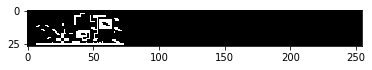

In [178]:
plt.imshow(torch.flip(asd, [-2]), cmap='gray', vmin=0, vmax=1)

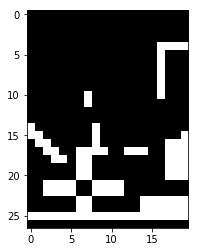

In [179]:
plt.imshow(torch.flip(asd[:,20:40], [-2]), cmap='gray', vmin=0, vmax=1)

In [183]:
for levelMM in tqdm(marioMakerLevels):
    levelMM.mainLevelArea.toPytorchMatrix()

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:00<00:00, 27.80it/s]

bene dai


AssertionError: occupato: tensor(180489289924) 62 2 2 True True 2560 20960 5 True 15 130

In [180]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad[:]):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
#     tSet = set()
#     oSet = set()
#     for terrain in level.mainLevelArea.tiles:
#         tSet.add((terrain.xPosition, terrain.yPosition))
#         #print(str(terrain))
#         oSet.add((objectMM.xPosition, objectMM.yPosition))
        
#         if (objectMM.xPosition, objectMM.yPosition) in tSet and objectMM.layer == 1:
#             print(objectMM)
        
        
    
#     print(tSet.intersection(oSet))
    
    
    print(level.header.courseName.decode("utf-16"))
    print(levelName)
    level.mainLevelArea.toPytorchMatrix()

  0%|                                                                                | 4/13971 [00:00<10:22, 22.45it/s]

                                 
.bcd
.                                
._12720.bcd
0-1 Strawberry Marshmallow       
0-1_strawberry_marshmallow_13844.bcd
0-2 The Wind Rises               
0-2_the_wind_rises_15637.bcd


  0%|                                                                                | 8/13971 [00:00<09:39, 24.07it/s]

000                              
000_3523.bcd
001                              
001_2447.bcd
001                              
001_4583.bcd
007 - Bond, Mario Bond ♪         
007_-_bond_mario_bond__2958.bcd
00                               
00_12889.bcd
00                               
00_4633.bcd
01castle                         
01castle_4415.bcd


  0%|                                                                               | 15/13971 [00:00<08:56, 26.01it/s]

01flyinghouse                    
01flyinghouse_4452.bcd
01Forest                         
01forest_4431.bcd
01ghost                          
01ghost_4139.bcd
01                               
01_12890.bcd
01                               
01_721.bcd
01 Bordel dans le desert         
01_bordel_dans_le_desert_4453.bcd


  0%|                                                                               | 18/13971 [00:00<10:46, 21.58it/s]

03: Kleiner Abenteuer-Dschungel  
03_kleiner_abenteuer-dschungel_878.bcd
05:00 AM                         
05_00_am_12100.bcd
099                              
099_13632.bcd
0_0              d               

  0%|▏                                                                              | 25/13971 [00:00<09:06, 25.53it/s]


0_0d_12647.bcd
0                                
0_2849.bcd
0 Degrees Shellsius #TS #ST      
0_degrees_shellsius_ts_st_11763.bcd
1-1.exe has encountered an error 
1-1.exe_has_encountered_an_error_737.bcd
1-1but it autoscrolls vertically 
1-1but_it_autoscrolls_vertically_10902.bcd
1-1 1-2                          
1-1_1-2_511.bcd
1-1                              

  0%|▏                                                                              | 28/13971 [00:01<10:46, 21.58it/s]


1-1_12888.bcd
1-1                              
1-1_178.bcd
1-1                              
1-1_2545.bcd
1-1                              
1-1_5129.bcd


  0%|▏                                                                              | 32/13971 [00:01<10:05, 23.01it/s]

1-1                              
1-1_6168.bcd
1-1 Appel Wood Valley            
1-1_appel_wood_valley_2963.bcd
1-1 but ...?     ist             
1-1_but_..._ist_2697.bcd
1-1 but in a nintedo switch      
1-1_but_in_a_nintedo_switch_12223.bcd
1-1 but its on and off           
1-1_but_its_on_and_off_12337.bcd


  0%|▏                                                                              | 35/13971 [00:01<10:16, 22.60it/s]

1-1 But It's Played By A Goomba  
1-1_but_it_s_played_by_a_goomba_10551.bcd
1-1, but it's shaky              
1-1_but_it_s_shaky_13985.bcd


  0%|▏                                                                              | 38/13971 [00:01<13:36, 17.07it/s]

1-1 but Mother Nature is MAD!    
1-1_but_mother_nature_is_mad__2720.bcd
1-1 but this joke is dead :(     
1-1_but_this_joke_is_dead__8179.bcd


  0%|▏                                                                              | 40/13971 [00:01<18:26, 12.59it/s]

1-1 but with an extra twist      
1-1_but_with_an_extra_twist_4023.bcd
1-1 but with a twist             
1-1_but_with_a_twist_2394.bcd
1-1 Deluxe (NES REMASTER) !!     
1-1_deluxe_nes_remaster__11875.bcd


  0%|▎                                                                              | 45/13971 [00:02<18:04, 12.84it/s]

1-1 Flipped On Its Side! 0s) nt! 
1-1_flipped_on_its_side_0s_nt__4041.bcd
1-1 Freewheelin  mb's Blues e    
1-1_freewheelinmb_s_bluese_15011.bcd
1-1 Glitch Wall  -1 Remake       
1-1_glitch_wall-1_remake_4421.bcd
1-1  goomba hills  (5 starcoins) 
1-1_goomba_hills_5_starcoins__13736.bcd
1-1 Grassy Goomba Grounds ds     
1-1_grassy_goomba_groundsds_13483.bcd


  0%|▎                                                                              | 49/13971 [00:02<15:05, 15.37it/s]

1-1を壊さないで！！　Lakitu Breaks 1-1    
1-1_lakitu_breaks_1-1_11651.bcd
1-1 Leaving Home                 
1-1_leaving_home_2863.bcd
1-1 Mario 3                      
1-1_mario_3_12722.bcd
1-1 Mario Bros.: A New Journey   
1-1_mario_bros._a_new_journey_14350.bcd
1-1: Muncher Mines               

  0%|▎                                                                              | 54/13971 [00:02<13:33, 17.10it/s]


1-1_muncher_mines_5058.bcd
1-1: Mushroom Fields Forever     
1-1_mushroom_fields_forever_14403.bcd
1-1: Mystical Mushrooms.         
1-1_mystical_mushrooms._12384.bcd
1-1 New Super Mario Bros 2       
1-1_new_super_mario_bros_2_13492.bcd


  0%|▎                                                                              | 57/13971 [00:02<12:22, 18.74it/s]

1-1 Offical Nintendo Autoscroll  
1-1_offical_nintendo_autoscroll_5340.bcd
1-1 On/Off Hill  ction           
1-1_on_off_hillction_1085.bcd
1-1 Platform Plains              
1-1_platform_plains_13414.bcd
1-1 Remastered                   
1-1_remastered_10783.bcd
1-1 Remix                        

  0%|▎                                                                              | 60/13971 [00:03<11:53, 19.51it/s]


1-1_remix_557.bcd
1-1 (SMB 3) Christmas Special    
1-1_smb_3_christmas_special_7120.bcd
1-1 SMB                          
1-1_smb_451.bcd
1-1: Spinjump Valley             
1-1_spinjump_valley_4380.bcd


  0%|▎                                                                              | 65/13971 [00:03<15:38, 14.82it/s]

1-1 Super Mario Bros. 2          
1-1_super_mario_bros._2_12781.bcd
1-1 the crazy woods e wege       
1-1_the_crazy_woodse_wege_1316.bcd


  0%|▍                                                                              | 68/13971 [00:03<14:44, 15.71it/s]

1-1 without the ground           
1-1_without_the_ground_6808.bcd
1-1 Without Touching the Ground  
1-1_without_touching_the_ground_2164.bcd
1-1?                             
1-1__1164.bcd
1-2.exe has encountered an ěřŕôŕ 
1-2.exe_has_encountered_an__876.bcd
1-2 ノコノコレジデンス -Troopa Town-      

  1%|▍                                                                              | 70/13971 [00:03<14:02, 16.50it/s]


1-2_-troopa_town-_10277.bcd
1-2                              
1-2_10813.bcd
1-2                              
1-2_1961.bcd
1-2 "3 pièces dans 3 pièces"     
1-2_3_pi_ces_dans_3_pi_ces__1393.bcd


  1%|▍                                                                              | 76/13971 [00:04<15:20, 15.09it/s]

1-2                              
1-2_5130.bcd
1-2 but without ground           
1-2_but_without_ground_8587.bcd
1-2 Deluxe (NES REMASTER) Level) 
1-2_deluxe_nes_remaster_level__9001.bcd


  1%|▍                                                                              | 78/13971 [00:04<15:30, 14.94it/s]

1-2 Easy Ocean   u               
1-2_easy_oceanu_11055.bcd
1-2 Highwater    mb's Blues e    
1-2_highwatermb_s_bluese_15010.bcd
1-2: King Boboboomboom's Cavern  
1-2_king_boboboomboom_s_cavern_5059.bcd


  1%|▍                                                                              | 80/13971 [00:04<16:39, 13.90it/s]

1-2 Love never dies #Bakedpotato 
1-2_love_never_dies_bakedpotato_14743.bcd
1-2 Mushroom Sky                 
1-2_mushroom_sky_14371.bcd
1-2: Pesky Pipelines.            
1-2_pesky_pipelines._12340.bcd


  1%|▍                                                                              | 82/13971 [00:04<27:49,  8.32it/s]

1-2 Piranha Pipe Grotto          
1-2_piranha_pipe_grotto_2950.bcd
1-2 Slippery Slope Slide [30s] ] 
1-2_slippery_slope_slide_30s__14465.bcd


  1%|▌                                                                              | 89/13971 [00:05<22:03, 10.49it/s]

1-2 SMB                          
1-2_smb_452.bcd
1-2 Taking It Back               
1-2_taking_it_back_4496.bcd
1-2 The 76 Strip   w Zealand     
1-2_the_76_stripw_zealand_15248.bcd
1-2: The Long and Winding Roots  
1-2_the_long_and_winding_roots_14415.bcd
1-3 カラフル空中庭園 -Shiny Sky Garden-  
1-3_-shiny_sky_garden-_10387.bcd
1-3                              
1-3_5131.bcd
1-3: Across the Caps             
1-3_across_the_caps_14386.bcd
1-3 Deluxe (NES REMASTER) Level) 
1-3_deluxe_nes_remaster_level__11869.bcd


  1%|▌                                                                              | 92/13971 [00:05<21:25, 10.79it/s]

1-3 Flight School                
1-3_flight_school_4497.bcd
1-3 Kirstie's Serene Swim m ! !  
1-3_kirstie_s_serene_swimm__2584.bcd
1-3: Lord Kiavik's Demise l ern  
1-3_lord_kiavik_s_demiselern_5060.bcd


  1%|▌                                                                              | 95/13971 [00:05<20:55, 11.05it/s]

1-3 Mushroom Heights  s          
1-3_mushroom_heightss_13521.bcd
1-3 mushroom tower until the sky 
1-3_mushroom_tower_until_the_sky_13797.bcd


  1%|▌                                                                              | 99/13971 [00:06<21:10, 10.92it/s]

1-3 Piranha Plains               
1-3_piranha_plains_13765.bcd
1-3 Roll on John mb's Blues e    
1-3_roll_on_johnmb_s_bluese_15009.bcd
1-3 Sky Ruins                    
1-3_sky_ruins_14326.bcd
1-3 SMB                          

  1%|▌                                                                             | 101/13971 [00:06<18:25, 12.54it/s]


1-3_smb_453.bcd
1-3 Snowshroom Summit            
1-3_snowshroom_summit_3304.bcd


  1%|▌                                                                             | 103/13971 [00:06<25:59,  8.90it/s]

1-3 Spikeball Tower              
1-3_spikeball_tower_13394.bcd
1-3: Stiletto Skys. rs           
1-3_stiletto_skys.rs_12354.bcd
1-3 Submerged Obsidian           

  1%|▌                                                                             | 105/13971 [00:06<22:58, 10.06it/s]


1-3_submerged_obsidian_13741.bcd
1-4 ブンブントンネル -Boom Boom Tunnel-  
1-4_-boom_boom_tunnel-_10318.bcd


  1%|▌                                                                             | 107/13971 [00:07<23:30,  9.83it/s]

1-4 - The Floor is Goombas ) ..! 
1-4_-_the_floor_is_goombas_..__7419.bcd
1-4                              
1-4_5132.bcd
1-4 Bodacious Boot Dash [20s]    
1-4_bodacious_boot_dash_20s__14449.bcd


  1%|▌                                                                             | 111/13971 [00:07<21:05, 10.96it/s]

1-4: Boom Boom's Seesaw Shrooms  
1-4_boom_boom_s_seesaw_shrooms_5037.bcd
1-4 Deep Breathe                 
1-4_deep_breathe_4498.bcd
1-4 Fiery Fortress               
1-4_fiery_fortress_11106.bcd
1-4: Sizzle and Swing  Climb     
1-4_sizzle_and_swing_climb_13013.bcd


  1%|▋                                                                             | 113/13971 [00:07<19:51, 11.63it/s]

1-4 Sky Platforms ms in the sky  
1-4_sky_platformsms_in_the_sky_14372.bcd
1-4: Underground Fungi Fortress. 
1-4_underground_fungi_fortress._12385.bcd


  1%|▋                                                                             | 115/13971 [00:08<30:57,  7.46it/s]

1-5: Basidiomycota Bastion.      
1-5_basidiomycota_bastion._12376.bcd


  1%|▋                                                                             | 116/13971 [00:08<36:05,  6.40it/s]

1-5 Clown Amusement Park         
1-5_clown_amusement_park_14791.bcd
1-5 Larry's Skewering Castle     
1-5_larry_s_skewering_castle_13400.bcd


  1%|▋                                                                             | 120/13971 [00:08<27:38,  8.35it/s]

1-5 Sky Castle   astle           
1-5_sky_castleastle_14325.bcd
1-6: Mushroom Meltdown           
1-6_mushroom_meltdown_12355.bcd
1-6　おどる わかめの うみのなか　Seaweed Swim  
1-6_seaweed_swim_7497.bcd


  1%|▋                                                                             | 125/13971 [00:08<19:44, 11.69it/s]

1-7 Bunte Dimensionen            
1-7_bunte_dimensionen_2982.bcd
1-7　おなかがすいた おはながさいた　Foodie Field 
1-7_foodie_field_8221.bcd
1-7 Yoshi Fun                    
1-7_yoshi_fun_4501.bcd
1-8 Bring it back 2              
1-8_bring_it_back_2_4502.bcd
1-9 Ship Has Flight              
1-9_ship_has_flight_4503.bcd
1-A: Submerged Shiitake          
1-a_submerged_shiitake_12352.bcd


  1%|▋                                                                             | 129/13971 [00:09<27:50,  8.29it/s]

1-B: Glomeromycota Airship       
1-b_glomeromycota_airship_12371.bcd
1-S: VENDETTA!   s Demise l ern  
1-s_vendetta_s_demiselern_5061.bcd
1-ups galore                     
1-ups_galore_5653.bcd
1-城　ほうだいリフト のりほうだい　Blaster Boats 
1-_blaster_boats_8307.bcd


  1%|▋                                                                             | 131/13971 [00:09<24:15,  9.51it/s]

1000 Ways to Die![Koopa Edition] 
1000_ways_to_die_koopa_edition__4176.bcd
1000人紹介企画　かまぼこ隊完成記念※説明要チェック 」    
1000__12111.bcd


  1%|▊                                                                             | 135/13971 [00:10<22:08, 10.41it/s]

100 Coin Challenge: Winter Winds 
100_coin_challenge_winterwinds_279.bcd
100 Year Flood   her             
100_year_floodher_10894.bcd
                                 
1026759769.bcd
                                 
1046974344.bcd
                                 
1048912984.bcd
10kSpecial♪Ultimate FNAF Medley♪ 
10kspecial_ultimate_fnaf_medley__11609.bcd


  1%|▊                                                                             | 143/13971 [00:10<16:30, 13.96it/s]

10k Expert Endless Special (20s) 
10k_expert_endless_special_20s__12559.bcd
10o                              
10o_2433.bcd
10sec2                           
10sec2_607.bcd
10sec challenge ～銀河氷～            
10sec_challenge__6485.bcd
10sec Fugitive remake            
10sec_fugitive_remake_194.bcd
10秒マリオ　音符抜け     　る。 クッパを倒そう！ el1 
10_el1_2315.bcd
10秒間に畳み掛けるダッシュ半自動！！　　Keep Y+→ +→ 
10_keep_y__8222.bcd
10 Seconds Cloud Run             

  1%|▊                                                                             | 151/13971 [00:10<11:49, 19.49it/s]


10_seconds_cloud_run_3055.bcd
10 Seconds: Fiery Fist of Fury   
10_seconds_fiery_fist_of_fury_10432.bcd
10 seconds Speed Run ～Z Castle～  
10_seconds_speed_run_z_castle__8404.bcd
10 Seconds: Super Star Speedrun  
10_seconds_super_star_speedrun_10422.bcd
10 Second Shell Jump Challenge   
10_second_shell_jump_challenge_15523.bcd


  1%|▊                                                                             | 155/13971 [00:10<10:25, 22.07it/s]

10 second speedrun               
10_second_speedrun_15347.bcd
10 Second Speedrun!              
10_second_speedrun__2244.bcd
10コインを出すだけの簡単なお仕事。               
10__1501.bcd
10秒！                             
10__6495.bcd
11-4                             
11-4_10731.bcd


  1%|▉                                                                             | 158/13971 [00:11<10:27, 22.01it/s]

1111                             
1111_3505.bcd
1111                             
1111_468.bcd
11                               
11_11019.bcd
11                               
11_12148.bcd
11                               
11_13626.bcd
11                               
11_7475.bcd
120秒スピードラン　攻略せよ！暗黒のスピラン魔城 ！      
120__8650.bcd


  1%|▉                                                                             | 163/13971 [00:11<10:35, 21.73it/s]

1234                             
1234_5646.bcd
1234ㄱㄷㄹㅎㅅㄱ       d               
1234_d_12654.bcd
123                              
123_12828.bcd
123                              
123_3175.bcd
123                              
123_4643.bcd
123ㄷㅈㅂㅁㄴ         d               
123_d_12664.bcd
123             ㄀ㄹㅇ              
123__12662.bcd


  1%|▉                                                                             | 173/13971 [00:11<10:04, 22.81it/s]

12aaa                            
12aaa_3843.bcd
12               nowy Slide lide 
12nowy_slidelide_12642.bcd
12                               
12_4569.bcd
12 petar                         
12_petar_6209.bcd
12월이건데가         윀나가의나가           
12__12640.bcd
                                 
1339926839.bcd
13θθθポイント記念爽快コース[Refreshcourse]  
13_refreshcourse__7498.bcd


  1%|▉                                                                             | 178/13971 [00:11<08:26, 27.25it/s]

                                 
1419776409.bcd
                                 
1446024433.bcd
                                 
151792073.bcd
15 POW Challenges                
15_pow_challenges_2734.bcd
                                 
1670982820.bcd
                                 
168892518.bcd
                                 
1770627167.bcd
                                 
1841839243.bcd
                                 
1869112192.bcd
18                               
18_1226.bcd
                                 
1905429383.bcd
                                 
1968084012.bcd
1999                             
1999_10477.bcd


  1%|█                                                                             | 194/13971 [00:12<07:13, 31.78it/s]

1                d               
1d_12663.bcd
1                d               
1d_12665.bcd
1er Tour de Bowser.Jr            
1er_tour_de_bowser.jr_512.bcd
1min.MARIO                       
1min.mario_2494.bcd
1st level                        
1st_level_4399.bcd
1Suntouch Sanctuary              
1suntouch_sanctuary_1188.bcd
1 - 1                            
1_-_1_13452.bcd
1                                
1_1129.bcd
1                                
1_1183.bcd
1                                
1_1229.bcd
1                                
1_12652.bcd
1                                
1_12846.bcd
1                                
1_14672.bcd


  2%|█▏                                                                            | 213/13971 [00:12<05:58, 38.40it/s]

1                                
1_1806.bcd
1                                
1_1807.bcd
1画面ステージ / 1screen stage ～ZELDA～  
1_1screen_stage_zelda__6595.bcd
1～1　～波打つコース～                     
1_1__3252.bcd
1                                
1_2060.bcd
1!22                             
1_22_10867.bcd
1                                
1_2413.bcd
1                                
1_2450.bcd
1                                
1_2814.bcd
1秒に泣く30秒スピラン                     
1_30__158.bcd
1                                
1_3165.bcd
1                                
1_3504.bcd
1                                
1_3521.bcd
1                                
1_4439.bcd
1                                
1_4456.bcd
1                                
1_4548.bcd
1                                

  2%|█▎                                                                            | 226/13971 [00:12<04:53, 46.90it/s]


1_4551.bcd
1                                
1_6643.bcd
1                                
1_6645.bcd
1                                
1_730.bcd
1                                
1_8988.bcd
1=ªççlllswweerrfdffxccdswedfffff 
1_lllswweerrfdffxccdswedfffff_6685.bcd
1 Ounce Floaty Boi Bounce ce     
1_ounce_floaty_boi_bouncece_15457.bcd
1画面マリオPART13                     
1_part13_11317.bcd
1画面Puzzle III                    
1_puzzle_iii_13647.bcd
1画面Puzzle II                     
1_puzzle_ii_13650.bcd
1画面Puzzle II rev. 2.0            
1_puzzle_ii_rev._2.0_13649.bcd
1画面Puzzle I                      
1_puzzle_i_13651.bcd
1画面Puzzle VI  $Don't Look Back$  
1_puzzle_vi_don_t_look_back__13646.bcd
1 ROOM PUZZLE: Gemini s it? g    
1_room_puzzle_geminis_it_g_6185.bcd


  2%|█▎                                                                            | 239/13971 [00:12<04:38, 49.36it/s]

1 Screen: Fire and Ice           
1_screen_fire_and_ice_7390.bcd
1 Screen Puzzle                  
1_screen_puzzle_10996.bcd
1 screen puzzle                  
1_screen_puzzle_1380.bcd
1 SCREEN PUZZLE: Coin Bombing    
1_screen_puzzle_coin_bombing_6184.bcd
1 SCREEN PUZZLE: MoleVenture     
1_screen_puzzle_moleventure_6201.bcd
1 Screen Puzzle: Muncher Guards  
1_screen_puzzle_muncher_guards_10655.bcd
1 Screen Puzzle: Reutilize s ds  
1_screen_puzzle_reutilizesds_11506.bcd
1 Screen Puzzle: Sky Tower Shell 
1_screen_puzzle_sky_towershell_9166.bcd
1 Screen Puzzle: Slide Over      
1_screen_puzzle_slide_over_12570.bcd
1 Screen Puzzle: SMB2 Mario      
1_screen_puzzle_smb2_mario_13396.bcd
1 SCREEN PUZZLE: Spring Required 

  2%|█▍                                                                            | 252/13971 [00:13<04:06, 55.56it/s]


1_screen_puzzle_spring_required_6181.bcd
1 SCREEN PUZZLE: Thwomp Day      
1_screen_puzzle_thwomp_day_307.bcd
1 Screen Puzzle: Triple Keys ds  
1_screen_puzzle_triple_keysds_10978.bcd
1 Screen: The Floor is Hot Lava  
1_screen_the_floor_is_hot_lava_7356.bcd
1 Screen: Water Snake            
1_screen_water_snake_7354.bcd
1 up                             
1_up_439.bcd
1発ドア                             
1__10752.bcd
1画面謎解き                           
1__11284.bcd
1画面耐久ステージ！                       
1__1524.bcd
2-1: Dzuttsun    8ngcheckkkk     
2-1_dzuttsun8ngcheckkkk_5062.bcd
2-1 Little Drummer Boy lues e    
2-1_little_drummer_boyluese_15008.bcd
2-1: Otherworldly Overworld.     
2-1_otherworldly_overworld._12380.bcd
2-1　ノコノコの しゅうらく　Redshell Resort  
2-1_redshell_resort_8501.bcd


  2%|█▍                                                                            | 259/13971 [00:13<09:03, 25.24it/s]

2-1: The Fool on the Hill        
2-1_the_fool_on_the_hill_14416.bcd
2-1 Wiggler Forest               
2-1_wiggler_forest_14378.bcd
2-2 Cheep-Cheep Sea              
2-2_cheep-cheep_sea_14329.bcd
2-2 プクプクの オアシス/Cheep Cheep Oasis 
2-2_cheep_cheep_oasis_2091.bcd
2-2 Donut Lift Caves             
2-2_donut_lift_caves_13510.bcd


  2%|█▍                                                                            | 264/13971 [00:14<11:19, 20.16it/s]

2-2 Frostybottom Hills           
2-2_frostybottom_hills_3005.bcd
2-2 Into the desert cave sh  20s 
2-2_into_the_desert_cavesh_20s_7853.bcd
2-2: Let It Breeze Long s        
2-2_let_it_breezelongs_14385.bcd
2-2 Outlaw Run     w Zealand     
2-2_outlaw_runw_zealand_15246.bcd
2-2: Panic at the Platform-Tower 
2-2_panic_at_the_platform-tower_14294.bcd


  2%|█▍                                                                            | 268/13971 [00:14<13:20, 17.11it/s]

2-2 海へ山へ！そして空へ！/road to airship! 
2-2_road_to_airship__13813.bcd
2-2 Spiny Spelunking             
2-2_spiny_spelunking_13488.bcd
2-2: Tundra Turmoil.             
2-2_tundra_turmoil._12344.bcd


  2%|█▌                                                                            | 271/13971 [00:14<19:51, 11.50it/s]

2-2: Under The (Scary) Sea ones  
2-2_under_the_scary_seaones_5063.bcd
2-2 Wild West Winds              
2-2_wild_west_winds_3007.bcd
2-3 シーソー広場 -Seesaw Square-       
2-3_-seesaw_square-_11072.bcd


  2%|█▌                                                                            | 274/13971 [00:15<19:14, 11.86it/s]

2-3: Fishy Fleet.  cat person"   
2-3_fishy_fleet._cat_person__12390.bcd
2-3: Here Comes the Angry Sun    
2-3_here_comes_the_angry_sun_14418.bcd
2-3 Masters Of War 's Blues e    
2-3_masters_of_war_s_bluese_15006.bcd


  2%|█▌                                                                            | 276/13971 [00:15<17:16, 13.22it/s]

2-3 Mushroom Growth drun [20s]   
2-3_mushroom_growthdrun_20s__13419.bcd
2-3 Paranormal Pipe Palace       
2-3_paranormal_pipe_palace_13408.bcd
2-3 Poisonous Cave               
2-3_poisonous_cave_14327.bcd


  2%|█▌                                                                            | 280/13971 [00:15<18:30, 12.33it/s]

2-3 Remake       rk of pain      
2-3_remakerk_of_pain_6554.bcd
2-3: Rubble ruins                
2-3_rubble_ruins_13972.bcd
2-3: Subglacial Stepping Stones  
2-3_subglacial_stepping_stones_3441.bcd


  2%|█▌                                                                            | 282/13971 [00:15<20:56, 10.90it/s]

2-3　ハナチャン だいこうしん　Wiggler Woods s 
2-3_wiggler_woodss_11367.bcd
2-4 Big Cedar      w Zealand     
2-4_big_cedarw_zealand_14451.bcd
2-4: Dig a Pokey                 
2-4_dig_a_pokey_14387.bcd
2-4 Frostybottom Hills           
2-4_frostybottom_hills_2961.bcd


  2%|█▌                                                                            | 287/13971 [00:16<16:39, 13.69it/s]

2-4: Koopahari Keep              
2-4_koopahari_keep_5041.bcd
2-4 Piranha Plant Forest         
2-4_piranha_plant_forest_14363.bcd
2-4: Piranha Pyramid Peril. run! 
2-4_piranha_pyramid_peril.run__12357.bcd


  2%|█▌                                                                            | 289/13971 [00:16<30:10,  7.56it/s]

2-4 Roy's Spiky Seesaw Castle    
2-4_roy_s_spiky_seesaw_castle_13773.bcd
2-4 Toxisches Terrain            
2-4_toxisches_terrain_2975.bcd
2-4 Trembling Tall Tower         
2-4_trembling_tall_tower_2990.bcd


  2%|█▌                                                                            | 291/13971 [00:16<26:38,  8.56it/s]

2-5 Fire in the Hole Zealand     
2-5_fire_in_the_holezealand_15357.bcd
2-5 Gumba-Gipfel                 
2-5_gumba-gipfel_2997.bcd


  2%|█▋                                                                            | 293/13971 [00:17<25:12,  9.04it/s]

2-5: Molten Moonlight            
2-5_molten_moonlight_12383.bcd


  2%|█▋                                                                            | 295/13971 [00:17<34:53,  6.53it/s]

2-5 Poisonous Castle  Castle     
2-5_poisonous_castle_castle_14362.bcd
2-6: Enter Boom Boom!            
2-6_enter_boom_boom__12368.bcd
2-A: Shiny Spiny Skies.          
2-a_shiny_spiny_skies._12349.bcd


  2%|█▋                                                                            | 297/13971 [00:17<29:31,  7.72it/s]

2-B: Gloomy Goombrats. Remix     
2-b_gloomy_goombrats.remix_12381.bcd


  2%|█▋                                                                            | 299/13971 [00:18<40:54,  5.57it/s]

2-C Morton's Speed Rise Infest   
2-c_morton_s_speed_rise_infest_15633.bcd
2-S: The White Palace            
2-s_the_white_palace_5065.bcd


  2%|█▋                                                                            | 302/13971 [00:18<34:40,  6.57it/s]

20-second speedrun but it's not. 
20-second_speedrun_but_it_s_not._13318.bcd
2001: A Space Odyssey            
2001_a_space_odyssey_5372.bcd
2012                             
2012_11242.bcd


  2%|█▋                                                                            | 306/13971 [00:18<26:44,  8.52it/s]

                                 
2063199109.bcd
20seconds : Auto-Switch House  c 
20seconds_auto-switch_house_c_2632.bcd
20seconds : Boom castle 2        
20seconds_boom_castle_2_13221.bcd
20seconds: Earthquake Jungle Run 
20seconds_earthquake_jungle_run_3629.bcd
20seconds : Grinder Speedrun     
20seconds_grinder_speedrun_12481.bcd


  2%|█▋                                                                            | 308/13971 [00:19<25:51,  8.81it/s]

20seconds :On/Off switch house e 
20seconds_on_off_switch_housee_3685.bcd
20seconds : Pipe party！！！ ouse e 
20seconds_pipe_party_ousee_3704.bcd


  2%|█▋                                                                            | 311/13971 [00:19<35:31,  6.41it/s]

20seconds : Poison switcher      
20seconds_poison_switcher_4326.bcd
20seconds : Simple on/off cave   

  2%|█▋                                                                            | 312/13971 [00:19<32:35,  6.99it/s]


20seconds_simple_on_off_cave_6279.bcd
20Seconds Speed Run Challenge☆   
20seconds_speed_run_challenge__12013.bcd
20seconds : Spiny rain           
20seconds_spiny_rain_3974.bcd


  2%|█▊                                                                            | 316/13971 [00:20<24:57,  9.12it/s]

20seconds:Thwomp Desert2/ドッスン砂漠2 
20seconds_thwomp_desert2_2_6323.bcd
20second : Grinder & Lift Panic  
20second_grinder_lift_panic_12525.bcd
20second SPEED RUN!! #2          
20second_speed_run_2_11662.bcd


  2%|█▊                                                                            | 318/13971 [00:20<24:05,  9.45it/s]

20second SPEED RUN!! #3          
20second_speed_run_3_11985.bcd
20second speed run               
20second_speed_run_7193.bcd
20Second:　Swicth&Lift Speed Run！ 
20second_swicth_lift_speed_run__9144.bcd


  2%|█▊                                                                            | 321/13971 [00:20<24:51,  9.15it/s]

20Second:switch run 2            
20second_switch_run_2_4215.bcd
20Sec/ピーパックン スピードラン 2☆SPEED RUN★ 
20sec_2_speed_run__14424.bcd


  2%|█▊                                                                            | 324/13971 [00:21<26:23,  8.62it/s]

20sec 3DJerome3D Grove speedrun  
20sec_3djerome3d_grove_speedrun_4321.bcd
20sec BLG-X Chain Chomp speedrun 
20sec_blg-x_chain_chomp_speedrun_4294.bcd
20sec Challenge SPPED RUN #1     
20sec_challenge_spped_run_1_12021.bcd
20sec fire barrier 8 speedrun    
20sec_fire_barrier_8_speedrun_3956.bcd


  2%|█▊                                                                            | 329/13971 [00:21<23:27,  9.69it/s]

20sec fire barrier speedrun 2    
20sec_fire_barrier_speedrun_2_3632.bcd
20sec fire barrier speedrun      
20sec_fire_barrier_speedrun_3631.bcd
20sec Jooboo Ruins speedrun un   
20sec_jooboo_ruins_speedrunun_4260.bcd
20sec Luigi John chase run  n    
20sec_luigi_john_chase_runn_4228.bcd


  2%|█▊                                                                            | 331/13971 [00:21<28:28,  7.98it/s]

20sec Moist Pipeline Panic!  20s 
20sec_moist_pipeline_panic_20s_11732.bcd
20sec Momoモモ Castle speedrun     
20sec_momo_castle_speedrun_4328.bcd


  2%|█▊                                                                            | 333/13971 [00:22<24:59,  9.09it/s]

20sec NoGeniusノ Snow speedrun    
20sec_nogenius_snow_speedrun_4229.bcd
20sec peaceful forest speedrun   
20sec_peaceful_forest_speedrun_3931.bcd


  2%|█▊                                                                            | 335/13971 [00:22<28:18,  8.03it/s]

20sec ♪Pluto Snow speedrun       
20sec_pluto_snow_speedrun_4311.bcd
20sec snow run 寒い土地は走るに限るのスピードラン 
20sec_snow_run__2960.bcd
20sec speedrun for the fastest   
20sec_speedrun_for_the_fastest_3681.bcd
20Sec/暗闇のトゲこんぼうスピードラン/Speed run  

  2%|█▉                                                                            | 338/13971 [00:22<24:59,  9.09it/s]


20sec_speed_run_14171.bcd
20sec speed run:新感覚!踏むスピードラン     
20sec_speed_run__11945.bcd


  2%|█▉                                                                            | 342/13971 [00:22<20:03, 11.32it/s]

20sec SR|Cindy Temple speedrun   
20sec_sr_cindy_temple_speedrun_4256.bcd
20sec Wolf Castle platform run   
20sec_wolf_castle_platform_run_4254.bcd
20sec スピードラン    　ン　              
20sec__191.bcd
20s POW castle exhilarating ver. 
20s_pow_castle_exhilarating_ver._4359.bcd
20s:Sky On/Off Speedrun          
20s_sky_on_off_speedrun_11206.bcd


  2%|█▉                                                                            | 346/13971 [00:23<22:09, 10.25it/s]

20s speedrun: Lava hopping 3     
20s_speedrun_lava_hopping_3_10444.bcd
20s speedrun　どくどく洞窟\Poison cave  
20s_speedrun_poison_cave_11474.bcd
20秒スピードラン / 毒沼で爽快にEnjoy！！        
20_enjoy__12012.bcd


  2%|█▉                                                                            | 348/13971 [00:23<24:18,  9.34it/s]

20 Secondes: Easy mode           
20_secondes_easy_mode_12205.bcd
20 Seconds: Abominable Snowmen   
20_seconds_abominable_snowmen_7362.bcd
20 Seconds: Aerial Armada        
20_seconds_aerial_armada_7352.bcd


  3%|█▉                                                                            | 350/13971 [00:23<23:10,  9.79it/s]

20 seconds: Arctic Tundra Dash   
20_seconds_arctic_tundra_dash_12944.bcd
20 seconds: Auto Switch Heaven   
20_seconds_auto_switch_heaven_3045.bcd


  3%|█▉                                                                            | 353/13971 [00:24<33:42,  6.73it/s]

20 seconds: Beatles cave!        
20_seconds_beatles_cave__2675.bcd
20 Seconds: Belly of the Beast   
20_seconds_belly_of_the_beast_8921.bcd


  3%|█▉                                                                            | 355/13971 [00:24<30:45,  7.38it/s]

20 Seconds: Blackout Blitz ades  
20_seconds_blackout_blitzades_2628.bcd
20 Seconds: Bob-omb Blastoff     
20_seconds_bob-omb_blastoff_739.bcd


  3%|█▉                                                                            | 358/13971 [00:24<25:31,  8.89it/s]

20 seconds: Bob-omb Bonanza  n   
20_seconds_bob-omb_bonanzan_6305.bcd
20 seconds: Bowser on/off castle 
20_seconds_bowser_on_off_castle_3646.bcd
20 Seconds: Buzzy Beetle Blaze   
20_seconds_buzzy_beetle_blaze_381.bcd
20 seconds: Buzzy Castle         
20_seconds_buzzy_castle_3647.bcd


  3%|██                                                                            | 362/13971 [00:25<25:32,  8.88it/s]

20 Seconds: Cannonball Capers    
20_seconds_cannonball_capers_2611.bcd
20 Seconds: Cannonball Panic     
20_seconds_cannonball_panic_4220.bcd
20 Seconds: Cannonball Panic!    
20_seconds_cannonball_panic__4295.bcd


  3%|██                                                                            | 364/13971 [00:25<30:50,  7.35it/s]

20 Seconds: Cannon Catastrophe   
20_seconds_cannon_catastrophe_11938.bcd
20 seconds: Celestial Koopa Jump 
20_seconds_celestial_koopa_jump_3392.bcd


  3%|██                                                                            | 366/13971 [00:26<40:33,  5.59it/s]

20 Seconds challenge 1-4         
20_seconds_challenge_1-4_2222.bcd
20 seconds: Colorful Sky Rush h  
20_seconds_colorful_sky_rushh_12956.bcd


  3%|██                                                                            | 367/13971 [00:26<40:01,  5.66it/s]

20 Seconds: Countdown Crumble    
20_seconds_countdown_crumble_1407.bcd
20 Seconds: Daunting Desert Dash 
20_seconds_daunting_desert_dash_778.bcd


  3%|██                                                                            | 369/13971 [00:26<35:32,  6.38it/s]

20 seconds: Deadly Desert        
20_seconds_deadly_desert_2681.bcd


  3%|██                                                                            | 370/13971 [00:26<46:10,  4.91it/s]

20 seconds: Desert Stiletto Rush 
20_seconds_desert_stiletto_rush_3729.bcd
20 Seconds: Disturbance Dogs     
20_seconds_disturbance_dogs_3697.bcd


  3%|██                                                                            | 372/13971 [00:27<41:22,  5.48it/s]

20 Seconds: Electric Disco       
20_seconds_electric_disco_12004.bcd


  3%|██                                                                            | 374/13971 [00:27<42:14,  5.36it/s]

20 seconds: Elysian Cannon Blast 
20_seconds_elysian_cannon_blast_3668.bcd
20 Seconds: Ethereal POW Garden  
20_seconds_ethereal_pow_garden_1631.bcd
20 Seconds: Fearsome Fire Fort   
20_seconds_fearsome_fire_fort_1911.bcd


  3%|██                                                                            | 378/13971 [00:28<35:15,  6.43it/s]

20 seconds: Fire Run             
20_seconds_fire_run_2223.bcd
20 Seconds: Flooded Forest       
20_seconds_flooded_forest_7350.bcd
20 Seconds : Freezy Galaxy       
20_seconds_freezy_galaxy_3684.bcd


  3%|██▏                                                                           | 381/13971 [00:28<33:10,  6.83it/s]

20 seconds: Get Down             
20_seconds_get_down_2685.bcd
20 Seconds: Ghost of a Chance    
20_seconds_ghost_of_a_chance_7402.bcd
20 seconds: Goomba's Armada      
20_seconds_goomba_s_armada_3710.bcd


  3%|██▏                                                                           | 385/13971 [00:28<22:40,  9.98it/s]

20 Seconds Great Flow Speedrun   
20_seconds_great_flow_speedrun_2274.bcd
20 Seconds: Highspeed Hill Climb 
20_seconds_highspeed_hill_climb_3345.bcd
20 Seconds: High In The Clouds   
20_seconds_high_in_the_clouds_4304.bcd
20 seconds: King Thwomp's Castle 
20_seconds_king_thwomp_s_castle_10886.bcd
20 seconds: Link's Frosty Dash   
20_seconds_link_s_frosty_dash_7190.bcd


  3%|██▏                                                                           | 387/13971 [00:29<30:21,  7.46it/s]

20 seconds: ♪♪Little Star♪♪      
20_seconds_little_star__3604.bcd
20 Seconds: Majestic Clouds      
20_seconds_majestic_clouds_13426.bcd


  3%|██▏                                                                           | 389/13971 [00:29<29:49,  7.59it/s]

20 Seconds: Mega Mario Smashdown 
20_seconds_mega_mario_smashdown_787.bcd
20 seconds: Muncher Cave!        
20_seconds_muncher_cave__3371.bcd


  3%|██▏                                                                           | 392/13971 [00:29<28:20,  7.99it/s]

20 seconds: My brother Thwomp!   
20_seconds_my_brother_thwomp__2717.bcd
20 seconds: Pipeline Lift Sprint 
20_seconds_pipeline_lift_sprint_8564.bcd


  3%|██▏                                                                           | 394/13971 [00:30<30:10,  7.50it/s]

20 seconds: Piranha Cave         
20_seconds_piranha_cave_2238.bcd
20 Seconds: Platform Panic       
20_seconds_platform_panic_3394.bcd
20 Seconds: Platform Pushthrough 

  3%|██▏                                                                           | 396/13971 [00:30<27:05,  8.35it/s]


20_seconds_platform_pushthrough_733.bcd
20 Seconds: POWer Mansion!       
20_seconds_power_mansion__3627.bcd


  3%|██▏                                                                           | 397/13971 [00:30<31:31,  7.17it/s]

20 Seconds: POW Block Blitz Y+→  
20_seconds_pow_block_blitzy__347.bcd
20 seconds: POW Block Mansion    
20_seconds_pow_block_mansion_3300.bcd


  3%|██▏                                                                           | 399/13971 [00:30<30:23,  7.44it/s]

20 seconds: POW Block Mountain   
20_seconds_pow_block_mountain_2239.bcd


  3%|██▏                                                                           | 400/13971 [00:30<39:24,  5.74it/s]

20 Seconds: Pow Throw Overflow   
20_seconds_pow_throw_overflow_3374.bcd


  3%|██▏                                                                           | 402/13971 [00:31<41:18,  5.47it/s]

20 Seconds: Rainbow Run - Kotaku 
20_seconds_rainbow_run_-_kotaku_7372.bcd
20 seconds: Sawblade-Castle      
20_seconds_sawblade-castle_12929.bcd


  3%|██▏                                                                           | 403/13971 [00:31<47:55,  4.72it/s]

20 seconds: ☆Sharp Sky☆          
20_seconds_sharp_sky__11098.bcd
20 seconds: Sky Auto switch Run  
20_seconds_sky_auto_switch_run_3951.bcd


  3%|██▎                                                                           | 405/13971 [00:31<43:25,  5.21it/s]

20 Seconds: Slide To Victory     
20_seconds_slide_to_victory_1691.bcd
20 seconds: Snowy Death          
20_seconds_snowy_death_2221.bcd


  3%|██▎                                                                           | 408/13971 [00:32<36:13,  6.24it/s]

20 Seconds : Snow Boll SpeedRun！ 
20_seconds_snow_boll_speedrun__10440.bcd
20 seconds: Snow Storm!          
20_seconds_snow_storm__3612.bcd


  3%|██▎                                                                           | 409/13971 [00:32<36:33,  6.18it/s]

20 Seconds: Speed of Sound       
20_seconds_speed_of_sound_3366.bcd


  3%|██▎                                                                           | 411/13971 [00:32<41:08,  5.49it/s]

20 seconds: Spiky Spiny Forest   
20_seconds_spiky_spiny_forest_2748.bcd
20 seconds: Spinning Thwomps     
20_seconds_spinning_thwomps_2683.bcd


  3%|██▎                                                                           | 414/13971 [00:33<39:47,  5.68it/s]

20 Seconds: Super Flimsy Parkour 
20_seconds_super_flimsy_parkour_12571.bcd
20 Seconds: Super MATRIX Bros    
20_seconds_super_matrix_bros_4266.bcd
20 Seconds: Super Star Sprint    
20_seconds_super_star_sprint_3972.bcd


  3%|██▎                                                                           | 416/13971 [00:33<42:34,  5.31it/s]

20 Seconds: Swift Switcheroo     
20_seconds_swift_switcheroo_3638.bcd
20 Seconds: Switch Block Blast n 
20_seconds_switch_block_blastn_325.bcd


  3%|██▎                                                                           | 418/13971 [00:33<35:21,  6.39it/s]

20 Seconds:switch run 0秒スピードラン   
20_seconds_switch_run0__3944.bcd
20 Seconds: Switch Sky Station h 
20_seconds_switch_sky_stationh_783.bcd
20 Seconds: Tee Hee Two          

  3%|██▎                                                                           | 420/13971 [00:34<32:45,  6.90it/s]


20_seconds_tee_hee_two_2980.bcd
20 seconds: Thwomp Castle Run!   
20_seconds_thwomp_castle_run__3634.bcd


  3%|██▎                                                                           | 421/13971 [00:34<35:24,  6.38it/s]

20 Seconds: Thwomp Temple Run  h 
20_seconds_thwomp_temple_runh_1390.bcd
20 seconds: Toxic Sewers Run!    
20_seconds_toxic_sewers_run__3636.bcd


  3%|██▎                                                                           | 424/13971 [00:34<29:37,  7.62it/s]

20 Seconds: !!To Hot For You!!   
20_seconds_to_hot_for_you__3672.bcd
20 second: House of Switches     
20_second_house_of_switches_2228.bcd


  3%|██▍                                                                           | 426/13971 [00:34<31:47,  7.10it/s]

20 Second Icicle Speedrun        
20_second_icicle_speedrun_3448.bcd
20 second mayhem part I          
20_second_mayhem_part_i_8383.bcd


  3%|██▍                                                                           | 430/13971 [00:35<24:56,  9.05it/s]

20 Second Puzzle Room (Icy Cave) 
20_second_puzzle_room_icy_cave__2708.bcd
20 second run! (moderate)        
20_second_run_moderate__932.bcd
20 Second Shell Jump Challenge   
20_second_shell_jump_challenge_15522.bcd
20 Second Speed  d               
20_second_speedd_726.bcd
20 second speed run estar　Music  
20_second_speed_runestar_music_4967.bcd


  3%|██▍                                                                           | 434/13971 [00:35<20:04, 11.24it/s]

20 Second Switch Run             
20_second_switch_run_4002.bcd
20 Second Switch Speedrun        
20_second_switch_speedrun_4343.bcd
20 Second Variety Speedrun!      
20_second_variety_speedrun__2243.bcd
20 SECS: An Icy, ON and OFF Run  
20_secs_an_icy_on_and_off_run_2282.bcd
20 secs of Tunnel Vision?  l?    

  3%|██▍                                                                           | 437/13971 [00:35<17:09, 13.15it/s]


20_secs_of_tunnel_vision_l__8986.bcd
20 secs: Red Koopa = Hold Jump   
20_secs_red_koopa_hold_jump_7150.bcd
20 sec: Delightful Cannon Blast  
20_sec_delightful_cannon_blast_7625.bcd


  3%|██▍                                                                           | 439/13971 [00:35<23:33,  9.57it/s]

20 Sec Mario Dash - Boo's House  
20_sec_mario_dash_-_boo_s_house_3059.bcd


  3%|██▍                                                                           | 441/13971 [00:36<27:25,  8.22it/s]

20 Sec Mario Dash - Moon Rockets 
20_sec_mario_dash_-_moon_rockets_3346.bcd
20 Sec on/off Desert Run         
20_sec_on_off_desert_run_1669.bcd
20 Sec : ON/OFF & Lift SpeedRun！ 
20_sec_on_off_lift_speedrun__11199.bcd


  3%|██▍                                                                           | 444/13971 [00:36<27:50,  8.10it/s]

20 sec run POW- & On/Off-Block   
20_sec_run_pow-_on_off-block_13618.bcd
20 Sec: Speed Run Kill Chomp     
20_sec_speed_run_kill_chomp_4521.bcd
20秒スピードラン！SPEEDRUN 20sec         

  3%|██▍                                                                           | 446/13971 [00:36<26:11,  8.61it/s]


20_speedrun_20sec_4986.bcd
20秒マリオ          　の               
20__6551.bcd
                                 
211975947.bcd
                                 
2159168434.bcd
                                 
2177569259.bcd
                                 
2220054183.bcd
2222wwweeeeeeeeeeeeeeeeee        
2222wwweeeeeeeeeeeeeeeeee_12136.bcd
222                              
222_2066.bcd
222                              
222_3163.bcd
222              yo              
222_yo_6684.bcd
                                 
225596230.bcd
                                 
2256920871.bcd
                                 
2257841957.bcd
                                 
2258427207.bcd
                                 
2282694719.bcd
                                 
2283608302.bcd
                                 
2307086209.bcd
2323                             
2323_12644.bcd
                                 
2447036274.bcd
                                 
2495851129.bcd


  3%|██▌                                                                           | 467/13971 [00:36<18:40, 12.05it/s]

                                 
2498568271.bcd
24 Yeet Street (Candle Sets) )   
24_yeet_street_candle_sets__1566.bcd
                                 
2555860737.bcd
                                 
2590432691.bcd
                                 
2632905899.bcd
                                 
264992946.bcd
                                 
2754396542.bcd
                                 
278197583.bcd
28-4                             
28-4_10846.bcd
                                 
2829675772.bcd
                                 
2858866363.bcd
28 Days Later                    
28_days_later_5366.bcd
                                 
2917051394.bcd
                                 
2927977811.bcd
                                 
2962917915.bcd
2Osec Adrian117 Bullet Bill run  
2osec_adrian117_bullet_bill_run_4290.bcd


  3%|██▋                                                                           | 481/13971 [00:37<13:50, 16.24it/s]

2P coop / High danger at castle  
2p_coop_high_danger_at_castle_10264.bcd
2p coop|Love won't tear us apart 
2p_coop_love_won_t_tear_us_apart_9236.bcd
2SMB3♪Sky Theme♪KEEP RUNNING >+Y 
2smb3_sky_theme_keep_running_y_8984.bcd


  3%|██▋                                                                           | 488/13971 [00:37<15:06, 14.87it/s]

2                                
2_1153.bcd
2                                
2_1455.bcd
2                                
2_3166.bcd
2=4                              
2_4_13209.bcd
2                                
2_5643.bcd
2                                
2_660.bcd
2 Fast 2 Furious                 
2_fast_2_furious_112.bcd
2エリアダッシュ半自動マリオ Keep run(→+Y)     
2_keep_run_y__2097.bcd
2エリア左ダッシュ半自動マリオ Keep run(←+Y)    
2_keep_run_y__3538.bcd
2 Lies 1 Truth                   

  4%|██▊                                                                           | 494/13971 [00:38<14:55, 15.05it/s]


2_lies_1_truth_1210.bcd
2 Screen Puzzle  er Endeavor v2  
2_screen_puzzleer_endeavor_v2_10887.bcd
2 THWOMP 2 FURIOUS               
2_thwomp_2_furious_3099.bcd


  4%|██▊                                                                           | 499/13971 [00:38<14:20, 15.66it/s]

2人の英雄　 TWO HEROES ES             
2_two_heroeses_5659.bcd
2 Ways to Win                    
2_ways_to_win_458.bcd
2さいきよう                           
2__12156.bcd
3-1: Blue Bay Way                
3-1_blue_bay_way_14410.bcd
3-1 Cave Lifts                   
3-1_cave_lifts_14323.bcd


  4%|██▊                                                                           | 503/13971 [00:38<14:49, 15.14it/s]

3-1 Flockiger Federflug Schloss  
3-1_flockiger_federflugschloss_3004.bcd
3-1: Happy Little Sky Castles    
3-1_happy_little_sky_castles_3382.bcd
3-1 Slow Train Coming AndTell    
3-1_slow_train_comingandtell_15005.bcd
3-1 The Dark lark                
3-1_the_dark_lark_749.bcd
3-1 Welcome to Lawrence  and     

  4%|██▊                                                                           | 506/13971 [00:38<12:57, 17.32it/s]


3-1_welcome_to_lawrenceand_15352.bcd
3-2 Carnivorous Cave             
3-2_carnivorous_cave_14340.bcd


  4%|██▊                                                                           | 509/13971 [00:39<16:57, 13.23it/s]

3-2 Free State    Palace and     
3-2_free_state_palaceand_15236.bcd
3-2: Honey Pond   Gentle Cheeps  
3-2_honey_pond_gentle_cheeps_14383.bcd
3-2 Katakomben der Käfer chloss  
3-2_katakomben_der_k_ferchloss_2901.bcd
3-2 Starlight Cavern             
3-2_starlight_cavern_13729.bcd


  4%|██▊                                                                           | 512/13971 [00:39<25:52,  8.67it/s]

3-2: Taken By Vultures           
3-2_taken_by_vultures_3730.bcd
3-2 White Dove   mb's Blues e    
3-2_white_dovemb_s_bluese_15004.bcd
3-31                             
3-31_11569.bcd
3-3 Celestial Clouds             

  4%|██▉                                                                           | 515/13971 [00:39<21:19, 10.51it/s]


3-3_celestial_clouds_3284.bcd
3-3 まっくらトゲトゲすいろ/Darkness Trench  
3-3_darkness_trench_3592.bcd
3-3 Odds and Ends b's Blues e    
3-3_odds_and_endsb_s_bluese_15003.bcd
3-3: Scroll Lock Sun Block       
3-3_scroll_lock_sun_block_3756.bcd


  4%|██▉                                                                           | 520/13971 [00:40<20:04, 11.17it/s]

3-3 The Docking Station          
3-3_the_docking_station_12116.bcd
3-3 Underground Ghost House      
3-3_underground_ghost_house_14375.bcd


  4%|██▉                                                                           | 522/13971 [00:40<17:30, 12.80it/s]

3-3: You're Gonna Lose That Star 
3-3_you_re_gonna_lose_that_star_14394.bcd
3-3　鉄球海道                         
3-3__8310.bcd
3-4 オーキードーキー号 -Over the Ocean-   
3-4_-over_the_ocean-_11976.bcd
3-4 Big Blooper Sea Sea          
3-4_big_blooper_seasea_13685.bcd


  4%|██▉                                                                           | 528/13971 [00:40<13:39, 16.41it/s]

3-4 Cave Warp Zone               
3-4_cave_warp_zone_13960.bcd
3-4: The Shallow Submarine       
3-4_the_shallow_submarine_5045.bcd
3-4: Wendy's Waterlogged Wonder  
3-4_wendy_s_waterlogged_wonder_13472.bcd
3-5 Underwater Castle            
3-5_underwater_castle_14345.bcd
3-6              lgmh.hk,h,      
3-6lgmh.hk_h__12258.bcd


  4%|██▉                                                                           | 530/13971 [00:40<17:47, 12.59it/s]

3-S: Petey's Pipeline Passage    
3-s_petey_s_pipeline_passage_5069.bcd
3...2...1... Blast Off!!! #DGR   
3...2...1..._blast_off_dgr_6823.bcd
3... 2.. 1... Chase!             

  4%|██▉                                                                           | 532/13971 [00:41<19:27, 11.51it/s]


3..._2.._1..._chase__3703.bcd
                                 
3081605063.bcd
                                 
3091309453.bcd
30seconds ON/OFF switch RUN.     
30seconds_on_off_switch_run._1556.bcd
30seconds speedrun easy          
30seconds_speedrun_easy_124.bcd
30sec:Snowball and Lift Speedrun 
30sec_snowball_and_lift_speedrun_11922.bcd


  4%|███                                                                           | 540/13971 [00:41<13:42, 16.33it/s]

30s Speed Glide #RYUSMM          
30s_speed_glide_ryusmm_13346.bcd
30秒スピードラン:雪原　30sec               
30_30sec_7928.bcd
30 Minutes or Less Easy Version) 
30_minutes_or_lesseasy_version__12298.bcd
30 Seconds Collapsing Ice Cave 2 
30_seconds_collapsing_ice_cave_2_4267.bcd
30 Seconds: Collapsing Ice Cave! 
30_seconds_collapsing_ice_cave__4233.bcd
30 Seconds (Normal)              
30_seconds_normal__1877.bcd


  4%|███                                                                           | 543/13971 [00:41<22:54,  9.77it/s]

30 Seconds: Platform Panic 2     
30_seconds_platform_panic_2_3666.bcd
30 Seconds: Platform Panic       
30_seconds_platform_panic_3711.bcd


  4%|███                                                                           | 547/13971 [00:42<21:29, 10.41it/s]

30 Seconds: Run With The Shell   
30_seconds_run_with_the_shell_3875.bcd
30秒スピードランだにょ～ん！！                 
30__7349.bcd
                                 
3207326817.bcd
                                 
3254873506.bcd
                                 
3342475126.bcd
                                 
3388192462.bcd
                                 
3397052829.bcd
33                               
33_1156.bcd
                                 
3446821192.bcd
                                 
3525973811.bcd
                                 
357916012.bcd
                                 
3622731693.bcd
                                 
3646751399.bcd
                                 
3815595138.bcd
                                 
3819145478.bcd
                                 
3820782242.bcd
                                 
3829652849.bcd
                                 
3830731390.bcd
                                 
3956666638.bcd
3G → 4G → 5G [POW] Run Run Run!! 
3g_4g_5g_pow_run_

  4%|███▏                                                                          | 565/13971 [00:42<15:40, 14.25it/s]

3x20 Speedrun     them all       
3x20_speedrun_them_all_13735.bcd
3                                
3_2795.bcd


  4%|███▏                                                                          | 570/13971 [00:42<15:20, 14.56it/s]

3 2 1... blast off! ap           
3_2_1..._blast_off_ap_13525.bcd
3                                
3_3167.bcd
3択クイズ/3ChoiceQuiz m ngle         
3_3choicequizmngle_1300.bcd
3段ジャンプスピラン / 3 Jump Speed Run.   
3_3_jump_speed_run._8662.bcd
3 keys            g              

  4%|███▏                                                                          | 574/13971 [00:43<14:38, 15.25it/s]


3_keysg_6942.bcd
3 player versus                  
3_player_versus_10759.bcd
3 skin sky speed run!!!　【20sec】  
3_skin_sky_speed_run_20sec__4960.bcd
3日後…１マス針抜けの意外な突破方法を伝授しマッスルマッスル～w 
3_w_10714.bcd
3段ジャンプが苦手な人コース                   
3__12130.bcd
3段ジャンプ→カベキック→ヒップドロップ             
3__1510.bcd
4-1　巨大の国に迷い込んだマリオ　/　BIG ISLAND   
4-1_big_island_11429.bcd
4-1 Bone-Dry Valley              

  4%|███▏                                                                          | 580/13971 [00:43<12:29, 17.87it/s]


4-1_bone-dry_valley_3009.bcd
4-1 Canned Heat   Square         
4-1_canned_heat_square_14874.bcd
4-1 Mossy Mountains              
4-1_mossy_mountains_3225.bcd


  4%|███▎                                                                          | 583/13971 [00:43<13:59, 15.95it/s]

4-1 Pokey Desert                 
4-1_pokey_desert_14346.bcd
4-1: Polythene Peak              
4-1_polythene_peak_14391.bcd
4-1: Skullcrusher Cove           
4-1_skullcrusher_cove_5070.bcd


  4%|███▎                                                                          | 586/13971 [00:43<16:34, 13.46it/s]

4-2: ... In Another Castle       
4-2_..._in_another_castle_5071.bcd
4-2 Bone-Dry Valley              
4-2_bone-dry_valley_2966.bcd
4-2 Desert Tomb                  
4-2_desert_tomb_14356.bcd
4-2 Mystic Mushrooms             
4-2_mystic_mushrooms_3549.bcd


  4%|███▎                                                                          | 589/13971 [00:43<14:14, 15.67it/s]

4-2: Rubber Soil                 
4-2_rubber_soil_14398.bcd
4-2 Woodland Lake  el            
4-2_woodland_lakeel_13774.bcd
4-2　ふたつの国を行ったり来たり                
4-2__11104.bcd
4-3 Bone-Dry Valley              
4-3_bone-dry_valley_2972.bcd


  4%|███▎                                                                          | 594/13971 [00:44<16:24, 13.59it/s]

4-3: Buflen's Mad Lads           
4-3_buflen_s_mad_lads_5072.bcd
4-3 Oasis City                   
4-3_oasis_city_14334.bcd
4-3: Rock-'n-Rolling Buzzies     
4-3_rock-_n-rolling_buzzies_14399.bcd
4-4 Bone-Dry Valley              
4-4_bone-dry_valley_2979.bcd


  4%|███▎                                                                          | 596/13971 [00:44<20:51, 10.69it/s]

4-4 haunted castle               
4-4_haunted_castle_1308.bcd
4-4: Iggy's Mystery Mansion      

  4%|███▎                                                                          | 598/13971 [00:44<23:45,  9.38it/s]


4-4_iggy_s_mystery_mansion_14407.bcd
4-4 Koopa Graveyard              
4-4_koopa_graveyard_14349.bcd
4-4　パックン一族の生家/Piranha Plant Home 
4-4_piranha_plant_home_12547.bcd


  4%|███▍                                                                          | 605/13971 [00:45<20:09, 11.05it/s]

4-5 Desert Castle  Castle        
4-5_desert_castle_castle_14342.bcd
                                 
4027683562.bcd
                                 
4057997827.bcd
                                 
4079403332.bcd
40sec Pokemon Speed Run ポケモスピドラン 
40sec_pokemon_speed_run__3741.bcd
40sec 　崩れる城を駆け抜けろ！               
40sec__6506.bcd


  4%|███▍                                                                          | 607/13971 [00:45<28:43,  7.76it/s]

40S  ジャングルの中を駆け抜けよう SPEED RUN    
40s_speed_run_4273.bcd
40 seconds: Frogger lava rush!   
40_seconds_frogger_lava_rush__13672.bcd
40 Seconds: Thwomp run           
40_seconds_thwomp_run_11981.bcd


  4%|███▍                                                                          | 611/13971 [00:46<23:09,  9.62it/s]

40 Second: Poisonmushroom run    
40_second_poisonmushroom_run_13068.bcd
40 Second Speed Run              
40_second_speed_run_725.bcd
40秒スピードラン　雪玉をポイっとな！！             
40__9213.bcd


  4%|███▍                                                                          | 613/13971 [00:46<25:31,  8.72it/s]

                                 
4104383830.bcd
                                 
4133161973.bcd
                                 
4156805599.bcd
                                 
4159029297.bcd
                                 
4236142070.bcd
444                              
444_3170.bcd
4 - 2 Crystal Cliffs             
4_-_2_crystal_cliffs_5105.bcd


  4%|███▍                                                                          | 622/13971 [00:46<17:22, 12.81it/s]

4                                
4_3168.bcd
4 Challenges [Medium]            
4_challenges_medium__943.bcd
4 little puzzles cters password  
4_little_puzzlescters_password_4440.bcd
4 Player Battle                  
4_player_battle_2105.bcd
4 Player Mayhem!! Slippery Race  
4_player_mayhem_slippery_race_1760.bcd


  4%|███▌                                                                          | 627/13971 [00:47<14:08, 15.73it/s]

4 Player Versus #1 - Skyclimb    
4_player_versus_1_-_skyclimb_3227.bcd
4種の武器でボムシューティング　WEAPON SHOOTING  
4_weapon_shooting_3552.bcd
4人レースwith急降下/4Race with NoseDive 
4_with_4race_with_nosedive_2075.bcd
4 you                            
4_you_12680.bcd
4人で対決！最後まで逆転可能な爽快レース！！           

  5%|███▌                                                                          | 629/13971 [00:47<15:20, 14.50it/s]


4__1950.bcd
5-1: 1-Screen Winter Wonders     
5-1_1-screen_winter_wonders_4014.bcd


  5%|███▌                                                                          | 631/13971 [00:47<20:06, 11.05it/s]

5-1 キラーキラー マウンテン/Bullets Heights 
5-1_bullets_heights_9024.bcd
5-1 Diving Down Deep             
5-1_diving_down_deep_13511.bcd
5-1 Snowy Plains                 
5-1_snowy_plains_14343.bcd
5-1: Sour Milk Sky               

  5%|███▌                                                                          | 634/13971 [00:47<16:20, 13.60it/s]


5-1_sour_milk_sky_14390.bcd
5-1: The Friendly Skies          
5-1_the_friendly_skies_6536.bcd
5-2 Cloudy Top Heights           
5-2_cloudy_top_heights_2971.bcd


  5%|███▌                                                                          | 636/13971 [00:48<24:39,  9.01it/s]

5-2 Shocking Spinies             
5-2_shocking_spinies_13516.bcd
5-2 Snowball Mountain            
5-2_snowball_mountain_14344.bcd


  5%|███▌                                                                          | 640/13971 [00:48<22:08, 10.03it/s]

5-2: The Legend of DekuScrub     
5-2_the_legend_of_dekuscrub_4305.bcd
5-2: Winds Of Love louds         
5-2_winds_of_lovelouds_14402.bcd
5-3 Cold Mushroom Sky bridge     
5-3_cold_mushroom_skybridge_14354.bcd
5-3: Lord Gold's Throneroom      

  5%|███▌                                                                          | 642/13971 [00:48<18:58, 11.71it/s]


5-3_lord_gold_s_throneroom_5268.bcd
5-3: Ticket To Ride Beetles      
5-3_ticket_to_ride_beetles_14395.bcd
5-4 Cloudy Top Heights           
5-4_cloudy_top_heights_2621.bcd


  5%|███▌                                                                          | 648/13971 [00:48<14:41, 15.12it/s]

5-4 Icy Caverns                  
5-4_icy_caverns_14357.bcd
5-4: Paperback Freighter         
5-4_paperback_freighter_5053.bcd
5-4　青い空が大好きです　/　Roy's Airship    
5-4_roy_s_airship_13865.bcd
5-5 Castle of Fire and Ice       
5-5_castle_of_fire_and_ice_14347.bcd
5-S: Petey joins #TeamPrecision  
5-s_petey_joins_teamprecision_5267.bcd
50秒スピードラン / 炎のON/OFFスイッチランナー ー   
50_on_off__11183.bcd


  5%|███▋                                                                          | 650/13971 [00:49<20:58, 10.58it/s]

50 Seconds of Hard Platforming 3 
50_seconds_of_hard_platforming_3_11476.bcd
50 Second:  run 【hard】 hard】     
50_second_run_hard_hard__11458.bcd


  5%|███▋                                                                          | 652/13971 [00:49<23:13,  9.56it/s]

50秒スピードラン　電光石火の如く走り抜け！！ があるんだ    
50__10697.bcd


  5%|███▋                                                                          | 654/13971 [00:49<29:09,  7.61it/s]

50命不够用                           
50__11014.bcd
50秒スピラン！                         
50__12122.bcd
50秒スピードラン はしれはしれ！にげろにげろ！         
50__6510.bcd


  5%|███▋                                                                          | 660/13971 [00:50<29:12,  7.60it/s]

536体のテレサを回避する神回避全自動　　AUTO        
536_auto_9000.bcd
5555                             
5555_1108.bcd
555                              
555_3171.bcd
跳ね馬！じゃじゃ馬！スーパーボール！               
5dc42437000a9b2200cead2a.bcd
Super Mario Sunshine's Sand Bird 
5dc424370010b27700cead25.bcd
UNDERGROUND WORLD　ー地下世界のアスレチックー  

  5%|███▋                                                                          | 662/13971 [00:50<25:38,  8.65it/s]


5dc42437001ddc6700cead2e.bcd
Multiplayer Versus!! / みんなでバトル！！ 
5dc42437002708dd00cead26.bcd
ぽいずんふれんず                         
5dc42437002b78cf00cead24.bcd
A Pipedream in Switchland        
5dc42437004e922000cead23.bcd
Super Metroid X Super Mario      
5dc42437006e37f800cead2f.bcd


  5%|███▋                                                                          | 666/13971 [00:50<20:18, 10.92it/s]

Balls to the Walls               
5dc424370074a85b00cead2d.bcd
Uno Mas: Big Mario's Secret      
5dc4243700d7e0df00cead2b.bcd
Back to Gameboy   ake block      
5dc4243700f2846a00cead2c.bcd


  5%|███▋                                                                          | 669/13971 [00:50<19:02, 11.64it/s]

Breakout          Jeep           
5dc42438000093f000cead33.bcd
Friends are Rotten!              
5dc424380006dcf000cead3e.bcd
AutoMAGIC                        
5dc42438000d567b00cead3c.bcd


  5%|███▊                                                                          | 674/13971 [00:51<17:30, 12.65it/s]

Teamwork Castle                  
5dc424380015d96200cead42.bcd
table tennis                     
5dc4243800186ebb00cead44.bcd
Tick Tock Clock [SM64]           
5dc42438002015b100cead32.bcd
Brother, Can You Spare A Coin?   

  5%|███▊                                                                          | 677/13971 [00:51<15:05, 14.68it/s]


5dc4243800357a2900cead31.bcd
Superballin'                     
5dc424380043463d00cead46.bcd
Puzzle Rooms 2                   
5dc42438004e781e00cead3b.bcd
The Mirror Puzzles; first part.  
5dc42438004fc51d00cead3d.bcd


  5%|███▊                                                                          | 681/13971 [00:51<18:05, 12.24it/s]

The Mirror Puzzles; part 2.      
5dc42438005e4e7a00cead40.bcd
Table Tennis in SMM2!            
5dc424380072979e00cead36.bcd


  5%|███▊                                                                          | 684/13971 [00:51<15:52, 13.95it/s]

スイッチ仕掛けのお化け屋敷                    
5dc42438008abd8700cead47.bcd
信じてDASH JUMP!                    
5dc42438009014da00cead41.bcd
♪Country Roads♪ →Walk→           
5dc4243800a8bd4e00cead3a.bcd
スーパーマリオボール　Super Mario Ball      
5dc4243800adb7f200cead38.bcd
Stormy Mushroom Jungle           
5dc4243800b45a0500cead48.bcd


  5%|███▊                                                                          | 688/13971 [00:52<16:22, 13.52it/s]

★ The 4 Player Showdown ★        
5dc4243800ca818b00cead39.bcd
♪シオカラ節　Calamari Inkantation♪　1/2 
5dc4243800d600fc00cead34.bcd
New Game, New Ideas - Puzzle     
5dc4243800d86a4d00cead43.bcd


  5%|███▊                                                                          | 694/13971 [00:52<13:36, 16.26it/s]

marios shooting range            
5dc4243800f1922600cead3f.bcd
Escape Room                      
5dc4243800ff62b300cead35.bcd
Pong                             
5dc424390015ba3400cead56.bcd
謎解き脱出ゲーム的な                       
5dc424390024464700cead49.bcd
スーパーボールつかい                       
5dc4243900261d2400cead5c.bcd
♪シオカラ節　Calamari Inkantation♪　2/2 
5dc42439003d087500cead4f.bcd
Table Tennis                     
5dc424390052491800cead51.bcd


  5%|███▉                                                                          | 696/13971 [00:52<16:45, 13.20it/s]

謎解きループコース　Mystery Loop Level     
5dc4243900579eb700cead5b.bcd


  5%|███▉                                                                          | 698/13971 [00:53<23:07,  9.57it/s]

♪Running in the 90's♪ Hold Y+Run 
5dc42439005bbc7500cead58.bcd
Wet and Dry                      
5dc424390061454100cead4b.bcd


  5%|███▉                                                                          | 703/13971 [00:53<19:24, 11.39it/s]

Puzzle Rooms 4                   
5dc424390068892500cead50.bcd
Icicle run                       
5dc4243900761ef900cead4e.bcd
SMB3 Tennis                      
5dc42439008e9a3b00cead54.bcd
PAC-MAN in SMM2  er              
5dc424390090aea000cead57.bcd
Minijuegos Mario land            
5dc4243900959f3e00cead4a.bcd


  5%|███▉                                                                          | 705/13971 [00:53<17:58, 12.31it/s]

てらして すすんで まっくらいせき                
5dc42439009842d800cead4c.bcd
Desert Pong                      
5dc424390099adb800cead4d.bcd
雪の世界で、カロンコウラをシュート！               
5dc4243900ae92ac00cead53.bcd
Super Smash Bros. Ultimate BGM   
5dc4243900b0385a00cead5a.bcd


  5%|███▉                                                                          | 710/13971 [00:53<15:19, 14.42it/s]

Slide64!                         
5dc4243900c8f50400cead59.bcd
Boom Boom's Evil Pinball Machine 
5dc4243900d9628b00cead55.bcd
[Party Game]  Piranha Pinball    
5dc4243900e9dabf00cead52.bcd
MARIO LAND EX 難易度★★☆☆☆           
5dc4243a0047dcb400cead5d.bcd
Bowser's Inside Story aid        
5dc4243a005d79f900cead5e.bcd


  5%|███▉                                                                          | 713/13971 [00:54<17:10, 12.86it/s]

Spring Has Switched              
5dc4258b000ca3e700cead64.bcd
Sensational Switches             
5dc4258b000d6ba600cead62.bcd


  5%|████                                                                          | 717/13971 [00:54<23:16,  9.49it/s]

カズ遊園地 ～Kazu Amusement Park～      
5dc4258b0055d21e00cead65.bcd
Table Tennis in SMM2! [HARD]     
5dc4258b006741f500cead5f.bcd
The 8 Ancient Cave Coins s       
5dc4258b006bc21d00cead66.bcd


  5%|████                                                                          | 719/13971 [00:55<24:48,  8.90it/s]

Call Of Koop'thulhu              
5dc4258b0098cd7700cead60.bcd
The Simple Machine               
5dc4258b00c3a86b00cead63.bcd
Chain Chonk Temple               
5dc4258b00c4a44100cead61.bcd


  5%|████                                                                          | 721/13971 [00:55<27:12,  8.12it/s]

The Deserted Thwomp Ruins tation 
5dc4258b00cfa2b500cead67.bcd
Parallel Universe                
5dc4258c00007d1a00cead78.bcd


  5%|████                                                                          | 725/13971 [00:55<25:15,  8.74it/s]

The mirrors cave  espejos        
5dc4258c0000e30700cead6d.bcd
AC 1-2 King Dedede's Rhythm Game 
5dc4258c0006178300cead76.bcd
Cloudtop Climb                   
5dc4258c00203b8500cead6b.bcd
Frozen-Over Fantasy              
5dc4258c0022df7300cead69.bcd


  5%|████                                                                          | 728/13971 [00:56<31:37,  6.98it/s]

砂の遺跡にひそむ罠                        
5dc4258c0032cf4000cead7c.bcd
Dungeon Escape                   
5dc4258c0035861f00cead70.bcd


  5%|████                                                                          | 731/13971 [00:56<45:01,  4.90it/s]

Basically A Level                
5dc4258c004217d900cead7e.bcd
追いかけられて(Follow the coins)        
5dc4258c00591ef200cead72.bcd
*~Snowy Swinging And Climbing~*  
5dc4258c0062dcf200cead7a.bcd


  5%|████                                                                          | 734/13971 [00:57<35:33,  6.21it/s]

Flash of Insight tion            
5dc4258c0064094900cead7f.bcd
Abandoned Site                   
5dc4258c006f07b000cead77.bcd
Forest Goop      ngle            
5dc4258c0078a2f700cead71.bcd


  5%|████                                                                          | 736/13971 [00:57<29:33,  7.46it/s]

Tanooki in the Sky World ken     
5dc4258c00949f8e00cead79.bcd
Booting Up the Switch! (Easy) z) 
5dc4258c009513be00cead7d.bcd
白熱！トゲメットレース【イージーver】             

  5%|████                                                                          | 738/13971 [00:57<27:20,  8.07it/s]


5dc4258c00b2ae4300cead74.bcd
Delfino Island    Kyol Ren       
5dc4258c00b493ba00cead7b.bcd


  5%|████▏                                                                         | 740/13971 [00:57<28:04,  7.86it/s]

BOTW - Concept                   
5dc4258c00cd698900cead82.bcd
Tilted Thrill                    
5dc4258c00d1634700cead80.bcd


  5%|████▏                                                                         | 741/13971 [00:58<36:12,  6.09it/s]

Flying Battery Zone              
5dc4258c00def3a700cead75.bcd


  5%|████▏                                                                         | 744/13971 [00:58<38:46,  5.68it/s]

Frostbite Falls Open             
5dc4258c00eee26c00cead73.bcd
Chocolate-Mountain-Expedition!   
5dc4258c00f0235900cead6a.bcd
Icedom Tower                     
5dc4258d000e367b00cead91.bcd


  5%|████▏                                                                         | 746/13971 [00:58<31:05,  7.09it/s]

Metroid World: A love story      
5dc4258d001a610600cead84.bcd
Fetch-Quest Village as           
5dc4258d001d2c2800cead96.bcd
Waibak 1-1: Backtrack Plains     

  5%|████▏                                                                         | 750/13971 [00:58<21:40, 10.17it/s]


5dc4258d001d752300cead99.bcd
かけあがれ！　朽ちた天空の塔                   
5dc4258d002180f900cead8b.bcd
Through the Bomber               
5dc4258d0024ea8300cead8e.bcd
Shlooter!                        
5dc4258d0025f99400cead8f.bcd
S-Claw in Snowfield～雪国のブランコクレーン～ 
5dc4258d0039f6f200cead8c.bcd


  5%|████▏                                                                         | 753/13971 [00:59<19:31, 11.28it/s]

Crimson Dream                    
5dc4258d003f22e000cead90.bcd
Carnivorous Caverns              
5dc4258d0047184300cead83.bcd


  5%|████▏                                                                         | 755/13971 [00:59<20:01, 11.00it/s]

おそらのゴキゲンはシーソーしだい　/  Gramble sky  
5dc4258d004a5dc900cead93.bcd
Deep Wood        nigans          
5dc4258d004a7e3b00cead9a.bcd


  5%|████▏                                                                         | 757/13971 [00:59<21:48, 10.10it/s]

Climate: Change! lds ns Factory  
5dc4258d00554a8200cead85.bcd
A Swing and a Prayer             
5dc4258d006fd9b700cead97.bcd
Thwomp Ruins     ace             
5dc4258d00a8b0ff00cead8a.bcd


  5%|████▏                                                                         | 759/13971 [00:59<24:46,  8.89it/s]

Icy Cavern                       
5dc4258d00bb2e1b00cead92.bcd
[Normal] Going down, please ります  
5dc4258d00bb3a2200cead8d.bcd


  5%|████▎                                                                         | 762/13971 [01:00<29:28,  7.47it/s]

The Sinking Citadel Returns      
5dc4258d00c4e36c00cead86.bcd
Metroid zero mission             
5dc4258d00ccea1000cead87.bcd


  5%|████▎                                                                         | 764/13971 [01:00<27:50,  7.91it/s]

Rainbow's Delight                
5dc4258d00d1a43600cead95.bcd
Master the POW                   
5dc4258d00e2cb5900cead94.bcd
Koopa Madness                    

  5%|████▎                                                                         | 766/13971 [01:00<23:50,  9.23it/s]


5dc4258d00f56ced00cead88.bcd
Nightmare Castle - LPMarkus 01   
5dc4258d00ff41d600cead98.bcd
Canyon Climb                     
5dc425c60043623f00ceada2.bcd


  5%|████▎                                                                         | 768/13971 [01:00<22:00, 10.00it/s]

Celestial Sprint Speedrun [20s]  
5dc425c6007154a100ceada1.bcd


  6%|████▎                                                                         | 770/13971 [01:01<24:21,  9.03it/s]

Pipe Dreams                      
5dc425c6009de4d400cead9d.bcd
Switch x  Switch / スイッチのとりで      
5dc425c600c2333700cead9e.bcd
【Galoomba(クリボン)】Speedrun #3[20s] 
5dc425c600ee043700ceada0.bcd


  6%|████▎                                                                         | 772/13971 [01:01<21:42, 10.14it/s]

Minature 1                       
5dc425c600ee351200cead9b.bcd
【One Screen Puzzle】あらわれし 横ドッスン   
5dc425c70002aec300ceadbd.bcd
Donut Drop Dungeon Deluxe        
5dc425c700038f0700ceada3.bcd


  6%|████▎                                                                         | 775/13971 [01:01<20:16, 10.85it/s]

Thwomp Terror - Run!             
5dc425c700064aeb00ceadb8.bcd
Spectacular Switch Sprint (30s)  
5dc425c7000ac23500ceadb4.bcd


  6%|████▎                                                                         | 779/13971 [01:01<20:57, 10.49it/s]

Chomp Thwomp Ruins               
5dc425c700114cb000ceadc1.bcd
ON/OFFスイッチマスター                   
5dc425c7001e95b600ceadbf.bcd
Space Mission!    problem        
5dc425c70038dfd400ceadaa.bcd
Chin Onescreen-Puzzle 1          
5dc425c7004eac2100ceadc0.bcd
ON/OFFブロックでGO!                   
5dc425c700514bd500ceadbc.bcd


  6%|████▎                                                                         | 783/13971 [01:02<16:41, 13.16it/s]

Switching Speed (Hard)           
5dc425c700540de000ceadac.bcd
Simple Switches                  
5dc425c7005ec99100ceadaf.bcd
Fast Switch Thinking!            
5dc425c70067c88a00ceadab.bcd


  6%|████▍                                                                         | 787/13971 [01:02<15:48, 13.89it/s]

初見殺しって最低                         
5dc425c70070136500ceada5.bcd
On/Off Speedrun - Sklar (Hard)   
5dc425c7007745e200ceadb3.bcd
Side Thwomp Sprint Romp          
5dc425c70078ed3400ceadb6.bcd
Ryan's First Level               

  6%|████▍                                                                         | 789/13971 [01:02<15:47, 13.92it/s]


5dc425c7007dbdd000ceada7.bcd
Twisty Thwomp Romp               
5dc425c7007df3fd00ceadae.bcd
Mario Throws Up                  
5dc425c7009ce7a700ceadb5.bcd


  6%|████▍                                                                         | 794/13971 [01:02<13:45, 15.95it/s]

【One Screen Puzzle】お助けブラックパックン   
5dc425c7009d86eb00ceadb2.bcd
Beware the Forest's Poison       
5dc425c700a0067c00ceadbb.bcd
ブロックパズル/Block Puzzle 詰め合わせ +α    
5dc425c700a0879d00ceadb0.bcd
The Only Three Jump Ruins        
5dc425c700b2b9ec00ceadb7.bcd


  6%|████▍                                                                         | 796/13971 [01:02<16:41, 13.16it/s]

【Galoomba(クリボン)】Speedrun #1[20s] 
5dc425c700b66d7500ceadba.bcd
Zelda OoT: Deku Tree  Deku Tree  
5dc425c700bc70fe00ceada4.bcd


  6%|████▍                                                                         | 798/13971 [01:03<26:58,  8.14it/s]

Planta Island                    
5dc425c700c44fd300ceadbe.bcd
The Lost Factory ll              
5dc425c700c889ff00ceada9.bcd
[SMM1]Defeat the Elite Eight/八鍵将 
5dc425c700d48d2c00ceadc2.bcd


  6%|████▍                                                                         | 800/13971 [01:03<22:14,  9.87it/s]

<= SELF-DESTRUCT: ACTIVATED =>   
5dc425c700d656f500ceada8.bcd
Swaying Swamp Launchers          

  6%|████▍                                                                         | 802/13971 [01:03<25:37,  8.57it/s]


5dc425c80006a0d600ceadce.bcd
Switch-breeze Canyon             
5dc425c800249bf800ceadc5.bcd


  6%|████▍                                                                         | 804/13971 [01:04<26:04,  8.42it/s]

Day One Fun                      
5dc425c80081a17900ceadcf.bcd
The Eight Coins  er?             
5dc425c800820f3e00ceadcd.bcd


  6%|████▍                                                                         | 806/13971 [01:04<25:37,  8.56it/s]

Escape from the forest Thwomps   
5dc425c80084280c00ceadc6.bcd
よこからドッスンごっつん                     
5dc425c8008f239b00ceadca.bcd
Toadettes Winter Adventure       
5dc425c800af200f00ceadcb.bcd


  6%|████▌                                                                         | 810/13971 [01:04<24:05,  9.10it/s]

Eye in the Sky   oreshore Forest 
5dc425c800c0078800ceadc7.bcd
【Bob-omb(ボムへい)】Speedrun #1[20s]  
5dc425c800cfab6000ceadc8.bcd
Level 1-1 rotated by 90° 90°     
5dc425c800dbaa8300ceadc9.bcd
SPEEDY'S ICEY FUN RUN!           
5dc425c800e3775c00ceadd0.bcd


  6%|████▌                                                                         | 814/13971 [01:04<19:17, 11.37it/s]

Binacle          ue              
5dc425c90050943400ceadd6.bcd
ドアに入ってジャンプだ2 Jump from the door2 
5dc425c900563ade00ceadd2.bcd
Wigglers Mechanized Tree Fort    
5dc425c90078a8c000ceadd1.bcd


  6%|████▌                                                                         | 816/13971 [01:05<23:22,  9.38it/s]

走れ！ちょい難50秒SUPEEDRUN! N! N! UN!   
5dc425c90080a2c300ceadd4.bcd
Twisting Tunnel                  
5dc425c9009ac7c500ceadd5.bcd


  6%|████▌                                                                         | 818/13971 [01:05<22:03,  9.94it/s]

The Infernal Machine             
5dc425c900e004b800ceadd3.bcd
babby's first troll              
5dc425e40003801000ceade9.bcd
Poison Surfing                   
5dc425e4000b0fcc00ceade0.bcd
Monochromatic Acrobatic and Bird 
5dc425e4002313a100ceade4.bcd


  6%|████▌                                                                         | 823/13971 [01:05<20:06, 10.90it/s]

Desert Crossing                  
5dc425e400650c6300ceadeb.bcd
Switch Block Skyway              
5dc425e40065ca3c00ceade8.bcd
Floaty Platform Adventure        
5dc425e4006d030700ceadd7.bcd


  6%|████▌                                                                         | 825/13971 [01:06<20:43, 10.57it/s]

Snowy Windy Land                 
5dc425e4007d7eb200ceade2.bcd
Slippery Stalactite              
5dc425e400df583500ceadda.bcd


  6%|████▌                                                                         | 827/13971 [01:06<28:58,  7.56it/s]

Go fast [40]      Don't time out 
5dc425e400e0085400ceadd9.bcd
Claustrophobia                   
5dc425e400f5459000ceade7.bcd
Indi Rio 2 - Desert Quest 1.0    
5dc425e50001556e00ceadf1.bcd


  6%|████▋                                                                         | 832/13971 [01:06<23:44,  9.22it/s]

Celeste - prologue & 1st chapter 
5dc425e5000537b300ceae01.bcd
Welcome to AMM Community!        
5dc425e5001ce89a00ceae04.bcd
Lost Forest Seclusion            
5dc425e500239d3400ceadfa.bcd
5 hard(ish) keycoins             
5dc425e5002ec72f00ceadf2.bcd
Reverse Climbing k               
5dc425e5002f759b00ceadf3.bcd
The arrows don't lie             
5dc425e5003d9fd400ceadfc.bcd


  6%|████▋                                                                         | 837/13971 [01:07<17:25, 12.56it/s]

Escort the Payload: Desert Storm 
5dc425e500485ccc00ceadef.bcd
Galoomba Grabbing                
5dc425e50052fecd00ceae05.bcd
Run for it!                      
5dc425e5005826a600ceadec.bcd
レベル2 普通くらい                       
5dc425e50058840b00ceadf0.bcd
Rainbow Cloud Run  20 Sec]       
5dc425e5005d363400ceadf4.bcd


  6%|████▋                                                                         | 843/13971 [01:07<12:49, 17.06it/s]

Collapsing Cavern                
5dc425e5005f72cd00ceadf6.bcd
Thwomp Racing    ng Adventure    
5dc425e500629fa200ceadf7.bcd
Actual Climbing  k               
5dc425e50066358d00ceadee.bcd
The Forgotten Skies              
5dc425e5006eac8e00ceae00.bcd
Finals IV: Invitational 2019     
5dc425e50073c87600ceadf5.bcd


  6%|████▋                                                                         | 846/13971 [01:07<13:59, 15.64it/s]

Heavenly Feeling                 
5dc425e50084e5d800ceaded.bcd
Perilous Poisonous Speedrun 40s  
5dc425e5008bdcf600ceadff.bcd
the switcheroo                   
5dc425e5008e52cd00ceae09.bcd
Crane Acrobatics                 
5dc425e500910d7d00ceae02.bcd


  6%|████▊                                                                         | 851/13971 [01:07<14:07, 15.49it/s]

初めて作ってSPEED RUN                  
5dc425e50093a73a00ceae03.bcd
The floor is... Poison?!         
5dc425e50098154100ceadfe.bcd
Keizo: Nothing Special           
5dc425e500a99f1400ceae06.bcd
Finde deinen Weg im Wald         
5dc425e500f2c2ea00ceadf8.bcd


  6%|████▊                                                                         | 854/13971 [01:08<14:08, 15.45it/s]

Clear condition: Touch the goal  
5dc425e500f7825500ceae08.bcd
Speedrun 20s                     
5dc425e60021e88b00ceae0f.bcd
Labyrinth of the Moletaurs       
5dc425e6006a265300ceae10.bcd


  6%|████▊                                                                         | 859/13971 [01:08<14:31, 15.05it/s]

My first SPEEDRUN                
5dc425e6007b4c1200ceae0a.bcd
Skyway                           
5dc425e6009fbc6300ceae12.bcd
祝！発売！50seconds speed run         
5dc425e600b7dfc900ceae0b.bcd
Corner Pocket    ship Returns    
5dc4261f00001e6b00ceae17.bcd


  6%|████▊                                                                         | 861/13971 [01:08<15:52, 13.77it/s]

VS Race in the Sky               
5dc4261f000d5c3400ceae14.bcd
Skydiving Dry Bones nes          
5dc4261f00140dfd00ceae25.bcd
Mario Olympic Course #3          
5dc4261f0020fa9800ceae23.bcd


  6%|████▊                                                                         | 863/13971 [01:08<16:25, 13.30it/s]

[UN DE PLUS] Bounciness is jank  
5dc4261f00448b8a00ceae1b.bcd
Only run! (Only press => + Y)    
5dc4261f0059a2f800ceae18.bcd


  6%|████▊                                                                         | 867/13971 [01:09<17:40, 12.36it/s]

Arcade Pinball                   
5dc4261f0069ada800ceae1c.bcd
~Superball Sniper~               
5dc4261f0079af0600ceae1d.bcd
Breakout! (Arcade Game)          
5dc4261f008c1e8a00ceae24.bcd
Trickshot Temple                 
5dc4261f009b18db00ceae22.bcd


  6%|████▊                                                                         | 872/13971 [01:10<27:43,  7.87it/s]

Relaxing Mini Puzzle             
5dc4261f00a1039e00ceae1f.bcd
Inside The Giant Tree            
5dc4261f00aa7a5600ceae1a.bcd
Lost Airship Mission t nd Tower  
5dc4261f00ba735400ceae15.bcd
[SMMW] W1 Buzzy Basin 1          
5dc4261f00c6743300ceae1e.bcd
True Friendship                  
5dc4261f00cc962600ceae16.bcd


  6%|████▉                                                                         | 874/13971 [01:10<31:33,  6.92it/s]

Sandy Claws                      
5dc4261f00d6b51f00ceae21.bcd
Lucky Hit 2: Electric Boogaloo   
5dc4262000091ffe00ceae27.bcd


  6%|████▉                                                                         | 880/13971 [01:10<23:37,  9.23it/s]

ON/OFF #2                        
5dc426200009d35300ceae3a.bcd
エンダ式全自動化ステージPart2                
5dc4262000120efe00ceae28.bcd
サルベージ！深海に眠る沈没船  一庭園              
5dc4262000264fd700ceae2d.bcd
Climbing the Desert Ruins (VS)   
5dc426200040946000ceae33.bcd
We Are Number 1 but read desc.   
5dc42620007d97f700ceae26.bcd
Tricky tricky castle ;)          
5dc426200082ff4500ceae29.bcd


  6%|████▉                                                                         | 882/13971 [01:10<21:27, 10.17it/s]

Bouncing Superballs              
5dc426200085f70a00ceae34.bcd
The big airship  irship!         
5dc4262000930ba900ceae2e.bcd


  6%|████▉                                                                         | 886/13971 [01:11<19:37, 11.11it/s]

Dry Dry Desert                   
5dc4262000969c5f00ceae36.bcd
X = 9 RETURNS!!!                 
5dc4262000ac7ddd00ceae38.bcd
Uno Mas: Quantum Uncertainty     
5dc4262000b3c9f100ceae32.bcd
Corner Pocket 2: Bounce Boogaloo 
5dc4262000c27c6700ceae35.bcd


  6%|████▉                                                                         | 888/13971 [01:11<17:55, 12.16it/s]

Superball Flower Puzzles         
5dc4262000c73a4100ceae37.bcd
King Wiggler's Forest Stronghold 
5dc4262000cc3f0b00ceae39.bcd


  6%|████▉                                                                         | 890/13971 [01:11<19:29, 11.19it/s]

Koopa et Trampoline (auto)       
5dc4262000d2077a00ceae2f.bcd
Legend of Zelda 2 - Palace 1     
5dc4262000d9d9cf00ceae2a.bcd


  6%|████▉                                                                         | 894/13971 [01:12<22:22,  9.74it/s]

The Only Way Is Up!  Red Coins!  
5dc4262000fbd14000ceae2b.bcd
Room Replicas                    
5dc426210001d18400ceae49.bcd
◆◇GameBoy Mario◇◆                
5dc4262100048ac100ceae3f.bcd


  6%|█████                                                                         | 896/13971 [01:12<22:04,  9.87it/s]

ColdClimb to Bowser Jr.'s Castle 
5dc42621000596b500ceae46.bcd
Downwards Dash   1               
5dc42621000b0f4300ceae4c.bcd
(1-1)～(1-4)再現ステージ                
5dc42621001d810400ceae43.bcd


  6%|█████                                                                         | 900/13971 [01:12<17:41, 12.31it/s]

Boom Boom's Basement Brawl wer   
5dc42621003d2f8400ceae42.bcd
Leaky Pipes Land                 
5dc42621005110ac00ceae45.bcd
The Temple of Mechanis           
5dc4262100515b8c00ceae41.bcd


  6%|█████                                                                         | 902/13971 [01:12<16:46, 12.99it/s]

[4-Player] Clumsy Cloud Climb!   
5dc426210078ba6000ceae40.bcd
Town of Thievery                 
5dc42621008b375500ceae3c.bcd
スイッチレース                          

  6%|█████                                                                         | 906/13971 [01:13<16:56, 12.85it/s]


5dc4262100984e7400ceae44.bcd
narly!           own             
5dc4262100af642800ceae48.bcd
To the moon!                     
5dc4262100cbd83000ceae4a.bcd
全自動1-1 / Automatic 1-1           
5dc4262100cbe7f900ceae3b.bcd


  6%|█████                                                                         | 908/13971 [01:13<18:10, 11.98it/s]

Cool, Cool Mountain [3-in-1]     
5dc4262100ce432200ceae3e.bcd
Ghosthouse #4678 - ΠΕΓΡ ΣΕ       
5dc4262100f5c8ef00ceae4d.bcd


  7%|█████                                                                         | 910/13971 [01:13<23:08,  9.41it/s]

The Mirror Puzzles; number 3     
5dc4262100fe165600ceae47.bcd
Galactic Gravity Gauntlet        
5dc4262200405f9000ceae4e.bcd


  7%|█████                                                                         | 912/13971 [01:13<25:34,  8.51it/s]

Golden Snow                      
5dc426380000a14d00ceae5d.bcd
Forgotten Jungle Ruins           
5dc42638000ee44100ceae5c.bcd
[SMMW] W1 Buzzy Bunker           
5dc42638001bc73100ceae51.bcd


  7%|█████                                                                         | 914/13971 [01:13<22:00,  9.88it/s]

WarioWare Smooth Moves           
5dc4263800232d3100ceae57.bcd


  7%|█████                                                                         | 916/13971 [01:14<27:14,  7.99it/s]

Icicle Pressure Plates :0        
5dc4263800271bb200ceae59.bcd
Whack-a-mole                     
5dc426380043dfc800ceae5b.bcd
World 9-4                        
5dc426380063f0f300ceae53.bcd


  7%|█████▏                                                                        | 919/13971 [01:14<22:41,  9.58it/s]

遠隔操作の達人 Remote control master    
5dc426380071c88a00ceae5a.bcd
Super Metroid Bros               
5dc42638007c91d100ceae52.bcd
Ascent to Beetle Mountain        
5dc42638008b3a4600ceae56.bcd
Desert Trek                      
5dc4263800cf315b00ceae54.bcd


  7%|█████▏                                                                        | 926/13971 [01:14<17:57, 12.10it/s]

New One-Screen Puzzle#1/　1画面パズル  
5dc4263800d2c60200ceae4f.bcd
HamaWR 1-3                       
5dc4263800da4a7600ceae5f.bcd
That Goomba Had A Family         
5dc426390005cb9f00ceae6b.bcd
World 2-3-2-4                    
5dc426390018f90e00ceae72.bcd
Searchlight Shenanigans          
5dc4263900340f4300ceae64.bcd
[SMMW] W2 Torte Hills 1          
5dc426390063502d00ceae63.bcd


  7%|█████▏                                                                        | 928/13971 [01:15<20:32, 10.58it/s]

Super Castlevania Bros           
5dc42639006ab2af00ceae62.bcd
困ったときの矢印頼み / Follow the Arrow y  
5dc42639007f10e800ceae65.bcd


  7%|█████▏                                                                        | 932/13971 [01:15<20:51, 10.42it/s]

たとえ みちが みえずとも　Invisible Skyway   
5dc4263900972bfa00ceae6e.bcd
Zelda OoT: Dodongo's Cavern BU   
5dc4263900a6f97100ceae66.bcd
The Flooding Of The Lush Jungle  
5dc4263900ab008700ceae68.bcd


  7%|█████▏                                                                        | 934/13971 [01:15<25:37,  8.48it/s]

Escape Wiggler's Woods!          
5dc4263900afa76e00ceae6c.bcd
Secrets of the Frozen Spire      
5dc4263900b33cba00ceae73.bcd


  7%|█████▏                                                                        | 936/13971 [01:16<26:26,  8.22it/s]

*DKC3 Ripsaw Rage - ハラハラのこぎり     
5dc4263900b9a3c100ceae70.bcd
Trained Spooks   -1              
5dc4263900bae3b400ceae6a.bcd
Flooded Pipeworks                

  7%|█████▏                                                                        | 938/13971 [01:16<22:28,  9.66it/s]


5dc4263900c43fa400ceae6d.bcd
Metroid World: Legend of Samus   
5dc4263900c5e84000ceae67.bcd
Bob-omb house of boom            

  7%|█████▏                                                                        | 940/13971 [01:16<21:40, 10.02it/s]


5dc4263900c8117600ceae61.bcd
Peak Performance bell            
5dc4263900ca52ba00ceae6f.bcd
Super Metroid Bros.              
5dc4263900da6a5500ceae60.bcd


  7%|█████▎                                                                        | 942/13971 [01:16<21:02, 10.32it/s]

Two-State Temple                 
5dc4263a000495a900ceae87.bcd
City of Pipes: Pink Coins        
5dc4263a003c6fc800ceae77.bcd


  7%|█████▎                                                                        | 946/13971 [01:16<19:08, 11.34it/s]

Nature Scratch   g               
5dc4263a00454b7d00ceae81.bcd
Detective Mario   Evil Mole Lair 
5dc4263a004bd1e400ceae82.bcd
Kid Icarus (Underworld) CPY      
5dc4263a004e0ecb00ceae79.bcd
Shadow Temple    t               

  7%|█████▎                                                                        | 948/13971 [01:17<17:27, 12.43it/s]


5dc4263a006dd12b00ceae78.bcd
ServerCrash                      
5dc4263a0079962000ceae88.bcd
Olimar's Pikmin Adventure        
5dc4263a00828e9c00ceae7b.bcd


  7%|█████▎                                                                        | 950/13971 [01:17<17:26, 12.45it/s]

Dangerous Desert Temple          
5dc4263a009e354a00ceae80.bcd


  7%|█████▎                                                                        | 952/13971 [01:17<22:43,  9.55it/s]

Storm-bound Shipment             
5dc4263a009f79b000ceae7f.bcd
The Mystery of Luster Lake e     
5dc4263a00a1169800ceae76.bcd
Kaizo Clawllege: Swing of Things 
5dc4263a00ac0da300ceae85.bcd


  7%|█████▎                                                                        | 954/13971 [01:17<21:55,  9.89it/s]

Glacial Glide                    
5dc4263a00b4f73c00ceae7d.bcd
Your very own running coach      
5dc4263a00b6ad3f00ceae74.bcd


  7%|█████▎                                                                        | 956/13971 [01:17<22:13,  9.76it/s]

Travel in a frozen cavern        
5dc4263a00bc3d0f00ceae7c.bcd
[Super Mario Generations] 1-4    
5dc4263a00db2b9a00ceae75.bcd


  7%|█████▎                                                                        | 958/13971 [01:18<23:22,  9.28it/s]

Ascending the Mountain           
5dc4263a00f0d5ce00ceae7e.bcd


  7%|█████▎                                                                        | 960/13971 [01:18<32:57,  6.58it/s]

Night of the Frigid Dead         
5dc4263b001b077400ceae89.bcd
The Tower of the Angry Sun       
5dc4263b00cfb17c00ceae8a.bcd


  7%|█████▎                                                                        | 962/13971 [01:18<29:38,  7.31it/s]

World 6 - 1 | Monty Mountain     
5dc42654000c57e000ceae9a.bcd
Simple Unreversed Speedrun [20s] 
5dc426540016c34700ceae94.bcd


  7%|█████▍                                                                        | 964/13971 [01:19<27:03,  8.01it/s]

Battle Roulette 2: The Revenge   
5dc426540039260800ceae8c.bcd
Pearly Gate Blitz                
5dc426540041e4bb00ceae96.bcd


  7%|█████▍                                                                        | 967/13971 [01:19<24:43,  8.76it/s]

Purgatory in 8-2                 
5dc42654005d15da00ceae8e.bcd
◆ Serene Swing Mansion ◆ ◆       
5dc42654006f7cf500ceae97.bcd
【Galoomba(クリボン)】Speedrun #4[20s] 
5dc426540070cb7400ceae8f.bcd


  7%|█████▍                                                                        | 970/13971 [01:19<22:21,  9.69it/s]

WELL... DOWN - Vertical Survival 
5dc4265400b50cdf00ceae93.bcd
♪Rhythm Challenge: Gourmet Race♪ 
5dc4265400bee1b900ceae92.bcd
Binding Coil of Bahamut: Turn 5  
5dc4265400f15cdd00ceae90.bcd


  7%|█████▍                                                                        | 972/13971 [01:19<19:37, 11.04it/s]

Frozen Tower                     
5dc4265500025a4800ceaeac.bcd
Celeste: Chapter 3               
5dc42655000b4dfe00ceaea9.bcd
The Very Varying Tower           
5dc42655002d5b3200ceae9d.bcd


  7%|█████▍                                                                        | 974/13971 [01:20<28:37,  7.57it/s]

Madlad Mayhem                    
5dc42655003576b800ceaea5.bcd


  7%|█████▍                                                                        | 977/13971 [01:20<32:34,  6.65it/s]

Alphabet Soup                    
5dc4265500492f2100ceae9f.bcd
THE STALKER                      
5dc42655004e218700ceaea3.bcd
Warioware 2: Electric Boogaloo   

  7%|█████▍                                                                        | 978/13971 [01:20<32:31,  6.66it/s]


5dc426550056cd5800ceaea8.bcd
The Desert Run [20Sec]           
5dc42655005c941f00ceaea2.bcd


  7%|█████▍                                                                        | 981/13971 [01:21<40:10,  5.39it/s]

Stickerbush Swing                
5dc42655007873f700ceaea4.bcd
Ghost House Challenge            
5dc426550079b05b00ceaeab.bcd
Banzai Bounce                    
5dc42655007fe79b00ceae9b.bcd
METROID's Return of Bowser Brain 
5dc42655009dd3a100ceaeae.bcd
Ancient City of Krakenpolis      
5dc4265500a476aa00ceaea0.bcd


  7%|█████▌                                                                        | 986/13971 [01:21<28:31,  7.59it/s]

【One Screen Puzzle】いつでもドア 用      
5dc4265500c14d1b00ceae9e.bcd
【RE】パラシュート降下 Parachuting ster    
5dc4265500c5e57d00ceaead.bcd
Steal the Sun's POW Block        
5dc4265500c6920300ceaea1.bcd


  7%|█████▌                                                                        | 988/13971 [01:21<23:12,  9.32it/s]

Lost 1-1         Ruins           
5dc4265500d7675000ceae9c.bcd
Camp Switchvine                  
5dc4265500db3d8500ceaea6.bcd
Blazing Bullets                  

  7%|█████▌                                                                        | 992/13971 [01:22<19:29, 11.10it/s]


5dc42656000c060400ceaec2.bcd
Clawful                          
5dc426560026d15300ceaeb6.bcd
Skewer Stronghold                
5dc42656002aa72c00ceaebb.bcd
On/Off Switching Craziness       
5dc426560039c3bf00ceaeb2.bcd


  7%|█████▌                                                                        | 997/13971 [01:23<30:50,  7.01it/s]

Upgrade Maze                     
5dc42656003aa95e00ceaebe.bcd
Minecraft's 2B2T (マインケラフト)       
5dc4265600751b2800ceaeb5.bcd
Get off my seesaw !              
5dc4265600793b1800ceaeb1.bcd
The Biggest Race of Yoshi's Life 
5dc42656007f2d6700ceaeb9.bcd
Into the Piranha Plant Pyramid   
5dc426560098a4be00ceaeb7.bcd


  7%|█████▌                                                                        | 999/13971 [01:23<29:17,  7.38it/s]

Shell Launcher Fun!              
5dc426560099b9c700ceaeb0.bcd
横向きドッスンが迫る地下    　マリオ(やっつけ作成ver)  
5dc4265600a1f87000ceaebf.bcd
The King of Swing is... Mario?   
5dc4265600a7f72e00ceaec1.bcd
Mushroom Kingdom Battle Royale   
5dc4265600cd027300ceaec6.bcd


  7%|█████▌                                                                       | 1002/13971 [01:23<25:53,  8.35it/s]

Bowser's Drybone Desert          
5dc4265600cd40e400ceaec4.bcd


  7%|█████▌                                                                       | 1004/13971 [01:24<35:16,  6.13it/s]

Raptured Ruins                   
5dc4265600e4797400ceaebd.bcd
♪Megalovania Rythym Challenge♪   
5dc4265600f578fd00ceaec0.bcd
It's River Time                  
5dc4265600f7c44900ceaebc.bcd
The Sound of Speed               
5dc4265600fe9bce00ceaec5.bcd


  7%|█████▌                                                                       | 1009/13971 [01:24<25:46,  8.38it/s]

Hopping Yoshi                    
5dc42670001b858b00ceaed5.bcd
Jungle Run  20 seconds speedrun  
5dc42670001e435300ceaec7.bcd
▽ Save the Thwomps! ▽            
5dc42670002241f900ceaed2.bcd
Thwomp-It Chomp-It Demolition Co 
5dc42670003262ac00ceaecd.bcd


  7%|█████▌                                                                       | 1014/13971 [01:24<25:33,  8.45it/s]

GLP.TV 05 - Lava is Coming mare  
5dc4267000533b1400ceaec8.bcd
Starlight Shells                 
5dc42670005a876700ceaed3.bcd
Hot Sponge                       
5dc42670005bc36200ceaed1.bcd
Switch-Temple of Madness         
5dc42670005cd33a00ceaed0.bcd


  7%|█████▌                                                                       | 1016/13971 [01:25<22:37,  9.55it/s]

Off/On a desert trip             
5dc42670008e998900ceaecc.bcd
Deserted Temple                  
5dc426700096f12600ceaec9.bcd


  7%|█████▌                                                                       | 1018/13971 [01:25<23:15,  9.28it/s]

Jump'n'Switch                    
5dc4267000b75fb200ceaeca.bcd
Woof 1-6: Sees and Saws          
5dc4267000beab2200ceaed4.bcd
It Came From Beneath the Stink   
5dc4267000c19c5d00ceaecb.bcd


  7%|█████▋                                                                       | 1022/13971 [01:25<21:02, 10.26it/s]

Kaizo Clawllege: Swing Theory    
5dc4267000c54a1a00ceaed7.bcd
Bonzai Bridges                   
5dc4267000e61b5c00ceaecf.bcd
赤髪のともの笑い声                        
5dc4267000ffa81000ceaed6.bcd
Keizo Light: Cloud N             

  7%|█████▋                                                                       | 1024/13971 [01:25<18:21, 11.76it/s]


5dc4267100055f7a00ceaeda.bcd
No Smooth Brains Allowed         
5dc426710014194f00ceaeec.bcd
ﾌｳﾝ坂田城                           
5dc4267100578fe200ceaede.bcd
Like a Rolling Stone             
5dc426710063173c00ceaeef.bcd


  7%|█████▋                                                                       | 1027/13971 [01:26<19:19, 11.16it/s]

Binary Bill      ue              
5dc4267100645b4800ceaee3.bcd
O-Zone: Sandhill Cranes          
5dc42671006b5c5e00ceaeea.bcd


  7%|█████▋                                                                       | 1029/13971 [01:26<21:27, 10.05it/s]

Road of Shell: A New Beginning   
5dc42671007e32f900ceaee8.bcd
Garden in the Sky  n of Plants   
5dc426710099ff5a00ceaee6.bcd


  7%|█████▋                                                                       | 1032/13971 [01:26<29:19,  7.36it/s]

Boom Boom's Hideout (HBD Alyn)   
5dc4267100a3bbe300ceaeeb.bcd
Super BobbyBoy Lvl. 2            
5dc4267100b24bcc00ceaee9.bcd
Toad's Airship Expedition V2     
5dc4267100b5e9b300ceaedb.bcd


  7%|█████▋                                                                       | 1037/13971 [01:27<23:32,  9.15it/s]

Poisonous Panic Party            
5dc4267100bd664800ceaedc.bcd
On/Off Switch Speedrun [20s] nds 
5dc4267100cd112400ceaee5.bcd
Five Nights At Freddy's  time?   
5dc4267100d0dd4a00ceaee0.bcd
Woof 1-7: Dizzy Desert           
5dc4267100d6a57700ceaedf.bcd


  7%|█████▋                                                                       | 1039/13971 [01:27<20:52, 10.32it/s]

jumpmadness (kaizo)              
5dc4267100d7b11c00ceaee7.bcd
Dry Atlantis     lls t Thwomps   
5dc4267100dbef4a00ceaeed.bcd
♪Cliffy Me Softly With His Song♪ 

  7%|█████▋                                                                       | 1041/13971 [01:27<23:59,  8.98it/s]


5dc4267100e562fc00ceaed9.bcd


  7%|█████▋                                                                       | 1043/13971 [01:27<23:17,  9.25it/s]

The icy grip of the claw         
5dc4267100e8b78300ceaee2.bcd
Basics of Kaizo 2: Icy Ascend    
5dc42672000861f700ceaf00.bcd
P-Switch Parkour DX              
5dc42672001bd93d00ceaef8.bcd


  7%|█████▊                                                                       | 1045/13971 [01:28<26:54,  8.00it/s]

Switch or POW Block Speedrun 40s 
5dc426720023e82900ceaefb.bcd
Canonball Bog                    
5dc426720035e33400ceaefd.bcd
surprisingly slippery stalactite 
5dc426720041c96000ceaef0.bcd


  7%|█████▊                                                                       | 1047/13971 [01:28<29:40,  7.26it/s]

The Deep Poison Swamp Forrest    
5dc426720045f4be00ceaef6.bcd


  8%|█████▊                                                                       | 1048/13971 [01:28<37:31,  5.74it/s]

 Stoneterror Forest              
5dc42672004e836700ceaf01.bcd
The Emperor's Vanguard:Oni Shell 
5dc426720053c8ea00ceaef3.bcd


  8%|█████▊                                                                       | 1050/13971 [01:29<48:01,  4.48it/s]

WarioWare, Inc.   Course         
5dc4267200570c6400ceaefc.bcd
Ice Land Hills                   
5dc426720058f39c00ceaef2.bcd


  8%|█████▊                                                                       | 1053/13971 [01:29<39:14,  5.49it/s]

Winter Wonderland                
5dc42672006584e300ceaef9.bcd
Dangerous Mountain Paths! ouse   
5dc426720067054200ceaef1.bcd


  8%|█████▊                                                                       | 1054/13971 [01:30<41:37,  5.17it/s]

GLP.TV 04 - Fair and eZ ghtmare  
5dc42672007c372100ceaef5.bcd
Into the storm   jon know .  out 
5dc42672008a7f2700ceaef7.bcd


  8%|█████▊                                                                       | 1056/13971 [01:30<36:03,  5.97it/s]

The Hills Have Eyes              
5dc4267200a1b2be00ceaefa.bcd


  8%|█████▊                                                                       | 1060/13971 [01:30<31:19,  6.87it/s]

Bill's Poisonous Forest          
5dc4267200c04c0a00ceaef4.bcd
Speedy Cliffs                    
5dc4267200ce397800ceaefe.bcd
You snow nothing jon know .  out 
5dc4267200d32eb800ceaeff.bcd
GLP.TV 03 - Your next Nightmare  
5dc426730010a2c000ceaf02.bcd
Logical Solutions 「必ず最適解はどこかにある」 
5dc4268e009ecbfa00ceaf03.bcd


  8%|█████▊                                                                       | 1064/13971 [01:31<23:22,  9.20it/s]

Busy Bomb Buddies stic Road      
5dc4268e00e8a06700ceaf05.bcd
The射撃ゲーム!  Shooting Gallery      
5dc4268e00ea9f8300ceaf04.bcd
Automatic Mario 【Don't move!!】   
5dc4268f000723cb00ceaf16.bcd
Search for the Sunken Castle e n 
5dc4268f0015d34f00ceaf19.bcd


  8%|█████▉                                                                       | 1066/13971 [01:31<28:32,  7.53it/s]

Create Your Own Robot Boss Fight 
5dc4268f001ba79900ceaf0f.bcd


  8%|█████▉                                                                       | 1068/13971 [01:31<32:51,  6.54it/s]

Images in the Mansion            
5dc4268f00481ee200ceaf18.bcd
Stardust Crusaders ble           
5dc4268f004a8ee800ceaf0c.bcd
Trickshot Tower                  
5dc4268f0056ac5600ceaf14.bcd


  8%|█████▉                                                                       | 1071/13971 [01:32<35:47,  6.01it/s]

Mario Goes To Work nco Hills   n 
5dc4268f00641ac800ceaf0d.bcd
Wobbly Waves      Forest Depths  
5dc4268f00671d0100ceaf0b.bcd
Target Practice!                 
5dc4268f0071152c00ceaf12.bcd
Race to the Bottom (Ťŕøļļ level) 
5dc4268f0071932700ceaf10.bcd


  8%|█████▉                                                                       | 1075/13971 [01:32<26:42,  8.05it/s]

あみだくじ風バトルコース Japanese"AMIDAKUJI" 
5dc4268f007de49b00ceaf09.bcd
Duck Hunt Simulator              
5dc4268f00871baa00ceaf08.bcd
Visit to Sarasaland              

  8%|█████▉                                                                       | 1077/13971 [01:32<26:08,  8.22it/s]


5dc4268f0088d67000ceaf0e.bcd
The Great Snow Race!!!           
5dc4268f00ab5a6a00ceaf0a.bcd


  8%|█████▉                                                                       | 1079/13971 [01:33<27:00,  7.95it/s]

mirror ghost house               
5dc4268f00c1fb5200ceaf17.bcd
Beanstalk fairy-tale             
5dc4268f00ccbae300ceaf06.bcd


  8%|█████▉                                                                       | 1081/13971 [01:33<30:54,  6.95it/s]

荒野の花々 パワーアップせずにゴール               
5dc4268f00cd0ae500ceaf11.bcd
Five Trials                      
5dc4268f00e097a100ceaf15.bcd
NewSuperMarioBrosDS 1-2 Remake   
5dc4268f00e1ffc300ceaf1a.bcd


  8%|█████▉                                                                       | 1083/13971 [01:33<25:18,  8.49it/s]

Bob-omb Factory                  
5dc426900003db1800ceaf30.bcd


  8%|█████▉                                                                       | 1085/13971 [01:33<29:59,  7.16it/s]

The Great Plateau  rns           
5dc42690000722aa00ceaf2c.bcd
The Souls That Stare             
5dc426900007efa500ceaf2f.bcd
天空のゲームセンター                       
5dc42690000a531c00ceaf29.bcd


  8%|█████▉                                                                       | 1087/13971 [01:34<30:41,  6.99it/s]

The Grand Race Multiplayer       
5dc42690000c57dc00ceaf2d.bcd
Monster's Mechanical Castle      
5dc426900014c56c00ceaf28.bcd


  8%|██████                                                                       | 1089/13971 [01:34<34:20,  6.25it/s]

A Whale of a Time                
5dc42690001f5a9d00ceaf27.bcd
Boom Boom Pinball.               
5dc426900023381000ceaf1f.bcd
Mario Sunshine: Bianco Hills   n 
5dc426900031013e00ceaf31.bcd


  8%|██████                                                                       | 1092/13971 [01:34<28:57,  7.41it/s]

Multiplayer Versus - Sky         
5dc426900034bb9100ceaf33.bcd


  8%|██████                                                                       | 1094/13971 [01:35<31:37,  6.79it/s]

To the Sky and Beyond Swamp Land 
5dc426900034e03b00ceaf20.bcd
Rosalina's Ice World             
5dc4269000419c0c00ceaf2e.bcd


  8%|██████                                                                       | 1096/13971 [01:35<30:19,  7.08it/s]

Calm and Tranquility MP!!]       
5dc42690004d0d8b00ceaf24.bcd
スピン半自動　:　Keep ZR(ZL)/ZRまたはZLながおし 
5dc42690006c826e00ceaf23.bcd


  8%|██████                                                                       | 1098/13971 [01:35<32:35,  6.58it/s]

Tricky Trajectories              
5dc42690008fca1400ceaf1e.bcd
Bouncy Beach                     
5dc4269000aeb77900ceaf1c.bcd


  8%|██████                                                                       | 1100/13971 [01:36<37:34,  5.71it/s]

Rocket to the Ice Planet         
5dc4269000b5fd6f00ceaf22.bcd
Super Mario Minigolf!            
5dc4269000c29aa700ceaf25.bcd


  8%|██████                                                                       | 1102/13971 [01:36<34:38,  6.19it/s]

Arid Wastelands 2-1  -1          
5dc4269000cd9c5000ceaf26.bcd
Inside Puzzle pyramid ing        
5dc4269000d75f9400ceaf2b.bcd


  8%|██████                                                                       | 1105/13971 [01:36<28:02,  7.65it/s]

Just Run and Don't Jump ends     
5dc4269000df893000ceaf32.bcd
優しさに包まれたい                        
5dc4269000ecdfc000ceaf1d.bcd
Traveling Through Time and Tubes 
5dc426910003242800ceaf37.bcd


  8%|██████                                                                       | 1107/13971 [01:36<26:09,  8.20it/s]

The Trolley Problem [v1.0] ,1.2] 
5dc426910009c57f00ceaf3a.bcd
i really tried ;=;               
5dc426910022659200ceaf39.bcd
Evening Trials of the Superball  
5dc42691002a19dd00ceaf3b.bcd
天にそびえるからくりの搭　Gimmick Tower       
5dc426910037d35b00ceaf3c.bcd


  8%|██████                                                                       | 1110/13971 [01:37<21:23, 10.02it/s]

Super Ball Game - Medium or      
5dc42691004afbdf00ceaf34.bcd
Jamming with the Jellyfish       
5dc42691005063a600ceaf36.bcd


  8%|██████▏                                                                      | 1112/13971 [01:37<22:45,  9.42it/s]

Textured Twister Terrain         
5dc42691005ed54900ceaf3e.bcd


  8%|██████▏                                                                      | 1114/13971 [01:37<30:43,  6.97it/s]

Pokemon RGB Trainers' Battle     
5dc4269100b293d700ceaf38.bcd
The Key in the Basement  s] e in 
5dc426a200087ab100ceaf49.bcd
隠しきれない　隠しブロック　open hidden block  
5dc426a20031850000ceaf47.bcd


  8%|██████▏                                                                      | 1116/13971 [01:37<25:47,  8.31it/s]

Speedrun Escape the Chain Chomps 
5dc426a2003e1b1d00ceaf40.bcd
Koopa Shell Grand Prix           
5dc426a20052e82000ceaf46.bcd


  8%|██████▏                                                                      | 1119/13971 [01:38<32:44,  6.54it/s]

Castletop Canyon                 
5dc426a20062cad200ceaf4a.bcd
han solo kaizo                   
5dc426a20068008200ceaf3f.bcd
Beware of Dog    m The Army-o  n 
5dc426a20073b72e00ceaf42.bcd


  8%|██████▏                                                                      | 1122/13971 [01:38<26:12,  8.17it/s]

Galumba Slide Party [GLP] tmare  
5dc426a2008e12c100ceaf4b.bcd
HMS Thwomp       pelin           
5dc426a20096d7b500ceaf44.bcd


  8%|██████▏                                                                      | 1123/13971 [01:38<27:47,  7.70it/s]

Witch Night (Spooky Edition)     
5dc426a200acf2ca00ceaf43.bcd


  8%|██████▏                                                                      | 1125/13971 [01:39<36:57,  5.79it/s]

Suplex Tower                     
5dc426a200d6da7500ceaf48.bcd


  8%|██████▏                                                                      | 1127/13971 [01:39<31:21,  6.83it/s]

Overgrown Factory zle the Future 
5dc426a3000731ec00ceaf4e.bcd
Transient Pass    the Dark? Sea  
5dc426a3000b141c00ceaf5e.bcd
Super Metroid Mario              

  8%|██████▏                                                                      | 1128/13971 [01:39<31:43,  6.75it/s]


5dc426a30014748600ceaf5b.bcd
Trouble in the Deep Woods        
5dc426a30020f0e300ceaf59.bcd


  8%|██████▏                                                                      | 1129/13971 [01:39<34:21,  6.23it/s]

Peach's Paintbrush               
5dc426a30026df6f00ceaf54.bcd


  8%|██████▏                                                                      | 1131/13971 [01:40<37:11,  5.75it/s]

Claw Machine                     
5dc426a30030cadc00ceaf51.bcd
Super Mario Galaxy Adventure!    
5dc426a3003f98d100ceaf5c.bcd
Mario the Gladiator              
5dc426a30042db6800ceaf55.bcd


  8%|██████▎                                                                      | 1135/13971 [01:40<30:47,  6.95it/s]

Traditional 1-2                  
5dc426a3005f4b8300ceaf53.bcd
Cumulus Castle Thwomp Romp       
5dc426a30083145900ceaf58.bcd


  8%|██████▎                                                                      | 1137/13971 [01:40<25:16,  8.46it/s]

Mario use Surfer  . . . ?        
5dc426a3008a238300ceaf5a.bcd
Gusty Garden                     
5dc426a30092920100ceaf57.bcd
Down Into Icicle Caverns t now   
5dc426a30094c30b00ceaf4f.bcd
▲Zelda: Kokiri Forest Twisters▼  
5dc426a300b78ab100ceaf4c.bcd


  8%|██████▎                                                                      | 1139/13971 [01:41<30:00,  7.13it/s]

ゴーストシップ・アドベンチャー                  
5dc426a300dd11eb00ceaf50.bcd


  8%|██████▎                                                                      | 1142/13971 [01:41<29:29,  7.25it/s]

Invisible Block Lava Escape      
5dc426a300e12fff00ceaf5d.bcd
The Great Goomba vs Koopa War    
5dc426a300eb908800ceaf56.bcd
The Murky Swamp  asy Mode]       
5dc426a4000313e600ceaf64.bcd
Automatic                        

  8%|██████▎                                                                      | 1144/13971 [01:41<24:18,  8.80it/s]


5dc426a4000d88b200ceaf66.bcd
Italiana Jones: Last Thwompade   
5dc426a40030a38600ceaf61.bcd


  8%|██████▎                                                                      | 1146/13971 [01:41<27:35,  7.74it/s]

Mario Returns From The Army-o  n 
5dc426a40047bb7f00ceaf69.bcd
The Forgotten Temple             
5dc426a40056485e00ceaf67.bcd
SPINY SHELL PUZZLE               
5dc426a40070e9f800ceaf68.bcd


  8%|██████▎                                                                      | 1148/13971 [01:42<39:24,  5.42it/s]

Mount Embebebe                   
5dc426a40072ec1400ceaf6d.bcd
Zelda OoT: Jabu-Jabu's Belly BU  
5dc426a40082b6e600ceaf6b.bcd


  8%|██████▎                                                                      | 1152/13971 [01:43<35:05,  6.09it/s]

真実の鏡 ～Mirror project the truth～  
5dc426a400a3547b00ceaf6c.bcd
A World of Ice is Really Nice!   
5dc426a400ab8bdc00ceaf60.bcd


  8%|██████▎                                                                      | 1154/13971 [01:43<28:55,  7.39it/s]

The original 1-1, years later... 
5dc426a400bb408100ceaf62.bcd
Do It Again! But Smaller...      
5dc426a400d52aa500ceaf63.bcd
Snow Problem                     
5dc426a5000fe6ee00ceaf72.bcd


  8%|██████▍                                                                      | 1158/13971 [01:43<21:48,  9.79it/s]

Super Mario Pocket Returns!      
5dc426a50036d7fe00ceaf6f.bcd
Deep Dangerous Dive              
5dc426a5005032eb00ceaf79.bcd
Descent Into 1-1... ller...      
5dc426a5005e263600ceaf70.bcd
Whispering Bluffs mmers          
5dc426a500bd919200ceaf76.bcd


  8%|██████▍                                                                      | 1160/13971 [01:44<28:16,  7.55it/s]

Hug the Switch to Win  actory    
5dc426a500c6c78800ceaf73.bcd
Speed.run・ぷよぷよ!敵を踏み連鎖・PUYO!Chain 
5dc426a500cadb8500ceaf77.bcd
Classic Conveyor Belts           
5dc426a500cd3fd400ceaf6e.bcd


  8%|██████▍                                                                      | 1164/13971 [01:44<22:46,  9.38it/s]

Jungle Claw - EASY  - EASY       
5dc426a500db7fb200ceaf71.bcd
SMB W1 Full Marathon             
5dc426a500e9b1ae00ceaf78.bcd
redcoin mansion                  
5dc426b40001940300ceaf87.bcd


  8%|██████▍                                                                      | 1166/13971 [01:44<21:11, 10.07it/s]

Woof 2-2: Boa Blackout           
5dc426b40019e4c200ceaf8c.bcd
▲Zelda's Switch Puzzle Dungeon▼  
5dc426b40029e72100ceaf8b.bcd


  8%|██████▍                                                                      | 1168/13971 [01:44<27:56,  7.64it/s]

The Great Escape - Run!          
5dc426b4002a281600ceaf7d.bcd
Hike up Frost Mountain           
5dc426b4004df73500ceaf88.bcd


  8%|██████▍                                                                      | 1170/13971 [01:45<24:09,  8.83it/s]

The Arby's Level                 
5dc426b400502dad00ceaf85.bcd
Hot Foot Lava Jump               
5dc426b4006a0e0500ceaf84.bcd
Steredenn                        
5dc426b4006abb9300ceaf7b.bcd
Banzai Blitz Speedrun [20s] 40s] 
5dc426b400861bb800ceaf7f.bcd


  8%|██████▍                                                                      | 1173/13971 [01:45<21:04, 10.12it/s]

Crystal Spear Peak et Express!   
5dc426b40092ebf300ceaf8a.bcd


  8%|██████▍                                                                      | 1175/13971 [01:45<23:37,  9.03it/s]

Woof 2-3: Busy Belts             
5dc426b400ad0a3b00ceaf80.bcd
今日もスピランでエンジョイ～#6 SpeedRun♪♪      
5dc426b400be530800ceaf83.bcd


  8%|██████▍                                                                      | 1177/13971 [01:45<25:29,  8.36it/s]

Dark Souls 1-2 - Undead Parish   
5dc426b400c3871e00ceaf86.bcd
Malice At The Switch Palace      
5dc426b400c3c62000ceaf8d.bcd
Splasher: A Bad Encounter 3 rdeJ 
5dc426b400cbb32c00ceaf81.bcd


  8%|██████▌                                                                      | 1181/13971 [01:46<21:06, 10.10it/s]

Kaizo Skullege: Skeletons of Fun 
5dc426b400e5d94100ceaf7c.bcd
Celeste - Prologue               
5dc426b500028ff200ceafa8.bcd
Winter Wonderland Speedrun [20s] 
5dc426b50014669000ceaf98.bcd


  8%|██████▌                                                                      | 1183/13971 [01:46<21:13, 10.04it/s]

BOOM! You looking for this?      
5dc426b50019906700ceaf90.bcd
Snowbound Land   nd e            
5dc426b5002b27a500ceaf96.bcd
Bowser mag es schwierig!         
5dc426b50056105a00ceaf99.bcd


  8%|██████▌                                                                      | 1187/13971 [01:46<18:59, 11.22it/s]

Abandoned Factory                
5dc426b50058e4c000ceaf8f.bcd
[40 secs] Escape the Thwomps     
5dc426b5007064ca00ceaf9e.bcd
Donut Chomps                     
5dc426b5007e4f2800ceafa0.bcd
Slides, Jumps & Grips (Run!) un) 
5dc426b5007fee2300ceaf9c.bcd


  9%|██████▌                                                                      | 1192/13971 [01:46<15:56, 13.36it/s]

AMM Kaizo Tricks (Basics)        
5dc426b500953cf000ceaf97.bcd
Harpy Hideaway                   
5dc426b500a8489300ceaf9f.bcd
can you do it in the dark? mps   
5dc426b500a9454c00ceafa6.bcd
[20s] Trust Coins, Ignore Arrows 

  9%|██████▌                                                                      | 1194/13971 [01:47<15:55, 13.37it/s]


5dc426b500d5b8f900ceaf95.bcd
Help him find her mother..       
5dc426b500e18d8700ceafa3.bcd
Bounce with us!                  
5dc426b500e5b89c00ceafa9.bcd
SM64 - Peach's Castle (V6)       
5dc426b500e6d5d500ceaf9a.bcd


  9%|██████▌                                                                      | 1196/13971 [01:47<23:40,  8.99it/s]

Treetop Arcade                   
5dc426b500f4443c00ceaf93.bcd
Run Mario, Run!                  

  9%|██████▌                                                                      | 1198/13971 [01:47<24:25,  8.71it/s]


5dc426b60022062600ceafab.bcd
Dr. Kooper's Twisted Curse       
5dc426b60034071000ceafb1.bcd
Erma's Well of Horrors           
5dc426b60049a5b500ceafae.bcd


  9%|██████▌                                                                      | 1200/13971 [01:48<25:45,  8.26it/s]

Montygues and Koopulets oopulets 
5dc426b6007ae80f00ceafb0.bcd
Mausoleum at Halicarnassus!      
5dc426b600901b8a00ceafb2.bcd


  9%|██████▋                                                                      | 1203/13971 [01:48<28:07,  7.57it/s]

 Spot the difference             
5dc426b60091ab0a00ceafac.bcd
Sternenfuchs                     
5dc426b600a5ce0100ceafb4.bcd
Icicle Race      inished         

  9%|██████▋                                                                      | 1205/13971 [01:48<23:17,  9.13it/s]


5dc426b600b309a600ceafb6.bcd
Hanging Gardens of Babylon!      
5dc426b600cbb2e500ceafb3.bcd


  9%|██████▋                                                                      | 1207/13971 [01:48<26:37,  7.99it/s]

Dark Souls 1-1 - Firelink Shrine 
5dc426b600f36ff400ceafaf.bcd
Rising from the poison           
5dc426c4000bad6e00ceafbb.bcd


  9%|██████▋                                                                      | 1209/13971 [01:49<30:09,  7.05it/s]

Dark Souls 1-5 - Sen's Fortress  
5dc426c4003606ef00ceafb9.bcd
Hop King (Medium)                
5dc426c400dbe19e00ceafba.bcd
stay calm PACO!  uettes hwomps   
5dc426c50006c5b300ceafc1.bcd


  9%|██████▋                                                                      | 1214/13971 [01:49<21:30,  9.88it/s]

Woof 1-5: Cannonball Chaos       
5dc426c50008a26800ceafbe.bcd
Rainbow Athletic c               
5dc426c5002389cc00ceafcd.bcd
Dark Souls 1-4 - Blighttown      
5dc426c5002ba7da00ceafc5.bcd


  9%|██████▋                                                                      | 1216/13971 [01:49<20:57, 10.14it/s]

Thwomp Kingdom                   
5dc426c50046592000ceafcc.bcd
A level of ice and fire time out 
5dc426c5005de54000ceafca.bcd
LUIGI HAS HAD ENOUGH v2          
5dc426c50061c63c00ceafc9.bcd


  9%|██████▋                                                                      | 1218/13971 [01:50<29:34,  7.19it/s]

Potatochan's Tower of Trolls     
5dc426c500779c1800ceafc0.bcd
Trampolines Of Terrors           
5dc426c5009b6d3c00ceafbf.bcd
Spinning Ascent #DGR             

  9%|██████▋                                                                      | 1220/13971 [01:50<24:14,  8.77it/s]


5dc426c500b2ede500ceafc6.bcd
Trolling Redemption ly           
5dc426c500e14b2a00ceafbc.bcd


  9%|██████▊                                                                      | 1225/13971 [01:50<19:52, 10.69it/s]

Wormania                         
5dc426c500edafe100ceafc3.bcd
Keizo: Snowy Shell               
5dc426c60015b73300ceafd7.bcd
On or Off? [GLP]  Off            
5dc426c600183ee000ceafdf.bcd
Deep in the Swamps               
5dc426c6001b8a5f00ceafd0.bcd


  9%|██████▊                                                                      | 1227/13971 [01:50<20:00, 10.62it/s]

Icicle Slides     Cordillera     
5dc426c6001f69bf00ceafd1.bcd
Mildew Maws                      
5dc426c600259f8700ceafdb.bcd
The Frozen Backwards Only Cave   
5dc426c600289d3400ceafda.bcd


  9%|██████▊                                                                      | 1229/13971 [01:51<30:14,  7.02it/s]

Thwomping Grounds                
5dc426c60041aa5400ceafe2.bcd
Collapsing Crania Cordillera     
5dc426c60079a58800ceafdd.bcd
♪Cirno's Perfect Math Class♪     
5dc426c600a5002500ceafe1.bcd


  9%|██████▊                                                                      | 1232/13971 [01:51<31:31,  6.74it/s]

Koopa slaughter                  
5dc426c600ad7fff00ceafd5.bcd
Skyfall                          
5dc426c600c3d2b500ceafd9.bcd
Super Mario Bros. (Abridged)     
5dc426c600c8b62600ceafe4.bcd


  9%|██████▊                                                                      | 1236/13971 [01:52<23:08,  9.17it/s]

Dark Souls 1-3 - The Depths      
5dc426c600cf6d5200ceafcf.bcd
Bowser's Crumbling Castle (Hard) 
5dc426c600d7483700ceafdc.bcd
POEligroso!!                     
5dc426c600d80ab400ceafd4.bcd
Friede Freude Eierkuchen         
5dc426c600debde200ceafe3.bcd
Chainsaw Cave                    
5dc426c600fb959900ceafd8.bcd


  9%|██████▊                                                                      | 1239/13971 [01:52<21:53,  9.70it/s]

JungleRun2 (20 seconds speedrun) 
5dc426c700051d1e00ceafee.bcd
Mellow Marsh     de Well 3       
5dc426c7000f75c500ceafe5.bcd


  9%|██████▊                                                                      | 1244/13971 [01:53<24:46,  8.56it/s]

マスターオブギャラクシー    　！ティキトング　バレル再現   
5dc426c70036f66500ceafef.bcd
Woof 2-4: Platformality ure      
5dc426c700486e6700ceaff2.bcd
Magikastle                       
5dc426c700b83b1100ceafea.bcd


  9%|██████▊                                                                      | 1246/13971 [01:53<23:17,  9.10it/s]

Spin-Pow                         
5dc426c700be412100ceaff0.bcd
The Flames Of The Dark Mansion   
5dc426c700c592df00ceafeb.bcd
Spin-Jump up the Skytree!        
5dc426c700e981c300ceafec.bcd
♪DKC2: Stickerbush Symphony♪     

  9%|██████▉                                                                      | 1248/13971 [01:53<25:32,  8.30it/s]


5dc426d5000ec56800ceaff5.bcd
The Princesses' Secret Slide     
5dc426d5000f457600ceaff4.bcd


  9%|██████▉                                                                      | 1251/13971 [01:53<30:57,  6.85it/s]

狙撃王への道！！初級　4人でバトル                
5dc426d500338a8e00ceaff8.bcd
♪Lost Woods♪ (Zelda OoT)         
5dc426d50064221a00ceaffd.bcd
Boom-Boom Ruins  aland ght Remix 
5dc426d500a8164100ceaff6.bcd
Mario Party: Cloud Race          

  9%|██████▉                                                                      | 1254/13971 [01:54<24:33,  8.63it/s]


5dc426d500c12d2500ceaffe.bcd
♪♭Ultra Instinct Goku♪♭          
5dc426d500ce1b3600ceaff7.bcd
Don't move!                      
5dc426d500d3c3f200ceaffa.bcd
Banjo-Kazooie: ♪Spiral Mountain♪ 
5dc426d500ff777b00ceaffc.bcd


  9%|██████▉                                                                      | 1256/13971 [01:54<27:19,  7.75it/s]

▲Kamek`s Transformation Curse▼   
5dc426d6001b142500ceb003.bcd


  9%|██████▉                                                                      | 1258/13971 [01:54<29:03,  7.29it/s]

SMB Power-Up Training            
5dc426d600322c5200ceb000.bcd
みんなでバトル用コース/Multiplayer Versus   
5dc426d60034411100ceb009.bcd
The Airship Race                 
5dc426d6004e46ae00ceb00c.bcd
Bowser & Jr's Fortress Frenzy    
5dc426d60087f5d000ceb004.bcd


  9%|██████▉                                                                      | 1261/13971 [01:55<27:02,  7.84it/s]

Journey to Atlantis              
5dc426d6009d5cfe00ceb007.bcd


  9%|██████▉                                                                      | 1262/13971 [01:55<34:41,  6.11it/s]

スーパーボールフラワーを使って冒険へ               
5dc426d600a9437f00ceb00a.bcd


  9%|██████▉                                                                      | 1264/13971 [01:55<32:45,  6.46it/s]

くれない★ロックシューター/Red-Shell Shooter  
5dc426d600b06ad400ceb001.bcd
五つのルートを一部屋に。　初代スキン               
5dc426d600bd39b400ceb00b.bcd
♪ Pumped Up Kicks ♪              
5dc426d600c1fd1200ceb002.bcd
♪♪Midna's lament ♪♪              

  9%|██████▉                                                                      | 1267/13971 [01:55<26:49,  7.89it/s]


5dc426d600e3309700ceb008.bcd
A Tranquil Place e               
5dc426d7000c4b6700ceb020.bcd


  9%|██████▉                                                                      | 1269/13971 [01:56<27:57,  7.57it/s]

♪Zelda Wind Waker Medley♪(AUTO!) 
5dc426d70021688b00ceb00e.bcd
√Keep running. (->+Y. )√         
5dc426d70035749000ceb01a.bcd


  9%|██████▉                                                                      | 1270/13971 [01:56<57:42,  3.67it/s]

「命に嫌われている。」 演奏してみた <歩き演奏>        
5dc426d700395d3f00ceb00f.bcd


  9%|███████                                                                      | 1272/13971 [01:57<52:39,  4.02it/s]

名探偵コナン メインテーマ / Detective Conan  
5dc426d7004bb47800ceb014.bcd
⊂\KEEP RUNNING/(→+Y)       !RUN! 
5dc426d70053d71b00ceb012.bcd


  9%|███████                                                                      | 1276/13971 [01:57<41:36,  5.08it/s]

Mario Looks For an Outhouse      
5dc426d7006200bc00ceb013.bcd
The River Styx                   
5dc426d70086983a00ceb01e.bcd
Actual VS race!!! e's start ning 
5dc426d7008e5e5d00ceb01b.bcd
Beginner Level                   
5dc426d70097923400ceb016.bcd
スベってジャンプ！/ Slide & Jump!         
5dc426d700a219e800ceb017.bcd


  9%|███████                                                                      | 1280/13971 [01:57<26:33,  7.96it/s]

テレサいっぱいのお化け屋敷　ダッシュ自動　KEEP →+Y +Y 
5dc426d700a5cb3000ceb00d.bcd
Boom Boom's Tower of Platforms   
5dc426d700d12d7e00ceb01c.bcd
【Auto】～毒沼の追跡者～(Don't move) Skin) 
5dc426d700db5c5300ceb01f.bcd
MISSION：クッパ軍団のタワー建設を阻止せよ！        
5dc426d700f9b10200ceb01d.bcd


  9%|███████                                                                      | 1284/13971 [01:58<21:53,  9.66it/s]

Automatic Level (Don't move!)    
5dc426d700fa446d00ceb018.bcd
Super Guitario Bros. test        
5dc426d8000c8cad00ceb027.bcd
King Bowser's Spaceship Armada   
5dc426d80024c7d900ceb02c.bcd


  9%|███████                                                                      | 1286/13971 [01:58<21:11,  9.98it/s]

MarioWars2 DarthBowsersRevenge♪  
5dc426d8003d929500ceb02e.bcd
Mountain Reflections ness v3 in  
5dc426d80040369a00ceb022.bcd
Super Mario Bros. 3 World 1      
5dc426d8004b759200ceb029.bcd


  9%|███████                                                                      | 1288/13971 [01:58<19:18, 10.95it/s]

Mini Switch Adventure            
5dc426d8005aa7d500ceb025.bcd
夢の泉の物語/Kirby's Adventure         
5dc426d8007a8b6a00ceb023.bcd


  9%|███████                                                                      | 1290/13971 [01:59<31:24,  6.73it/s]

Storm the Flooded Castle         
5dc426d80090d14500ceb02a.bcd
Fire.flower.or.YOSHI!・フラワーかヨッシー! 
5dc426d800b21d2f00ceb02d.bcd


  9%|███████▏                                                                     | 1293/13971 [01:59<32:42,  6.46it/s]

Boom Boom's Pipe Palace          
5dc426d800b7a0d500ceb026.bcd
M1-1: MUSHROOM VALLEY            
5dc426d800c002ad00ceb024.bcd


  9%|███████▏                                                                     | 1294/13971 [01:59<30:11,  7.00it/s]

Wiggler Wharf                    
5dc426d800d4096900ceb028.bcd
Explode Bob-omb! / 폭탄병 터뜨리기!     
5dc426d800ef215c00ceb02b.bcd


  9%|███████▏                                                                     | 1296/13971 [01:59<27:55,  7.57it/s]

◎●Mario Land Superball Shooter●◎ 
5dc426e40000739500ceb03b.bcd


  9%|███████▏                                                                     | 1297/13971 [02:00<36:51,  5.73it/s]

[Quiz] Look Picture, Choose Item 
5dc426e40018e02e00ceb033.bcd


  9%|███████▏                                                                     | 1298/13971 [02:00<46:01,  4.59it/s]

Shrinking Mario 縮むマリオ 毒沼スピードラン s 
5dc426e4001d09d000ceb036.bcd


  9%|███████▏                                                                     | 1301/13971 [02:00<39:23,  5.36it/s]

Auto-Switch Castle               
5dc426e40021d4c700ceb030.bcd
The Star-Bound Train             
5dc426e4002e367c00ceb03a.bcd
◆ Ghost Mirror ◆ 1.1             
5dc426e40061f70700ceb034.bcd


  9%|███████▏                                                                     | 1303/13971 [02:01<36:19,  5.81it/s]

The Ice Mines!                   
5dc426e40066570f00ceb035.bcd
Shuttle Launch   ch              
5dc426e400788b7e00ceb02f.bcd
Liftoff!                         
5dc426e4007fd08000ceb037.bcd


  9%|███████▏                                                                     | 1306/13971 [02:01<28:55,  7.30it/s]

El Templo de las 5 pruebas       
5dc426e40097c61000ceb039.bcd
Area 51 Raid Simulation          
5dc426e400b7b38c00ceb031.bcd
今日もスピランでエンジョイ～#8 SpeedRun♪♪      
5dc426e400d4c26d00ceb032.bcd


  9%|███████▏                                                                     | 1310/13971 [02:01<25:04,  8.42it/s]

テレサに追いかけられるSpeed run  Be chased  
5dc426e400f686ae00ceb038.bcd
Bill Blaster Bridge バターブリッジと空の砲台 
5dc426e500025aab00ceb03c.bcd
Bowser's Big Bean Burrito        
5dc426e50022f34300ceb045.bcd
● Monty`s way home ●             
5dc426e50023948d00ceb044.bcd


  9%|███████▏                                                                     | 1315/13971 [02:02<24:36,  8.57it/s]

Journey Below                    
5dc426e500546d9c00ceb041.bcd
This Makes No Sense  Dark        
5dc426e50059b1db00ceb04a.bcd
The cursed dessert ruins         
5dc426e5006cf11600ceb040.bcd
Swamp speed run -30s-　毒沼スピードラン s 
5dc426e5006e595d00ceb04d.bcd


  9%|███████▎                                                                     | 1317/13971 [02:02<26:33,  7.94it/s]

Desert Decent    pelunker        
5dc426e50073c18300ceb03e.bcd
Divine Tree Climb                
5dc426e50078d34400ceb048.bcd


  9%|███████▎                                                                     | 1319/13971 [02:02<29:16,  7.20it/s]

【Re】裏切り者のコイン　Traitor coins       
5dc426e500798ba400ceb043.bcd
▲Zelda: Gerudo Valley Seesawing▼ 
5dc426e5009cf41100ceb042.bcd


  9%|███████▎                                                                     | 1320/13971 [02:03<36:11,  5.83it/s]

Goomba Fight Club                
5dc426e500a577fb00ceb03d.bcd


  9%|███████▎                                                                     | 1323/13971 [02:03<33:52,  6.22it/s]

One Screen Challenge Part 3      
5dc426e500a764bf00ceb03f.bcd
Auto-Switch 2: Sky High          
5dc426e500f3f53900ceb04b.bcd
Temple of the Jungle Mushroom    
5dc426e500f4b94600ceb046.bcd


  9%|███████▎                                                                     | 1324/13971 [02:03<41:21,  5.10it/s]

Gadgets & Gizmos Aplenty tory    
5dc426e600030c1c00ceb059.bcd


  9%|███████▎                                                                     | 1327/13971 [02:04<33:37,  6.27it/s]

ふみふみ アスレチック　Stomping Athletic    
5dc426e60004b43f00ceb056.bcd
Goal-too-Close Abandoned Mine ?  
5dc426e600061d2f00ceb05a.bcd
Turn-Based Combat  nco Hills   n 
5dc426e6000694f200ceb05b.bcd


 10%|███████▎                                                                     | 1329/13971 [02:04<30:48,  6.84it/s]

Cave below the Sky               
5dc426e60017dfdd00ceb05f.bcd
The Crane Game   ent Test ♪      
5dc426e60029c8dc00ceb058.bcd


 10%|███████▎                                                                     | 1331/13971 [02:04<26:12,  8.04it/s]

うろうろ砲台スイッチ / Blaster Bustle ers  
5dc426e6003be53b00ceb04f.bcd
Mario's Bank Robbery  get Yoshi- 
5dc426e60054e51f00ceb05d.bcd


 10%|███████▎                                                                     | 1334/13971 [02:04<26:14,  8.03it/s]

Castle in the Clouds!            
5dc426e60055bf9900ceb054.bcd
マりオめ--力ー ² でほんきでホラーㄷースをつくっtぇみた。  
5dc426e6006526d800ceb051.bcd
The final Speedrun! (20's)       
5dc426e60065b2cb00ceb060.bcd


 10%|███████▎                                                                     | 1336/13971 [02:05<30:31,  6.90it/s]

Port of Call     t of Call       
5dc426e6006da07700ceb055.bcd
Mushroom Kingdom Safari Tour     
5dc426e60088518300ceb05e.bcd


 10%|███████▎                                                                     | 1338/13971 [02:05<32:04,  6.56it/s]

のぼれ！ヒエヒエ洞窟　Icicle Cave  Sky Land 
5dc426e60088cbce00ceb05c.bcd
Super Samus Bros. ns             
5dc426e600a8dbca00ceb062.bcd
パックン部隊のドカン飛行船　Pipe Airship       
5dc426e600c280b600ceb057.bcd


 10%|███████▍                                                                     | 1341/13971 [02:05<27:41,  7.60it/s]

Let's see them aliens!           
5dc426e600dbe54c00ceb04e.bcd
Twomp's Rock Mountain astle r 2  
5dc426e600e091d900ceb053.bcd


 10%|███████▍                                                                     | 1343/13971 [02:06<27:13,  7.73it/s]

Power Outage!                    
5dc426e600ee558300ceb050.bcd
Thalassophobia                   
5dc426e7006e02f300ceb06a.bcd
Desert ruins                     
5dc426e7007fae9200ceb064.bcd
Golden Temple                    
5dc426e700b406c700ceb068.bcd


 10%|███████▍                                                                     | 1346/13971 [02:06<25:46,  8.16it/s]

Pyramid Trials (Comments On)     
5dc426e700e5263100ceb063.bcd


 10%|███████▍                                                                     | 1348/13971 [02:06<33:24,  6.30it/s]

Follow the money trail. (20s)    
5dc426e700e56e4c00ceb069.bcd
Florestinha da Tranquilidade     
5dc426f200096d7a00ceb06c.bcd
An00bis Versuchung               
5dc426f200b9d5b200ceb06e.bcd
Power Up Puzzle                  
5dc426f200e67aa000ceb06f.bcd


 10%|███████▍                                                                     | 1354/13971 [02:07<21:01, 10.00it/s]

【One Screen Puzzle】2つのコウラ        
5dc426f200f05a2d00ceb06b.bcd
Riddle of the Hanging Egg Chair  
5dc426f3000803b400ceb071.bcd
Haunted Speedrun (20s) (30s)     
5dc426f30026ff1d00ceb070.bcd
Snowy Swingathon                 
5dc426f3002c463900ceb07e.bcd
Koopa Shell Grand Prix 2         
5dc426f3002ce65000ceb075.bcd


 10%|███████▍                                                                     | 1356/13971 [02:07<19:36, 10.72it/s]

Oni Shell's SuperSonic Vengeance 
5dc426f3002d9a2f00ceb07f.bcd
Misty Oaks                       
5dc426f3003969cb00ceb072.bcd


 10%|███████▍                                                                     | 1358/13971 [02:07<29:28,  7.13it/s]

Swinging claws & Slides fter edi 
5dc426f300477fcc00ceb07d.bcd


 10%|███████▍                                                                     | 1360/13971 [02:08<28:38,  7.34it/s]

Sliding Into Heaven [GLP]        
5dc426f3007c2c5200ceb076.bcd
Speedrun in the mountains! [20s] 
5dc426f300a88d5500ceb080.bcd
種も仕掛けも・・・あります                    
5dc426f300b4745700ceb074.bcd
Rising Magma In The Sunken Tower 
5dc426f300dbcc5800ceb077.bcd


 10%|███████▌                                                                     | 1363/13971 [02:08<23:00,  9.13it/s]

Music Mansion [♪Turkish March♪]  
5dc426f400113c0300ceb083.bcd


 10%|███████▌                                                                     | 1365/13971 [02:08<25:53,  8.12it/s]

Chill in the sky  delete it  om  
5dc426f400131f1700ceb089.bcd
Night Forest Speedrun (20sec)    
5dc426f40020219800ceb08a.bcd
Chaotic Speedrun (20s)           
5dc426f40022dbd200ceb087.bcd


 10%|███████▌                                                                     | 1367/13971 [02:08<23:34,  8.91it/s]

仕掛けだらけのお化け屋敷！スピードラン 【SPEED RUN】  
5dc426f4003a26fb00ceb092.bcd
Climb the clouds! pt!            


 10%|███████▌                                                                     | 1369/13971 [02:08<22:44,  9.24it/s]

5dc426f4004f96ed00ceb088.bcd
CasualAv: Rainbow Falls 20s      
5dc426f400595d8d00ceb08b.bcd


 10%|███████▌                                                                     | 1371/13971 [02:09<27:48,  7.55it/s]

The Arctic Chambers              
5dc426f40060b86d00ceb08f.bcd
Chocolate Mountain Rush (20s)    
5dc426f400667b9c00ceb08d.bcd


 10%|███████▌                                                                     | 1375/13971 [02:09<24:33,  8.55it/s]

CasualAv: 1-1 Post-Apocalypse    
5dc426f40079a60700ceb090.bcd
DKC 3 Tribute: Ripsaw Rage       
5dc426f4007c69fb00ceb085.bcd
Super BobbyBoy Lvl 3             
5dc426f40087a0f000ceb095.bcd
Rising Rapids    hts  [30s]      
5dc426f400a1023500ceb08e.bcd
Dark Souls 1-9 - New Londo Ruins 
5dc426f400abfb3000ceb094.bcd


 10%|███████▌                                                                     | 1380/13971 [02:09<19:06, 10.98it/s]

Forest Speedrun (20s)            
5dc426f400b1215100ceb082.bcd
【One Screen Puzzle】お助けクリボー       
5dc426f400d9ac1700ceb086.bcd
Speedrun: Fun Dash Desert! [20s] 
5dc426f400dae35900ceb084.bcd


 10%|███████▌                                                                     | 1383/13971 [02:10<16:10, 12.98it/s]

ERROR: FILE CORRUPTED            
5dc426f50005190f00ceb09f.bcd
Fresh, Never Frozen              
5dc426f5000f083700ceb0a3.bcd
Super Mario Galaxy 3 - LPMarkus4 
5dc426f500291cc600ceb09b.bcd
WarioWare: Inc                   
5dc426f5004c946c00ceb0a0.bcd


 10%|███████▋                                                                     | 1385/13971 [02:10<15:09, 13.84it/s]

Head down and feet up            
5dc426f5005284be00ceb09a.bcd
Claw Kaizo Speedrun - Sklar      
5dc426f500695ad200ceb096.bcd
Green Shell Forest               
5dc426f5006ec3bb00ceb099.bcd


 10%|███████▋                                                                     | 1387/13971 [02:10<24:01,  8.73it/s]

Metempsychosis                   
5dc426f50087472a00ceb097.bcd
Munch 'N' Wings                  
5dc426f500b9df2b00ceb09e.bcd
Super Mario Bros. 3's Lost Level 
5dc426f500de7b5100ceb09c.bcd


 10%|███████▋                                                                     | 1390/13971 [02:10<21:42,  9.66it/s]

It Follows: Redux                
5dc426f500deaaa900ceb09d.bcd
振り向き禁止区域　-Don't Turn Left Area-  
5dc426f600cc509b00ceb0a6.bcd


 10%|███████▋                                                                     | 1394/13971 [02:11<24:56,  8.41it/s]

Gummiberry Pi                    
5dc4270100261b8b00ceb0bc.bcd
Monty's Mine Cart                
5dc427010049bd3900ceb0b2.bcd


 10%|███████▋                                                                     | 1397/13971 [02:11<21:06,  9.93it/s]

Fire Flower Rocket Tower         
5dc42701005c91e000ceb0ae.bcd
The Ryuturn to Glory             
5dc427010060078e00ceb0aa.bcd
POW POWer [20 seconds]           
5dc42701006cb85a00ceb0b8.bcd
Mount Yoshiditch                 
5dc42701008653d600ceb0bb.bcd
Dark Souls 1-10 - Lost Izalith   
5dc427010088a6bc00ceb0af.bcd


 10%|███████▋                                                                     | 1399/13971 [02:11<23:41,  8.85it/s]

Close Calls (On-Off Speedrun)    
5dc427010091549f00ceb0a8.bcd
Ignacio El Tortugas              
5dc427010092fbc100ceb0ac.bcd


 10%|███████▋                                                                     | 1401/13971 [02:12<23:07,  9.06it/s]

Shifty Sands Speedrun            
5dc4270100a0cfae00ceb0be.bcd
The Forrest                      
5dc4270100a12aa100ceb0b0.bcd


 10%|███████▋                                                                     | 1405/13971 [02:12<22:43,  9.21it/s]

Single Screen Challenge 19       
5dc4270100a537d600ceb0a7.bcd
   Mario kicking goals [20sec]   
5dc4270100b2b2f500ceb0a9.bcd
Mario Ascends to Fight God       

 10%|███████▊                                                                     | 1407/13971 [02:12<22:09,  9.45it/s]


5dc4270100d7209800ceb0b7.bcd
Moon River                       
5dc4270100efd80c00ceb0b5.bcd
DEAD                             

 10%|███████▊                                                                     | 1409/13971 [02:12<20:11, 10.37it/s]


5dc4270100f0fcb600ceb0b9.bcd
Sophie's Haunted Tower           
5dc427020005118c00ceb0d5.bcd
Jakey's Wacky Wall Jumps  Work!  
5dc42702001ef0c700ceb0c7.bcd
Castelinho Embiolado             
5dc427020025e5c200ceb0cc.bcd
The Muncher's Mountain Funpark   
5dc427020043e7c500ceb0c4.bcd


 10%|███████▊                                                                     | 1414/13971 [02:13<18:18, 11.43it/s]

とうきょうのそら/Tokyo Sky               
5dc4270200578b2400ceb0c6.bcd
The Whisper (Destiny 2) ation) n 
5dc42702005eab3600ceb0cf.bcd
Barbarious Slides                
5dc427020069f1d500ceb0c2.bcd
Cool Cool Cavern  Jungel moin    
5dc42702006b234f00ceb0cd.bcd


 10%|███████▊                                                                     | 1416/13971 [02:13<18:45, 11.16it/s]

P-Switch Partners                
5dc427020072f97d00ceb0d6.bcd
Spiky Snow Dash [20S]            
5dc427020075f93200ceb0cb.bcd


 10%|███████▊                                                                     | 1418/13971 [02:13<20:45, 10.08it/s]

Frosty Frozen Parkour            
5dc42702007a220a00ceb0c5.bcd


 10%|███████▊                                                                     | 1420/13971 [02:14<26:33,  7.88it/s]

Ghost House Chase (Dark!)        
5dc42702008348ea00ceb0d2.bcd
Power Through The Cold 「40s」     
5dc4270200871d6f00ceb0c9.bcd


 10%|███████▊                                                                     | 1422/13971 [02:14<28:21,  7.38it/s]

Dark Souls 1-6 - Anor Londo      
5dc42702008bbd2800ceb0ce.bcd
Ewoks in the Woods astique       
5dc427020098159100ceb0c3.bcd


 10%|███████▊                                                                     | 1423/13971 [02:14<26:26,  7.91it/s]

Clawswing Caverns (test version) 
5dc4270200a8ed9c00ceb0d7.bcd


 10%|███████▊                                                                     | 1426/13971 [02:15<32:57,  6.34it/s]

Banzai Bouncing                  
5dc4270200be5af800ceb0d3.bcd
Juju's Kaizo Maker 1-1           
5dc4270200e7121100ceb0d0.bcd
Coin Kick Canyon v2              
5dc4270300249e4600ceb0df.bcd
Brick Blocks Die Twice [Puzzle]  
5dc427030055a28f00ceb0e1.bcd


 10%|███████▊                                                                     | 1428/13971 [02:15<32:02,  6.52it/s]

城を駆け抜け、迫る毒沼から逃げ回れ！40sec　SPEEDRUN 
5dc427030075dc7300ceb0e0.bcd


 10%|███████▉                                                                     | 1433/13971 [02:15<29:24,  7.11it/s]

The Files of Dr. Yeet: Trial 25  
5dc427030079852e00ceb0da.bcd
Spinys in the Sky                
5dc4270300ce417b00ceb0de.bcd
Run to the top!                  
5dc4270300cfd0a300ceb0dc.bcd
Undertale Sans Fight             
5dc42704001f5a0b00ceb0e2.bcd
bowsers train                    
5dc4270f0053ccd500ceb0e7.bcd
→★ Spot The Difference ☆←        
5dc4270f005f514f00ceb0e4.bcd


 10%|███████▉                                                                     | 1436/13971 [02:15<25:24,  8.22it/s]

マリオゲームセンターネオ　Mario Arcade NEO    
5dc4270f00893e7000ceb0e8.bcd
RADWIMPS / 前前前世　keep run (走り演奏)  
5dc4270f00a258db00ceb0e5.bcd


 10%|███████▉                                                                     | 1438/13971 [02:16<23:57,  8.72it/s]

SMB1 2-2 Remake                  
5dc4270f00b8d6c800ceb0e6.bcd
★★★ SMM2 Super Star Run! ★★★     
5dc42710001b865200ceb0ea.bcd


 10%|███████▉                                                                     | 1440/13971 [02:16<35:27,  5.89it/s]

Mario vs The Evil Dead           
5dc427100028cf1e00ceb0fc.bcd
砲台                               
5dc427100031fb4900ceb0fb.bcd


 10%|███████▉                                                                     | 1442/13971 [02:17<33:19,  6.27it/s]

ストレス発散ランド！　DE-STRESS LAND !      
5dc427100045ff0800ceb0e9.bcd
● Fantasy Game ●                 
5dc42710004da79600ceb0f9.bcd


 10%|███████▉                                                                     | 1443/13971 [02:17<37:11,  5.62it/s]

Cannon Creek                     
5dc42710004efccf00ceb0f0.bcd


 10%|███████▉                                                                     | 1445/13971 [02:18<54:02,  3.86it/s]

Space Travel—geometry3简单的几何学3宇宙  
5dc4271000599e1100ceb0ee.bcd
Goomba Invaders  mand            
5dc42710007f6b2000ceb0f1.bcd
SMB1 2-3 Remake                  
5dc42710008e139a00ceb0f6.bcd
Mario goes to McDonald's         
5dc427100098080900ceb0f8.bcd


 10%|███████▉                                                                     | 1449/13971 [02:18<37:32,  5.56it/s]

Sandy Dunes of Secrets 1.0       
5dc4271000ab902100ceb0fa.bcd
超爽快!ダッシュ全自動! Just run 【Hold Y+→】 
5dc4271000e5394000ceb0eb.bcd


 10%|███████▉                                                                     | 1451/13971 [02:18<39:03,  5.34it/s]

「パプリカ♪」最後まで演奏できるかな?              
5dc4271000f5090700ceb0ec.bcd
Pirate Ship Plunder              
5dc4271000fa2a5e00ceb0ed.bcd
The Descent                      
5dc427110007020700ceb10f.bcd


 10%|████████                                                                     | 1455/13971 [02:18<25:10,  8.28it/s]

Arcade #6 Breakout               
5dc42711000ad71900ceb100.bcd
Phantom Dive                     
5dc427110014222900ceb0fd.bcd
米津玄師 / Lemon - 演奏してみた <歩き演奏>     
5dc427110020219400ceb10c.bcd
神一重50　　全自動(AUTO) O)              
5dc4271100202ad800ceb104.bcd
Queen-We Will Rock You  歩き演奏walk 
5dc42711002d20f700ceb10e.bcd


 10%|████████                                                                     | 1460/13971 [02:19<18:59, 10.98it/s]

Splatoon2　♪Fly Octo Fly～Ebb&Flow 
5dc42711003a056a00ceb10a.bcd
SMB1 3-3 Remake                  
5dc42711003ac9bb00ceb101.bcd
♪おジャ魔女カーニバル!!                    
5dc427110046b26f00ceb105.bcd


 10%|████████                                                                     | 1462/13971 [02:19<17:58, 11.59it/s]

Desert Dash                      
5dc42711006c431c00ceb103.bcd
SMB1 1-2 Remake                  
5dc427110071289100ceb0ff.bcd
U.Nオーエンは彼女なのか？ / 演奏してみた <歩き演奏>   
5dc42711007ea80d00ceb112.bcd


 10%|████████                                                                     | 1466/13971 [02:19<18:19, 11.37it/s]

Multiplayer - Typical Meh Run    
5dc427110082fc0700ceb110.bcd
Super Mario Odyssey - Bonneton   
5dc4271100878f2d00ceb10b.bcd


 11%|████████                                                                     | 1468/13971 [02:19<18:27, 11.29it/s]

スーパーボールマリオ/Superball Mario       
5dc42711008a7bb000ceb106.bcd
Goombrat Barrens                 
5dc42711008b6d9300ceb109.bcd


 11%|████████                                                                     | 1471/13971 [02:20<16:21, 12.74it/s]

[MUSIC]　星のカービィグルメレース(スロー)        
5dc427110098e12f00ceb10d.bcd
SMB1 1-4 Remake                  
5dc4271100e7634500ceb108.bcd
METROID - VS RIDLEY              
5dc4271100ef183d00ceb102.bcd
夜の海を泳ぐ　Swim in the night sea ～   
5dc42712002614f000ceb115.bcd


 11%|████████                                                                     | 1473/13971 [02:20<18:27, 11.29it/s]

～命の灯火 Lifelight～　SmashBrosTheme♪ 
5dc42712003a6cce00ceb119.bcd
ヘンテコ面白ステージ！　strange fun stage !  
5dc42712003efd0700ceb118.bcd
SMB1 1-1 Remake                  
5dc42712004dbd4200ceb116.bcd
あいみょん - マリーゴールド 演奏してみた           
5dc427120084f9ee00ceb114.bcd


 11%|████████▏                                                                    | 1476/13971 [02:20<15:17, 13.62it/s]

ƒ(KEEP RUNNING)ƒ          !RUN!  
5dc42712008fbf6a00ceb117.bcd


 11%|████████▏                                                                    | 1478/13971 [02:20<21:31,  9.68it/s]

crab rave :D                     
5dc4271200a0cfa600ceb11e.bcd
♪Finale(Climax ver.)♪            
5dc4271200ea00b000ceb11d.bcd
Superball vs Bone Sharknado es s 
5dc4271200fc6d2d00ceb11c.bcd


 11%|████████▏                                                                    | 1482/13971 [02:21<28:41,  7.25it/s]

Rocky Wrench's Doom Ship on Ice  
5dc4274300a5690c00ceb11f.bcd
Deep Cavern Dash (30s)           
5dc4274300bebe5000ceb121.bcd
Gaze Upon My Cloudy Bois Please  
5dc427440022ae1300ceb122.bcd


 11%|████████▏                                                                    | 1484/13971 [02:21<28:03,  7.42it/s]

Bullet Bill Blast (20s)          
5dc427440032254f00ceb124.bcd
マリオ消防隊出動！ / Fire Fighters        
5dc4274400327a0b00ceb12c.bcd


 11%|████████▏                                                                    | 1485/13971 [02:21<29:22,  7.08it/s]

★ Into the Galaxy ★ 銀河の中へ ★ le   
5dc42744003d1a3500ceb12d.bcd


 11%|████████▏                                                                    | 1488/13971 [02:22<29:58,  6.94it/s]

Swinging one screen [puzzle 1]   
5dc42744003ed0d800ceb127.bcd
夜の森でドキドキ！suspense Night forest！  
5dc42744004adbe100ceb129.bcd
Sewage Showcase Showdown! nnet   
5dc4274400607fa000ceb130.bcd
Breaking into Buzzy Headquarters 

 11%|████████▏                                                                    | 1490/13971 [02:22<28:26,  7.31it/s]


5dc42744007cd5d700ceb12b.bcd
Select Difficulty                

 11%|████████▏                                                                    | 1492/13971 [02:22<24:18,  8.56it/s]


5dc4274400806d6300ceb12f.bcd
■The Magic Brick Escapade■       
5dc4274400a4e55900ceb131.bcd
Big Boo's Haunted Warehouse      
5dc4274400a5591b00ceb125.bcd


 11%|████████▏                                                                    | 1494/13971 [02:22<24:22,  8.53it/s]

POW Pacer (20s)                  
5dc4274400afae0800ceb12e.bcd
Tour Of The Islands              
5dc4274500235df900ceb140.bcd


 11%|████████▏                                                                    | 1496/13971 [02:23<23:28,  8.86it/s]

Can you Outfox a Tiny Box?       
5dc42745004573dc00ceb13a.bcd
Reflection Reflexion             
5dc427450046465300ceb132.bcd
[Zelda BotW] Vah Rudania Dungeon 
5dc42745004b44d000ceb135.bcd


 11%|████████▎                                                                    | 1499/13971 [02:23<24:31,  8.48it/s]

ちびでか アドベンチャー　Tiny-Huge Adventure 
5dc42745005e985200ceb13d.bcd
Plumber Primary: Jump, man! eys  
5dc42745005fc3e000ceb13b.bcd
Spiral Mountain (Banjo-Kazooie)  
5dc42745007606d600ceb13e.bcd


 11%|████████▎                                                                    | 1502/13971 [02:24<31:25,  6.61it/s]

Laniakea Hula                    
5dc4274500a95e8200ceb147.bcd
Skiing & surfing                 
5dc4274500a98e3b00ceb137.bcd
Fiery Fortress [20s]             

 11%|████████▎                                                                    | 1504/13971 [02:24<27:47,  7.48it/s]


5dc4274500b3c6e600ceb143.bcd
Timberwood Stroll  e             
5dc4274500bdec4900ceb141.bcd


 11%|████████▎                                                                    | 1506/13971 [02:24<37:02,  5.61it/s]

Seesaw Rocket - 大根タワーのシーソーロケット   
5dc4274500bf45dd00ceb142.bcd
Ghost Thwomp Swamp Romp (20s)    
5dc4274500c4a96900ceb13f.bcd


 11%|████████▎                                                                    | 1509/13971 [02:25<27:50,  7.46it/s]

SMB1 2-4 Remake                  
5dc4274500cc0fd800ceb138.bcd
Fish love BAH BAH sound          
5dc4274500d66a3d00ceb13c.bcd
Metal Gear Solid 1 Part 1        
5dc4274500e2b59b00ceb139.bcd


 11%|████████▎                                                                    | 1510/13971 [02:25<42:45,  4.86it/s]

Megario Man: Boss Rush           
5dc4274500ec6fba00ceb146.bcd
[Zelda BotW] Vah Naboris Dungeon 
5dc4274500ed3cb900ceb144.bcd


 11%|████████▎                                                                    | 1512/13971 [02:25<40:40,  5.10it/s]

Insane Forest Dash [20 Seconds]  
5dc4274500eeba5300ceb134.bcd


 11%|████████▎                                                                    | 1513/13971 [02:25<43:26,  4.78it/s]

Master Negotiator l Climb Pt.2   
5dc42746000a0d2200ceb149.bcd
Fast Firebar Run [20s]           
5dc42746006f296000ceb153.bcd


 11%|████████▎                                                                    | 1516/13971 [02:26<33:26,  6.21it/s]

ON かOFF どっち？　Either on or off ？  
5dc427460074880800ceb156.bcd
Bowser jr's moving castle        
5dc42746009262f800ceb14b.bcd


 11%|████████▎                                                                    | 1517/13971 [02:26<30:15,  6.86it/s]

Metal Gear Mario - [STEALTH] ]   
5dc4274600aeb44f00ceb14f.bcd


 11%|████████▎                                                                    | 1518/13971 [02:26<47:47,  4.34it/s]

On a Platform Built For Two      
5dc4274600b5d3c200ceb152.bcd
Altering Adventure               
5dc4274600b892c000ceb14e.bcd


 11%|████████▍                                                                    | 1520/13971 [02:27<41:36,  4.99it/s]

風車                               
5dc4274600b9c7cd00ceb151.bcd
Dr. Mario Maker  ory             
5dc4274600bebd2f00ceb157.bcd


 11%|████████▍                                                                    | 1522/13971 [02:27<36:17,  5.72it/s]

▲Zelda: Lost Woods Stomping▼     
5dc4274600bf40db00ceb14d.bcd


 11%|████████▍                                                                    | 1523/13971 [02:27<41:32,  5.00it/s]

Burning Feet Syndrome            
5dc4274600de0fdc00ceb14c.bcd


 11%|████████▍                                                                    | 1524/13971 [02:27<42:05,  4.93it/s]

Meet your Doom in a Beetle Room! 
5dc4274600e0cf2800ceb155.bcd
Super Metroid Bros. II           
5dc4274600e0df7500ceb154.bcd


 11%|████████▍                                                                    | 1527/13971 [02:28<32:35,  6.36it/s]

Catathwomp Canyon  AVE           
5dc4274600fd4c8600ceb150.bcd
Bumper Cars Tournament!!         
5dc427470080a4c300ceb159.bcd


 11%|████████▍                                                                    | 1529/13971 [02:28<28:08,  7.37it/s]

Sandstorm Sprint [20s]           
5dc4274700efa4b300ceb15a.bcd
Think Fast!                      
5dc42754001a702500ceb15f.bcd


 11%|████████▍                                                                    | 1532/13971 [02:28<21:39,  9.57it/s]

Munchers in the Sky w POW Blocks 
5dc4275400a6acde00ceb15c.bcd
SMB1 7-1 Remake                  
5dc4275400d39b3500ceb15b.bcd
Spooky Ghost Chase [20s]         
5dc4275400d4e34500ceb15e.bcd
週末もスピランでENJOY♪ #21 Speed Run n   
5dc4275500122bef00ceb16b.bcd


 11%|████████▍                                                                    | 1536/13971 [02:28<18:03, 11.48it/s]

Thwomp Run       ps              
5dc427550014ec3900ceb165.bcd
Deceitful Flames! (10 Seconds)   
5dc42755001a6ddc00ceb16d.bcd
ツインブランコに揺られて Twin Swing Athletic 
5dc42755001edf7800ceb166.bcd
Chomp Thwomp Mines               
5dc42755004ab1a900ceb164.bcd


 11%|████████▍                                                                    | 1538/13971 [02:29<32:04,  6.46it/s]

The Wow POW 20 Seconds Speedrun  
5dc427550058c78700ceb161.bcd


 11%|████████▍                                                                    | 1540/13971 [02:30<44:11,  4.69it/s]

Poisonous Pipeline ipeline       
5dc42755007afaea00ceb16f.bcd
SPEEDRUN　1でお世話になった方々へ再会出来て嬉しいです。 
5dc42755008e8c8f00ceb175.bcd
Speedrun #2 Switch Forest [20s]  
5dc427550099cbc200ceb172.bcd


 11%|████████▍                                                                    | 1542/13971 [02:30<39:34,  5.23it/s]

Don't trust the Arrows! [20s]    
5dc4275500a1094400ceb168.bcd


 11%|████████▌                                                                    | 1543/13971 [02:30<41:34,  4.98it/s]

Oni Shell Jr.: A Sequel of Decay 
5dc4275500a5561a00ceb169.bcd


 11%|████████▌                                                                    | 1545/13971 [02:31<43:21,  4.78it/s]

Dragon's Den (20s) Blitz (20s)   
5dc4275500b545d900ceb167.bcd
スーパーマリオU SO     　用)              
5dc4275500b913bc00ceb174.bcd


 11%|████████▌                                                                    | 1547/13971 [02:31<36:01,  5.75it/s]

Desert Dash [20s]                
5dc4275500bb26d100ceb171.bcd
Frosty Long Jumps [20 Sec]       
5dc4275500d582f000ceb163.bcd


 11%|████████▌                                                                    | 1550/13971 [02:31<28:31,  7.26it/s]

King Boo's Lighthouse            
5dc4275500d80c9300ceb16c.bcd
♪POWをたくさん使ったちょいムズのすぴーどらん♪中間有♪    
5dc4275600303ce800ceb184.bcd
Mole Money Mole Problems bu      
5dc42756003526e000ceb183.bcd


 11%|████████▌                                                                    | 1552/13971 [02:31<24:39,  8.39it/s]

P-Switch Jump ya Grump           
5dc427560070de2600ceb187.bcd
Snow & Slides LITE after edit    
5dc427560082a2fa00ceb17b.bcd


 11%|████████▌                                                                    | 1553/13971 [02:31<25:27,  8.13it/s]

W 1-1 But The Floor is Missing r 
5dc4275600842efa00ceb177.bcd
There's a Plant in my Claw!      
5dc42756008814d900ceb17c.bcd
Spiny Snowfall (20s)             
5dc42756009d310900ceb182.bcd
Shooting Star                    
5dc4275600b2a70800ceb181.bcd


 11%|████████▌                                                                    | 1559/13971 [02:32<19:01, 10.88it/s]

Defy 'N' Gravity own ground      
5dc4275600c11e0e00ceb17a.bcd
The Impossible Speedrun          
5dc4275600c49e9800ceb17f.bcd
判断力を鍛えましょう/Decision-MakingSkills 
5dc4275600c54e3100ceb179.bcd


 11%|████████▌                                                                    | 1561/13971 [02:32<20:27, 10.11it/s]

SSS: Grade 1                     
5dc4275600c98c7a00ceb176.bcd
Sandy Walljump Challenge         
5dc4275600ec414100ceb180.bcd


 11%|████████▌                                                                    | 1563/13971 [02:32<24:26,  8.46it/s]

Superball Land                   
5dc427570007350d00ceb189.bcd
Insane Asylum - Chapter 1        
5dc42757000db01200ceb18a.bcd
Heavy Birthday !!! de Challenge] 
5dc42757001e441000ceb192.bcd


 11%|████████▋                                                                    | 1565/13971 [02:33<22:09,  9.33it/s]

Learn2NSMBU: Ground Pounds       
5dc42757002437eb00ceb195.bcd


 11%|████████▋                                                                    | 1567/13971 [02:33<24:58,  8.28it/s]

Blocked                          
5dc4275700527e7600ceb193.bcd
パトロールであります！                      
5dc4275700b51e1800ceb191.bcd
Chomp Stomp      t Away          
5dc4275700c8c8d500ceb18b.bcd


 11%|████████▋                                                                    | 1571/13971 [02:33<18:32, 11.14it/s]

A perilous sliding               
5dc4275700dcea8a00ceb190.bcd
Switching Speed 3                
5dc4275700eec97900ceb194.bcd
Decision Dungeon                 
5dc427580018e14d00ceb196.bcd
Catch 22 Puzzle                  

 11%|████████▋                                                                    | 1573/13971 [02:33<18:24, 11.22it/s]


5dc42762001e9bc100ceb198.bcd
Thwomp Tomb                      
5dc42762003a2b6900ceb19d.bcd
Koopa the Quicks Mechanical Cave 
5dc4276200473af500ceb19c.bcd


 11%|████████▋                                                                    | 1578/13971 [02:34<16:39, 12.40it/s]

Lava, Run!                       
5dc427620063511500ceb199.bcd
Ever's puzzle 4 Twister power!   
5dc4276200702ae100ceb197.bcd
Splatoon: Tower Control v1.1     
5dc4276200c57eeb00ceb19b.bcd
Scorching Hot Pipes [20]         
5dc427630008912c00ceb1aa.bcd
On-Off Onslaught [20s]           
5dc427630009988f00ceb1b2.bcd


 11%|████████▋                                                                    | 1580/13971 [02:34<25:14,  8.18it/s]

Plant Land                       
5dc4276300126a9500ceb1a5.bcd
A Little Koopaling Fling Thing   
5dc427630021b10800ceb1a9.bcd


 11%|████████▋                                                                    | 1582/13971 [02:34<24:31,  8.42it/s]

Dusty Dunes #CWC a  Well 3       
5dc427630048534500ceb1a1.bcd
Huebi 40          delete it  om  
5dc42763004a13f000ceb1a8.bcd


 11%|████████▋                                                                    | 1586/13971 [02:35<25:53,  7.97it/s]

The Legend of Easy Setups        
5dc42763004f74a100ceb1b3.bcd
Doki Doki Literature Club!       
5dc427630069df0400ceb1ae.bcd
[20s] Swift Sand Land            
5dc427630077d24300ceb1ab.bcd
Spiny pulled down                
5dc4276300785e0000ceb1a0.bcd


 11%|████████▊                                                                    | 1589/13971 [02:35<28:24,  7.27it/s]

extreme race                     
5dc427630081c29500ceb1b0.bcd
Upthrow Cavern                   
5dc427630096ca2c00ceb1a4.bcd
Galaxy Express 999               

 11%|████████▊                                                                    | 1591/13971 [02:36<27:31,  7.50it/s]


5dc4276300ab882800ceb1af.bcd
Lethal Lava Lifts                
5dc4276300b5b77e00ceb1b5.bcd


 11%|████████▊                                                                    | 1592/13971 [02:36<28:48,  7.16it/s]

PEGO NO PULO                     
5dc427640001561200ceb1c7.bcd
Duncan zijn BlindeDarm is terug! 
5dc427640020ce7200ceb1c1.bcd
Undertale Genocide: Sans Battle! 
5dc427640061156b00ceb1c8.bcd


 11%|████████▊                                                                    | 1595/13971 [02:36<24:55,  8.27it/s]

Cloudscape Clamber  Well 3       
5dc42764006a937200ceb1be.bcd


 11%|████████▊                                                                    | 1597/13971 [02:36<31:02,  6.65it/s]

Mario Kicking Goals v2 [20sec]   
5dc427640082bc8800ceb1b8.bcd
Springy Speedrun [30s]           
5dc4276400871b9500ceb1b6.bcd


 11%|████████▊                                                                    | 1599/13971 [02:37<24:48,  8.31it/s]

Yugehitbucks Desert              
5dc4276400a396b200ceb1b9.bcd
Buncha Boom Booms n Crew ing     
5dc4276400b7aa1e00ceb1bc.bcd
Kaizo Coollege: Breaking the Ice 
5dc4276400d7967f00ceb1b7.bcd


 11%|████████▊                                                                    | 1603/13971 [02:37<19:20, 10.65it/s]

Walking The Pet Rock             
5dc4276400e4b49600ceb1bf.bcd
Fish Bone Canyon c               
5dc4276400f5ba6400ceb1bb.bcd
The Boys Will Scream e           
5dc4276400fa63c100ceb1c4.bcd
Sky High Spikey Spin Jumps [20s] 
5dc4276400ffa68400ceb1c5.bcd


 11%|████████▊                                                                    | 1606/13971 [02:37<18:18, 11.26it/s]

Donut Thwomp Castle              
5dc42765000cf5ef00ceb1cf.bcd
Roots to Branches                
5dc427650015acb600ceb1cd.bcd


 12%|████████▊                                                                    | 1610/13971 [02:37<16:47, 12.27it/s]

パタパタいっぱい                         
5dc427650016de3200ceb1d1.bcd
Gliding chain chomp              
5dc427650046148f00ceb1c9.bcd
Baby Kaizo 2 - Mountain Madness  
5dc4276500560f6400ceb1ce.bcd
CircleToonsHD's Gauntlet of Pain 
5dc42765005a40ba00ceb1cc.bcd
Smashing Pumpkins                
5dc42765005a8b6800ceb1cb.bcd


 12%|████████▉                                                                    | 1614/13971 [02:38<18:19, 11.24it/s]

Twice Twice, Baby                
5dc427650096229300ceb1d2.bcd
ハナちゃん連れてって！！                     
5dc4276500a0763100ceb1d0.bcd
Bowser's Minion Sewer ers        
5dc4276500aaa9dd00ceb1ca.bcd
☆青花瓷♪(Blue and white porcelain)  
5dc4277400051b8500ceb1dd.bcd


 12%|████████▉                                                                    | 1616/13971 [02:38<19:52, 10.36it/s]

Treetop Troubles                 
5dc42774000741d000ceb1d8.bcd
◆ Automatic level (Don't move) ◆ 

 12%|████████▉                                                                    | 1618/13971 [02:38<21:49,  9.43it/s]


5dc427740012aa3600ceb1de.bcd
メットサーフィン　<扉以外全自動　↑auto>          
5dc42774004b6ebc00ceb1d9.bcd
神一重52   　 全自動 (Auto)  ンタの  顔見たい！ 
5dc427740099885700ceb1dc.bcd
☆东京不太热♪(Not Too Hot in Tokyo)    
5dc4277400b8046800ceb1d4.bcd


 12%|████████▉                                                                    | 1621/13971 [02:38<18:41, 11.01it/s]

Ice and Fire [GAME OF THRONES]■♪ 
5dc4277400baaec200ceb1d6.bcd


 12%|████████▉                                                                    | 1623/13971 [02:39<24:44,  8.32it/s]

Tutankoopa's Treasure ess Down)  
5dc4277400de689000ceb1d3.bcd
Sliding and Jumping in the Sky 2 
5dc4277400ea331100ceb1db.bcd


 12%|████████▉                                                                    | 1625/13971 [02:39<22:19,  9.22it/s]

A Level for your Mom eyond!!     
5dc4277400ede0ea00ceb1da.bcd
♪ Undertale - Bonetrousle ♪      
5dc4277400f5dd5300ceb1d7.bcd


 12%|████████▉                                                                    | 1627/13971 [02:39<29:28,  6.98it/s]

●Rosalina's Comet Observatory●♪♪ 
5dc4277400f5debd00ceb1df.bcd
Goombrat Invaders  st!           
5dc427750007293000ceb1e3.bcd
Marinara Marathon                
5dc4277500078ad000ceb1e1.bcd


 12%|████████▉                                                                    | 1630/13971 [02:40<28:23,  7.24it/s]

花の仕掛けは2度咲く Fire PZL blooms twice 
5dc427750036db4500ceb1e5.bcd
SSS: Kindergarten                
5dc427750056941700ceb1eb.bcd
発進！マリオタンク/Deploy the Mario Tank! 
5dc4277500a5d84000ceb1ec.bcd


 12%|████████▉                                                                    | 1632/13971 [02:40<25:31,  8.06it/s]

Galoomball Sky Olympics          
5dc4277500a8306400ceb1e6.bcd


 12%|█████████                                                                    | 1633/13971 [02:41<50:11,  4.10it/s]

W2-5 Muncher-Forest wer          
5dc4277500bbc1b500ceb1e9.bcd
マリオがゴールしてるときに流れてる曲【ドアからでたら動かないで】 
5dc4277500c8b87000ceb1e7.bcd


 12%|█████████                                                                    | 1635/13971 [02:41<44:17,  4.64it/s]

µ◇KEEP RUNNING◆µ         !RUN!¬  
5dc4277500eba0b000ceb1e0.bcd


 12%|█████████                                                                    | 1638/13971 [02:41<43:31,  4.72it/s]

東方紅魔郷　U.N.オーエンは彼女なのか？　曲だけ        
5dc4277500f5c6b500ceb1e8.bcd
Duel of the Fates [STAR WARS] ♪  
5dc4277500fd19b800ceb1e2.bcd
auto                             
5dc427760011d99200ceb1f7.bcd


 12%|█████████                                                                    | 1640/13971 [02:41<34:57,  5.88it/s]

Glacial Peak     w               
5dc427760019a2a500ceb1f3.bcd
Kokiri Forest    eak #FLCL       
5dc427760030c0d300ceb1f9.bcd


 12%|█████████                                                                    | 1642/13971 [02:42<32:22,  6.35it/s]

♪Turkish March♪                  
5dc42776003a6bb900ceb1fa.bcd
The Comment Section              
5dc4277600521f2100ceb1f8.bcd


 12%|█████████                                                                    | 1645/13971 [02:42<30:06,  6.82it/s]

マリオの惑星探査計画/Planetary Exploration 
5dc42776007d4b2300ceb1f5.bcd
ただ君に晴れ　/ ヨルシカ　超爽快に演奏してみた。　Run_   
5dc42776009d80eb00ceb1ed.bcd
♪ボーカロイド曲メドレー！ [VOCALOID medley]  

 12%|█████████                                                                    | 1646/13971 [02:42<31:11,  6.59it/s]


5dc4277600a10e3f00ceb1f2.bcd
Splatoon2　♪Endolphin Surge       
5dc4277600dd9ca200ceb1ee.bcd
Poisoned Pond                    
5dc427770009f7b700ceb20c.bcd


 12%|█████████                                                                    | 1650/13971 [02:43<26:27,  7.76it/s]

SSX Mario                        
5dc42777002a1e6a00ceb1fd.bcd
Tanooki Baseball                 
5dc42777002ff17b00ceb200.bcd
☆雪之梦♪(Snowdreams)снежный сон 雪の夢 
5dc427770037360f00ceb1fb.bcd


 12%|█████████                                                                    | 1652/13971 [02:43<22:29,  9.13it/s]

Auto-Switch Desert Speedrun ★    
5dc42777004e29fc00ceb208.bcd
Pokemon Trainer Battle [MUSIC]   
5dc427770065c6a600ceb203.bcd
mario drowns in a tsunami        
5dc4277700704fb700ceb20b.bcd
【ダッシュ半自動/Hold →+Y】 †雪原の行く末†      
5dc427770074db6600ceb205.bcd


 12%|█████████▏                                                                   | 1657/13971 [02:43<18:06, 11.34it/s]

I know who you play as Ice-cream 
5dc4277700884c8a00ceb209.bcd
♪Kokiri Forest♪                  
5dc4277700a3ba2f00ceb1ff.bcd
Uno Más: Correctional Facility.  
5dc4277700a7164f00ceb206.bcd


 12%|█████████▏                                                                   | 1659/13971 [02:44<20:55,  9.81it/s]

<music>ONEPIECE【Super Powers:V6】 
5dc4277700ce1eb400ceb20a.bcd
Mario's Power-Up Factory         
5dc4277700eb15e700ceb201.bcd


 12%|█████████▏                                                                   | 1661/13971 [02:44<23:25,  8.76it/s]

♪M&L PARTNERS IN TIME FINALE♪    
5dc4277700ff968e00ceb202.bcd
The enigma of the yellow zone    
5dc427780063d5d100ceb20d.bcd
♪ Midna's Lament Extended ♪      

 12%|█████████▏                                                                   | 1663/13971 [02:44<22:18,  9.20it/s]


5dc4277800834a1f00ceb20e.bcd
My3-2/突撃！チョロプー船艦/Monty Mole Ship 
5dc4278e000992da00ceb21a.bcd
[Quiz] Look Picture, Pick Item 2 
5dc4278e006e57ef00ceb219.bcd


 12%|█████████▏                                                                   | 1665/13971 [02:45<30:32,  6.71it/s]

The Great Deku Tree              
5dc4278e0073069100ceb210.bcd


 12%|█████████▏                                                                   | 1667/13971 [02:45<40:49,  5.02it/s]

スピン半自動/Keep SPIN (ZR or ZL)      
5dc4278e00b2c40e00ceb217.bcd
Hop-On/Hop-Off Take-Off!         
5dc4278e00f4ca8c00ceb213.bcd


 12%|█████████▏                                                                   | 1669/13971 [02:45<32:56,  6.22it/s]

King Crimson                     
5dc4278e00ff014d00ceb20f.bcd
[Quiz] Who is Hiding?            
5dc4278f00185fcc00ceb21b.bcd


 12%|█████████▏                                                                   | 1670/13971 [02:45<40:21,  5.08it/s]

Upon The Mole Express            
5dc4278f001a837700ceb22a.bcd


 12%|█████████▏                                                                   | 1673/13971 [02:46<33:36,  6.10it/s]

W1-3 Athletic course ahead       
5dc4278f00626b3e00ceb226.bcd
Mario kart : dry desert  r       
5dc4278f00a6ea7a00ceb228.bcd
動体視力テスト♪　Dynamic visual acuity♪  
5dc4278f00ad1c2e00ceb227.bcd


 12%|█████████▏                                                                   | 1674/13971 [02:46<30:35,  6.70it/s]

A Moral Dilemma  up              
5dc4278f00b3e0fb00ceb223.bcd
GAME OVER                        
5dc4278f00fda73f00ceb224.bcd


 12%|█████████▏                                                                   | 1677/13971 [02:46<29:33,  6.93it/s]

Winners Don't Look Left          
5dc4278f00fe901700ceb21f.bcd
Super Star Speedrun (20s)        
5dc42790000f597400ceb23b.bcd


 12%|█████████▎                                                                   | 1679/13971 [02:47<31:17,  6.55it/s]

6-4 Koopa Keep Galaxy            
5dc427900019d86a00ceb230.bcd
QUIZ - Remember the Sounds!      

 12%|█████████▎                                                                   | 1680/13971 [02:47<33:31,  6.11it/s]


5dc427900048050300ceb235.bcd
★«Evolution of NES Games»★       
5dc42790005318f900ceb232.bcd


 12%|█████████▎                                                                   | 1682/13971 [02:47<34:09,  6.00it/s]

Custom made for your character   
5dc42790005e9edc00ceb22e.bcd
Take Boom Boom to the Dentist    
5dc4279000652dc200ceb23a.bcd


 12%|█████████▎                                                                   | 1683/13971 [02:47<33:33,  6.10it/s]

Arctic Ascent                    
5dc42790006f2cd800ceb236.bcd
QUIZ - Choose Helmet! ht Helmet? 
5dc4279000d7d54e00ceb22c.bcd


 12%|█████████▎                                                                   | 1686/13971 [02:48<29:37,  6.91it/s]

Star Wars : A New Hope CommentOn 
5dc4279000d95a9000ceb231.bcd
スーパーマリオメイキング/SUPER MARIO MAKing  
5dc4279000dc0cce00ceb22f.bcd
Spectacular Sky Sprint [20 Sec]  
5dc4279000e6eb2500ceb22d.bcd


 12%|█████████▎                                                                   | 1689/13971 [02:48<28:56,  7.07it/s]

Speedrun: Rainbow Rush! [20s]    
5dc4279100172caa00ceb247.bcd
Auto-switch underground ※Reverse 
5dc427910060243200ceb246.bcd
Trials of the Air Temple         
5dc427910074ca4d00ceb23e.bcd


 12%|█████████▎                                                                   | 1692/13971 [02:49<30:40,  6.67it/s]

Rainbow Rush Galaxy              
5dc4279100866ec100ceb23c.bcd
ヘイホーカジノで大もうけ \ Shy Guy's CASINO  
5dc4279100b3339700ceb248.bcd


 12%|█████████▎                                                                   | 1693/13971 [02:49<31:03,  6.59it/s]

Goombas Working Overtime         
5dc4279100e1749800ceb241.bcd
Showstopper      rypt diffr3m    
5dc4279100fa587c00ceb242.bcd


 12%|█████████▎                                                                   | 1695/13971 [02:49<31:42,  6.45it/s]

ヨッシーアイランド　アスレチック                 
5dc4279200abe80a00ceb249.bcd


 12%|█████████▎                                                                   | 1698/13971 [02:50<30:54,  6.62it/s]

Speed run to be chased!! omp!!   
5dc4279200d4f8f300ceb24a.bcd
Welcome to the Mechanical Jungle 
5dc427ad0005f8ba00ceb24f.bcd
The cursed waters aters          
5dc427ad00099bff00ceb25d.bcd


 12%|█████████▎                                                                   | 1699/13971 [02:50<31:07,  6.57it/s]

Small Brain Trolls bu            
5dc427ad0029d16d00ceb258.bcd
More Hardcore Jumps D n 2/2)     
5dc427ad002cf6e700ceb24e.bcd
Boom Boom's Desert Fortress v2   
5dc427ad004f871000ceb25f.bcd


 12%|█████████▍                                                                   | 1702/13971 [02:50<28:38,  7.14it/s]

Bowser in the Dark World (N64)   
5dc427ad0055b73a00ceb25b.bcd
Beware, Plants are evolving      
5dc427ad0071ccec00ceb250.bcd


 12%|█████████▍                                                                   | 1705/13971 [02:50<26:51,  7.61it/s]

なつやすみもスピランでEnjoy♪ #3 Speed Run   
5dc427ad007d109600ceb251.bcd
The Vel 1-1                      
5dc427ad0085434c00ceb254.bcd
Bullet Bill Speedrun! [20s] ]    
5dc427ad008d11ac00ceb257.bcd


 12%|█████████▍                                                                   | 1709/13971 [02:51<22:29,  9.09it/s]

for the tubes : )                
5dc427ad00a9875b00ceb24b.bcd
Dry desert run [20s speedrun]    
5dc427ad00afb77100ceb256.bcd
Hardcore Jumps   ! :D n 2/2)     
5dc427ad00caf09100ceb259.bcd
Spin Jump Speedrun (20 sec)      
5dc427ad00d0545e00ceb252.bcd
W2-4 Blue Cheese Castle          
5dc427ad00d479c500ceb25e.bcd


 12%|█████████▍                                                                   | 1712/13971 [02:51<20:28,  9.98it/s]

Monster run 20 seconds           
5dc427ad00d65eb400ceb255.bcd
Mario Jungle Adventure (1-4)     
5dc427ad00f8a34900ceb24d.bcd


 12%|█████████▍                                                                   | 1716/13971 [02:51<22:20,  9.14it/s]

Danger: Dry Land                 
5dc427ae0008eaaf00ceb262.bcd
Bullet Bill Forest               
5dc427ae002476c000ceb26d.bcd
Run! Run! Run with Thwomp!   SMG 
5dc427ae002ccdc600ceb263.bcd


 12%|█████████▍                                                                   | 1718/13971 [02:52<31:39,  6.45it/s]

◆ Choose the way ◆               
5dc427ae004d139400ceb26e.bcd


 12%|█████████▍                                                                   | 1719/13971 [02:52<31:28,  6.49it/s]

6-3 Koopa Keep Galaxy            
5dc427ae00562af800ceb266.bcd
Hot Money (Bonus Stage)          
5dc427ae0062636900ceb269.bcd


 12%|█████████▍                                                                   | 1722/13971 [02:52<27:02,  7.55it/s]

アンガールズ田中の挑戦状【有吉ぃぃeeeee！オリジナル】    
5dc427ae0067427200ceb265.bcd
POW used frequently [20s] スピードラン 
5dc427ae0081d2db00ceb26c.bcd
Learn2NSMBU: Twirls & Wall Jumps 
5dc427ae00865f9900ceb271.bcd


 12%|█████████▍                                                                   | 1723/13971 [02:52<25:07,  8.13it/s]

Mario Bros. vs The Pit of Misery 
5dc427ae008ff9ba00ceb264.bcd
Vavavoom, the pow goes boom! dec 
5dc427ae00db78d200ceb270.bcd


 12%|█████████▌                                                                   | 1726/13971 [02:53<24:39,  8.28it/s]

SkyHigh                          
5dc427ae00e9aedf00ceb26f.bcd
Just One Ground Pound            
5dc427ae00f02a8000ceb26b.bcd
△▼SPEEDRUN 20 sec.▲▽    難Medium難 
5dc427af0072b90100ceb27a.bcd


 12%|█████████▌                                                                   | 1728/13971 [02:53<23:33,  8.66it/s]

Explosive Temper                 
5dc427af007c30c400ceb277.bcd
Super Metroid [SNES]             
5dc427af008d8f0600ceb272.bcd


 12%|█████████▌                                                                   | 1730/13971 [02:53<24:40,  8.27it/s]

Desertic Sprint Speedrun [20s]   
5dc427af00901be600ceb27e.bcd


 12%|█████████▌                                                                   | 1731/13971 [02:54<30:59,  6.58it/s]

UNDERTALE - Spear of Justice     
5dc427af00be81be00ceb27c.bcd
Dr. Mario Maker 2 ry             
5dc427af00d86d6f00ceb278.bcd


 12%|█████████▌                                                                   | 1734/13971 [02:54<31:16,  6.52it/s]

Ninja fortress / 天井隠れの術          
5dc427af00dd6fde00ceb27b.bcd
Mario Escapes His Subconscious   
5dc427b0000d23c400ceb282.bcd


 12%|█████████▌                                                                   | 1736/13971 [02:54<29:51,  6.83it/s]

Run forrest Run!                 
5dc427b00015857500ceb284.bcd
Yoshi's Way Home: Finale  7 ase  
5dc427b0009b858800ceb286.bcd


 12%|█████████▌                                                                   | 1737/13971 [02:55<38:50,  5.25it/s]

The Man Who Scrolled The World   
5dc427b000b23d1f00ceb283.bcd


 12%|█████████▌                                                                   | 1739/13971 [02:55<44:24,  4.59it/s]

死を招くブロック　Dangeros Block          
5dc427b000c221ac00ceb281.bcd
KA-POW Speedrun! (20s)           
5dc427b000d4ac3600ceb285.bcd


 12%|█████████▌                                                                   | 1742/13971 [02:55<33:14,  6.13it/s]

Bowser's New Security System     
5dc427b000fbfbf000ceb27f.bcd
Boo's Mysterious House 30s]      
5dc42858006e584700ceb288.bcd
Dracarys           elete it  om  
5dc428580074c86a00ceb289.bcd


 12%|█████████▌                                                                   | 1743/13971 [02:56<32:00,  6.37it/s]

Arctic Hollow                    
5dc428580079120700ceb287.bcd


 12%|█████████▌                                                                   | 1746/13971 [02:56<30:34,  6.66it/s]

Superball Speedrun (30 secs)     
5dc42858008262b100ceb28a.bcd
Once Upon A Time in SpinyWood n  
5dc428590021626200ceb293.bcd
Piranhas 'N' Poison              
5dc42859004c366700ceb291.bcd


 13%|█████████▋                                                                   | 1748/13971 [02:56<28:11,  7.23it/s]

The Speedrun Before Time (20s)   
5dc42859004d96c400ceb297.bcd
If you die you die               
5dc42859004daf0100ceb29a.bcd
Munchers in the Sky Part III     
5dc428590063031900ceb296.bcd
FF7 - One Winged Angel ♪♪♪       
5dc4285900769ed800ceb28c.bcd


 13%|█████████▋                                                                   | 1752/13971 [02:57<27:29,  7.41it/s]

Olympus                          
5dc42859008c9e1100ceb294.bcd
Funny Bunny & the Runny Honey    
5dc42859009a63e900ceb292.bcd


 13%|█████████▋                                                                   | 1754/13971 [02:57<25:17,  8.05it/s]

Cave escape      unt             
5dc42859009bb44500ceb29f.bcd
The Legend of Easy Setups II     
5dc4285900ad11e800ceb299.bcd


 13%|█████████▋                                                                   | 1756/13971 [02:57<24:45,  8.22it/s]

Dusky Rush                       
5dc4285900b4287e00ceb29e.bcd
SuperMario Goes To Prison!       
5dc4285900c63ce600ceb29d.bcd


 13%|█████████▋                                                                   | 1759/13971 [02:57<20:05, 10.13it/s]

Captain Scarlet                  
5dc4285900d3594900ceb295.bcd
Sky Trouble         Crew ing     
5dc4285900db051500ceb29c.bcd
Reaction Speed Rush！ 【 1 】 テスト   
5dc4285900db51a900ceb298.bcd
Munchers in the Sky: Swan Song   
5dc4285a00291a5900ceb2ab.bcd


 13%|█████████▋                                                                   | 1761/13971 [02:57<18:33, 10.97it/s]

Thwompstump Tower                
5dc4285a002bc56300ceb2a0.bcd
One Piece - Thousand Sunny       
5dc4285a005676aa00ceb2a9.bcd


 13%|█████████▋                                                                   | 1765/13971 [02:58<18:56, 10.74it/s]

BIO ～时间之鬼～ 甜蜜的苦难 Sweet Suffering 
5dc4285a006369fc00ceb2a4.bcd
SPEEDRUN　暑いので熱中症にはご用心^^(remake)  
5dc4285a007bf72f00ceb2a8.bcd
This Is The Only Level           
5dc4285a0096ebc200ceb2a3.bcd


 13%|█████████▋                                                                   | 1767/13971 [02:58<19:58, 10.19it/s]

Red and Blue Sprint [20s]        
5dc4285a00c085cb00ceb2a2.bcd
精密的中国工艺                          
5dc4285a00df593200ceb2aa.bcd
Spooky Ghost Sandwich            
5dc4285a00effce200ceb2a1.bcd


 13%|█████████▊                                                                   | 1771/13971 [02:59<20:55,  9.72it/s]

マリオの家                            
5dc4285a00f4bd2400ceb2a6.bcd
El Mundo Oscuro - NintenDúo      
5dc4285a00facaa100ceb2a5.bcd
Big Mario Speedrun (20 sec)      
5dc4285a00fdda9400ceb2a7.bcd


 13%|█████████▊                                                                   | 1773/13971 [02:59<22:07,  9.19it/s]

City of Wigglers                 
5dc4285b00084ddc00ceb2b3.bcd
Sky Trouble 2: Sky Harder ng     
5dc4285b002c301700ceb2ad.bcd
Marveloso Splendido! ullies      
5dc4285b00307e8400ceb2b4.bcd
천국의 계단                           

 13%|█████████▊                                                                   | 1777/13971 [02:59<17:54, 11.35it/s]


5dc4285b004af58700ceb2b1.bcd
Habitación del Tiempo (Training) 
5dc4285b00615a5f00ceb2b5.bcd
Adventure Course - †he Old One e 
5dc4285b0096a72600ceb2ae.bcd


 13%|█████████▊                                                                   | 1779/13971 [02:59<23:55,  8.50it/s]

Tetris Tower                     
5dc4285b00aeddd200ceb2b0.bcd
Crash Course Castle              
5dc4285b00b742ab00ceb2b2.bcd
Voyage au centre de la Terre     
5dc4285b00c7440b00ceb2b8.bcd


 13%|█████████▊                                                                   | 1783/13971 [03:00<22:38,  8.97it/s]

my eyes fill with sand           
5dc4285b00cf499900ceb2b9.bcd
The Bounce of the New Sun        
5dc4285b00e9f74f00ceb2b6.bcd
Pipelines at Night               
5dc4285b00f2a55700ceb2af.bcd
CantBeatThis Land                

 13%|█████████▊                                                                   | 1785/13971 [03:00<19:50, 10.23it/s]


5dc4285c0017f99100ceb2c2.bcd
Spikes & Slides   pt!            
5dc4285c00a865b000ceb2bc.bcd
Jump high in the Sky             

 13%|█████████▊                                                                   | 1787/13971 [03:00<21:10,  9.59it/s]


5dc4285c00c1691c00ceb2c0.bcd
Larl's AphanTROLLsia (Rev 9)     
5dc4285c00d1278600ceb2bf.bcd


 13%|█████████▊                                                                   | 1789/13971 [03:01<24:19,  8.34it/s]

すとぷり/パレットダンス - 演奏してみた <歩き演奏>     
5dc4287b001452ed00ceb2c3.bcd
爽快！ヨッシーコースター！ -Yoshi Coaster!-   
5dc4287b0022bc1500ceb2c7.bcd
El Dorado - The City of Gold     
5dc4287b0039f74600ceb2c5.bcd


 13%|█████████▉                                                                   | 1792/13971 [03:01<25:17,  8.03it/s]

[リクエスト]♪Bonetrousle/UNDERTALE    
5dc4287b00438e1600ceb2c8.bcd
Revenge - CaptainSparklez        
5dc4287b004b854300ceb2cb.bcd


 13%|█████████▉                                                                   | 1794/13971 [03:01<23:07,  8.78it/s]

走ると爽快さが増すコース！Run→exhilarating！   
5dc4287b004ce0a300ceb2c6.bcd
Super Guitario Bros. 2           
5dc4287b006c737100ceb2ca.bcd


 13%|█████████▉                                                                   | 1798/13971 [03:01<21:45,  9.33it/s]

Ordinary Oasis                   
5dc4287b008ef0cb00ceb2c9.bcd
みんなで対決                           
5dc4287b00becd7100ceb2cd.bcd
すとぷり/おかえりらぶっ！- 演奏してみた <歩き演奏>     
5dc4287c0026a33b00ceb2cf.bcd
♪Super Mario RPG: Forest Theme♪  
5dc4287c003dead400ceb2d1.bcd


 13%|█████████▉                                                                   | 1802/13971 [03:02<21:33,  9.41it/s]

全自動マリオ full automatic: クッパjrとともに 
5dc4287c00443bde00ceb2da.bcd
Dual Maze        r               
5dc4287c005ac25c00ceb2d0.bcd
Beautiful Day in the Rainbowhood 
5dc4287c006a99cd00ceb2db.bcd
MARIOIЯAM                        

 13%|█████████▉                                                                   | 1804/13971 [03:02<19:55, 10.18it/s]


5dc4287c006df48500ceb2d3.bcd
■ Stone Age ■                    
5dc4287c00719c8f00ceb2d7.bcd
♪Camila Cabello-Havana♪  ♪Music♪ 
5dc4287c00855c1c00ceb2d8.bcd


 13%|█████████▉                                                                   | 1806/13971 [03:02<17:35, 11.52it/s]

昔懐かしのスーパーボールマリオ                  
5dc4287c00a2bee400ceb2ce.bcd
再利用の館　REUSE HOUSE e              
5dc4287c00cd953600ceb2d4.bcd
[リクエスト] ♪Megalovania/UNDERTALE   
5dc4287c00d167b800ceb2d5.bcd


 13%|█████████▉                                                                   | 1808/13971 [03:02<20:59,  9.66it/s]

星のカービィ　♪グリーングリーンズ　　【RUN】         
5dc4287c00de3a0500ceb2d2.bcd
<music>ONEPIECE最新曲【OVER THE TOP】 
5dc4287d0002d3ae00ceb2e5.bcd


 13%|█████████▉                                                                   | 1812/13971 [03:03<20:59,  9.65it/s]

monty mole's adventure           
5dc4287d0008451a00ceb2dc.bcd
スベッってジャンプ3!　Slide & Jump3!       
5dc4287d002d19b700ceb2e0.bcd
Look.closely.at.the.DS・DS画面を見比べて 
5dc4287d006aeab400ceb2e3.bcd


 13%|█████████▉                                                                   | 1814/13971 [03:03<28:37,  7.08it/s]

[Auto] Martial Sparkle Castle    
5dc4287d006fabc400ceb2e6.bcd
サンディーの迷路のおうち / 3D Maze House     
5dc4287d008146d300ceb2e4.bcd


 13%|██████████                                                                   | 1816/13971 [03:04<31:06,  6.51it/s]

IA/六兆年と一夜物語　keep run (走り演奏)      
5dc4287d0090ed1c00ceb2df.bcd
Super Sonic Green Hill Zone      
5dc4287d009d2ac500ceb2e9.bcd


 13%|██████████                                                                   | 1817/13971 [03:04<35:27,  5.71it/s]

ドラゴンたちの住む城/The Castle of Dragons 
5dc4287d00c3674200ceb2e2.bcd


 13%|██████████                                                                   | 1820/13971 [03:04<32:35,  6.22it/s]

障害物競走                            
5dc4287d00ce1f3400ceb2e1.bcd
ころん / 敗北ヒーロー 演奏してみた <歩き演奏>       
5dc4287d00f63f5700ceb2ea.bcd
♪Star Wars・Cantina Theme♪ ♪      
5dc4287e00329ee400ceb2f5.bcd


 13%|██████████                                                                   | 1823/13971 [03:05<31:08,  6.50it/s]

Spongebob (Comments on plz)      
5dc4287e003406bd00ceb2ef.bcd
Automatic 全自動 【9】                
5dc4287e0055a3ce00ceb2f3.bcd
♪Don't Stop Me Now♪              
5dc4287e0064487d00ceb2f4.bcd


 13%|██████████                                                                   | 1825/13971 [03:05<31:49,  6.36it/s]

W1-4 - Mushroom Valley Mayhem    
5dc4287e00a6522600ceb2f2.bcd
♪Smash Bros. Ultimate・Lifelight♪ 
5dc4287e00ba286000ceb2eb.bcd


 13%|██████████                                                                   | 1826/13971 [03:05<31:23,  6.45it/s]

テトリス99のテーマ　♪TETRIS 99  BGM       
5dc4287e00c7418b00ceb2f6.bcd


 13%|██████████                                                                   | 1828/13971 [03:06<35:44,  5.66it/s]

♪Zelda BOTW: Kass' Theme♪  rsus) 
5dc4287e00d0187600ceb2f1.bcd
五等分の花嫁OP-五等分の気持ち 歩き演奏 BGM Anime  

 13%|██████████                                                                   | 1829/13971 [03:06<32:25,  6.24it/s]


5dc4287e00d10ebe00ceb2ee.bcd
Temple Tantrum 2 Lite ) )        
5dc4287f0028f0c800ceb2fc.bcd


 13%|██████████                                                                   | 1833/13971 [03:06<28:28,  7.11it/s]

Supreme Submarine  D Remix v1    
5dc4287f004a3ae300ceb2f9.bcd
♪Game of Thrones - Main Theme♪   
5dc4287f00dd979600ceb2fb.bcd
Goal : 0% Win rate               
5dc4287f00e727ac00ceb2fd.bcd
Splashdown!                      
5dc4289000079a5a00ceb304.bcd
Give Me a Cannon Ball v3         

 13%|██████████                                                                   | 1835/13971 [03:06<28:00,  7.22it/s]


5dc42890002ef24a00ceb303.bcd
Race - You VS. Yoshi!            
5dc42890005a453200ceb301.bcd
Temple of Boom (Boom) (2)        
5dc4289000a9b91d00ceb300.bcd


 13%|██████████                                                                   | 1837/13971 [03:07<32:30,  6.22it/s]

Mystic Mansion of Machinations   
5dc4289000f9cf6c00ceb302.bcd


 13%|██████████▏                                                                  | 1838/13971 [03:07<36:57,  5.47it/s]

W4-Airship - Cannonball Calamity 
5dc428910022da8b00ceb314.bcd
The Great Wiggler Migration      
5dc42891003dcd6800ceb318.bcd


 13%|██████████▏                                                                  | 1841/13971 [03:07<30:50,  6.55it/s]

Cara's Cavern                    
5dc42891004682c200ceb30e.bcd
<Grass land> 1-1 New beginnings  
5dc42891005c3a6200ceb306.bcd
A Small and Big Adventure        
5dc428910065f77f00ceb312.bcd


 13%|██████████▏                                                                  | 1844/13971 [03:08<25:51,  7.82it/s]

Switcheroo Twisteroo             
5dc4289100796ba400ceb30f.bcd
Spot the Differences ress Down)  
5dc42891008821ee00ceb30a.bcd


 13%|██████████▏                                                                  | 1847/13971 [03:08<23:53,  8.46it/s]

Drainpipe Drift                  
5dc428910089438600ceb310.bcd
Dead Dead Docks  rd              
5dc428910091ca6400ceb30d.bcd
Bumper Cars Tournament 2!!       
5dc4289100a902a600ceb30c.bcd


 13%|██████████▏                                                                  | 1850/13971 [03:08<23:11,  8.71it/s]

Auto-switch castle 20 seconds    
5dc4289100a9bc0b00ceb305.bcd
WHAT'S IN THE BOX?!              
5dc4289100abc30d00ceb317.bcd
Forbidden Forest (20s)           
5dc4289100cce65900ceb315.bcd
Temple of the Sun on             
5dc4289100cd378800ceb313.bcd


 13%|██████████▏                                                                  | 1853/13971 [03:09<28:37,  7.06it/s]

The Abduction of Mama Spiny      
5dc4289100e9db5a00ceb316.bcd
POISON PLAYGROUND son Playground 
5dc4289100fcfe1900ceb311.bcd


 13%|██████████▏                                                                  | 1854/13971 [03:09<32:49,  6.15it/s]

《バトル》　進むアカネちゃんに花束を　《BATTLE》      
5dc4289200274d6900ceb323.bcd
The Cluttered Chaos-Calculator 2 
5dc4289200432f1b00ceb325.bcd


 13%|██████████▏                                                                  | 1856/13971 [03:09<33:32,  6.02it/s]

The Very Angry Speedrun          
5dc4289200458ae800ceb31c.bcd


 13%|██████████▏                                                                  | 1857/13971 [03:10<42:14,  4.78it/s]

Evil Gumba Slide Party [GLP]     
5dc42892006b5eca00ceb328.bcd
Koopa Rangers, Assemble!         
5dc4289200749b2500ceb31a.bcd


 13%|██████████▎                                                                  | 1861/13971 [03:10<31:37,  6.38it/s]

Bowser's Moving Castle           
5dc42892007eee1a00ceb31f.bcd
Donkey Kong (Arcade) sec.)       
5dc4289200815ae000ceb320.bcd


 13%|██████████▎                                                                  | 1862/13971 [03:11<57:23,  3.52it/s]

Goombrat Armada                  
5dc428920082f8b600ceb321.bcd
コインハンターマリオX　Coin Hunter Mario"X" 
5dc4289200b2549200ceb319.bcd


 13%|██████████▎                                                                  | 1863/13971 [03:11<46:17,  4.36it/s]

スベッってジャンプ2!  Slide & Jump 2!     
5dc4289200bf342d00ceb329.bcd
Watery Forest Escape             
5dc4289200c6205500ceb327.bcd


 13%|██████████▎                                                                  | 1866/13971 [03:11<33:35,  6.01it/s]

Quiz song ♪ in friends [easy]    
5dc4289200d7186900ceb322.bcd
●Mario Land Superball Shooter 2● 
5dc428930003425500ceb32a.bcd


 13%|██████████▎                                                                  | 1867/13971 [03:11<39:15,  5.14it/s]

Mega Action Robot: M.A.R.I.O. O! 
5dc42893001da30000ceb32d.bcd


 13%|██████████▎                                                                  | 1869/13971 [03:12<37:53,  5.32it/s]

Guide the Jumping Bob-ombs vol.4 
5dc4289300542b0400ceb335.bcd
Odyssey: Steam Garden スチームガーデン   
5dc4289300597cef00ceb32c.bcd


 13%|██████████▎                                                                  | 1870/13971 [03:12<40:48,  4.94it/s]

Heels Of Justice™                
5dc4289300905aa300ceb337.bcd


 13%|██████████▎                                                                  | 1871/13971 [03:12<47:52,  4.21it/s]

The underground Speedrun! (20's) 
5dc42893009a59f700ceb336.bcd


 13%|██████████▎                                                                  | 1874/13971 [03:13<37:19,  5.40it/s]

ドッスンに負けるな！ Don't lose to Thwomp! 
5dc42893009c1a4f00ceb32b.bcd
※心臓の弱い方はプレイを避けてください omp eleva or 
5dc42893009dab1f00ceb333.bcd
Bashin Banzai Bill Bonanza Blitz 
5dc4289300eaa20200ceb32e.bcd
CCL: Stage Select Copy ents on)  

 13%|██████████▎                                                                  | 1876/13971 [03:13<32:23,  6.22it/s]


5dc4289300f90c1100ceb33a.bcd
uehdt?           ceforcertaininc 
5dc4289300f942a600ceb32f.bcd
何の音？音当てゲーム♪　Sound guessing game♪ 
5dc4289300fa9c6800ceb332.bcd


 13%|██████████▎                                                                  | 1878/13971 [03:13<26:36,  7.58it/s]

Walk In The Woods [20s speedrun] 
5dc428bb000be84200ceb346.bcd
House of OoB                     
5dc428bb001e704b00ceb342.bcd


 13%|██████████▎                                                                  | 1882/13971 [03:13<24:30,  8.22it/s]

Le speedrun 20 secondes de Kim ! 
5dc428bb003937bc00ceb33c.bcd
The On/Off Castle                
5dc428bb007b4c9c00ceb347.bcd
One of those 20 second speedruns 
5dc428bb009f95a300ceb344.bcd
SMB1 8-2 Remake                  
5dc428bb00af57e200ceb348.bcd


 13%|██████████▍                                                                  | 1885/13971 [03:14<26:00,  7.74it/s]

Treasure of the Northern Dragon  
5dc428bb00be3cee00ceb34b.bcd
Adrenaline rush [30s]            
5dc428bb00c0f0ca00ceb33f.bcd


 14%|██████████▍                                                                  | 1887/13971 [03:14<26:55,  7.48it/s]

Mario & the P-Switch of Doom     
5dc428bb00d10a6d00ceb349.bcd
Dual Maze Speedrun [20s]         
5dc428bb00e1de0f00ceb33b.bcd
一POW通行2                          
5dc428bb00ed77cb00ceb345.bcd
Wiggler Wranglin'                
5dc428bc0023600400ceb34e.bcd


 14%|██████████▍                                                                  | 1891/13971 [03:14<20:59,  9.59it/s]

Piranha Wasteland eland c        
5dc428bc002ed8ce00ceb360.bcd
Frozen Euphoria!                 
5dc428bc004bf0b200ceb35b.bcd


 14%|██████████▍                                                                  | 1895/13971 [03:15<18:10, 11.08it/s]

Back and Forth [30s]             
5dc428bc0055175100ceb364.bcd
Serve 'N' Soup                   
5dc428bc005903c300ceb350.bcd
Mega Mario Speedrun 20 Seconds   
5dc428bc0069e40800ceb365.bcd
Trial by Fire                    

 14%|██████████▍                                                                  | 1897/13971 [03:15<17:24, 11.56it/s]


5dc428bc006c1f3700ceb34c.bcd
Run, Mario, Run! Part 1 [30s]    
5dc428bc00777b2500ceb355.bcd
SPEED RUN 20second               
5dc428bc008794d800ceb34f.bcd


 14%|██████████▍                                                                  | 1899/13971 [03:15<21:01,  9.57it/s]

Trust me!                        
5dc428bc008f454e00ceb34d.bcd
Hidden Path Rush [20s]           
5dc428bc0095ab6c00ceb362.bcd


 14%|██████████▍                                                                  | 1904/13971 [03:15<16:58, 11.84it/s]

Rocky mountain underground       
5dc428bc00a1a36700ceb35c.bcd
Ever's puzzle 11                 
5dc428bc00a6d74b00ceb35e.bcd
★カロンこうらを履きながらも走り続ける!?　SPEEDRUN★  
5dc428bc00c441a300ceb361.bcd
アクアシティ                           
5dc428bc00e3599d00ceb366.bcd
Blues of the Woods (Hard)        
5dc428bd002827fe00ceb372.bcd


 14%|██████████▌                                                                  | 1906/13971 [03:16<19:16, 10.43it/s]

SMBU Castle Speedrun             
5dc428bd004732fe00ceb371.bcd
Eistee mit extra Zitrone!        
5dc428bd0057310500ceb36d.bcd
ほねほね沼 / Bone Bone Bog            
5dc428bd0073d23b00ceb367.bcd


 14%|██████████▌                                                                  | 1908/13971 [03:16<17:59, 11.17it/s]

The Shallows                     
5dc428bd0074a53700ceb36e.bcd
Stomping the swamp               
5dc428bd009fb73c00ceb370.bcd


 14%|██████████▌                                                                  | 1910/13971 [03:16<26:06,  7.70it/s]

A Sky Full Of Saws [30s]         
5dc428bd00e4938a00ceb373.bcd
A Wiggle in the Dark             
5dc428bd00e4acc900ceb374.bcd


 14%|██████████▌                                                                  | 1912/13971 [03:16<28:23,  7.08it/s]

SkyHigh - 2                      
5dc428bd00ec3eac00ceb36f.bcd
Create your own speedrun! [40s]  
5dc428bd00f32b3800ceb368.bcd


 14%|██████████▌                                                                  | 1915/13971 [03:17<29:43,  6.76it/s]

◆ Go! Streamer Challenge 2 ◆ gon 
5dc428be00e84a0300ceb376.bcd
ノコノコ山脈　koopa mountain range      
5dc4293a0009f64100ceb37d.bcd
The Description is Lying!!!      
5dc4293a001c3d8c00ceb37c.bcd


 14%|██████████▌                                                                  | 1920/13971 [03:17<21:25,  9.38it/s]

Cannon Canyon 2                  
5dc4293a001ea40700ceb379.bcd
Slow Climb                       
5dc4293a00cd3bb100ceb37a.bcd
Larl's Lava Lessons [Troll V2]   
5dc4293a00d15ea400ceb37e.bcd


 14%|██████████▌                                                                  | 1922/13971 [03:17<18:22, 10.93it/s]

Welcome to the space jam  [20]   
5dc4293a00f6229c00ceb378.bcd
Summerhall                       
5dc4293a00f86da500ceb377.bcd
♪♪♪buh-buh-buuuhhh-buh-buh...♪♪♪ 
5dc4293b001549e300ceb380.bcd
Night of the Astral Stormrider   
5dc4293b0040740000ceb387.bcd


 14%|██████████▌                                                                  | 1926/13971 [03:18<24:17,  8.26it/s]

Spiketop Syrup Swamp pinyWood n  
5dc4293b00f44fbd00ceb37f.bcd
It's raining mole                
5dc4293c000cd85000ceb38c.bcd
Poisonous Rafting ng a Terre     
5dc4293c000f647300ceb393.bcd


 14%|██████████▋                                                                  | 1928/13971 [03:19<28:43,  6.99it/s]

The Legend of Mole Setups c]     
5dc4293c0027d0e000ceb38b.bcd
Rururu Dungu Partu               
5dc4293c0032065700ceb38f.bcd
春夏秋冬                             
5dc4293c003b040800ceb389.bcd


 14%|██████████▋                                                                  | 1932/13971 [03:19<20:13,  9.92it/s]

Dartrix's Daring Dandelion Dance 
5dc4293c0046d11800ceb38a.bcd
99% IMPOSIBLE #1 - ZetaSSJ       
5dc4293c004ac90c00ceb395.bcd
CasualAv: Desert Dash! 20s       
5dc4293c0053816900ceb394.bcd


 14%|██████████▋                                                                  | 1934/13971 [03:19<21:06,  9.50it/s]

Can you switch it ? Special test 
5dc4293c0078725700ceb390.bcd
Claws And Contraptions           
5dc4293d001d499e00ceb397.bcd
RUGGED RIDGE (CUPHEAD)           
5dc4293d0041c3c800ceb3a0.bcd


 14%|██████████▋                                                                  | 1938/13971 [03:19<18:02, 11.12it/s]

The Midnight Factory             
5dc4293d008ffb8c00ceb39c.bcd
Bombsketball : Rookie League     
5dc4293d00d3d15600ceb399.bcd
Run away and never return [20]   
5dc4293d00e3a1ff00ceb3a3.bcd
UNDERTALE (Alternate Endings)    
5dc4293e0000cba500ceb3b1.bcd


 14%|██████████▋                                                                  | 1942/13971 [03:20<19:50, 10.10it/s]

Technodrome: Let's Kick Shell    
5dc4293e00102bd900ceb3af.bcd
The 4 Trials Of The Cheetah      
5dc4293e0019338e00ceb3a7.bcd
P-switch Sky!                    
5dc4293e0020875700ceb3ac.bcd


 14%|██████████▋                                                                  | 1944/13971 [03:20<18:08, 11.05it/s]

Crazed Cannon Run                
5dc4293e002b70fb00ceb3b0.bcd
I can't think of a pun v4        
5dc4293f00cde9b200ceb3b2.bcd
任天堂スイッチのなか？！                     
5dc429ac00b3192200ceb3b4.bcd


 14%|██████████▋                                                                  | 1948/13971 [03:21<25:34,  7.84it/s]

逆さま全自動　(Don'tMove)　1-4           
5dc429ac00cdea3900ceb3b5.bcd
Queen: ♪We Will Rock You♪ (→+Y)  
5dc429ac00edeb0700ceb3b6.bcd
♪~　Tribute 4 Pluto　~♪　AUTO_Music 
5dc429ad001cc1f000ceb3c1.bcd


 14%|██████████▋                                                                  | 1950/13971 [03:21<25:01,  8.01it/s]

WORLD 2-3　～マグルストーンの 地下いせき～       
5dc429ad0022c22000ceb3ba.bcd
米津玄師 / Lemon フルを演奏してみた Part3     
5dc429ad0033b41000ceb3c3.bcd
♪Eiffel 65 - Blue (Auto V.)♪ ♪   
5dc429ad003b3c1100ceb3bb.bcd


 14%|██████████▊                                                                  | 1953/13971 [03:21<25:56,  7.72it/s]

走っていくぞ！ダッシュ半自動！ KEEP RUN！　【Y+→】  
5dc429ad0047f4a700ceb3be.bcd
雪原のダッシュ半自動♪　(Keep Running) )     
5dc429ad004d33c300ceb3b8.bcd
♪Battle Against a Ture Hero TALE 
5dc429ad006579fd00ceb3c0.bcd


 14%|██████████▊                                                                  | 1955/13971 [03:22<26:56,  7.43it/s]

Jurassic World Exploration       
5dc429ad0069ea3d00ceb3c4.bcd


 14%|██████████▊                                                                  | 1956/13971 [03:22<33:42,  5.94it/s]

WOW, THIS IS SATISFYING!!!!!!!!! 
5dc429ad007f6ece00ceb3b7.bcd
Easy and fun multiplayer course! 
5dc429ad00da18d700ceb3b9.bcd
Mario goes to the Cinema         
5dc429ad00edaf9100ceb3c2.bcd


 14%|██████████▊                                                                  | 1960/13971 [03:22<29:45,  6.73it/s]

Magikoopa Mansion / 魔術師の舘        
5dc429ad00f63abb00ceb3bc.bcd
♪VOCALOID　ドラマツルギー/Eve　【STOP】     
5dc429ae0000b07000ceb3c9.bcd


 14%|██████████▌                                                                | 1961/13971 [03:23<1:05:18,  3.07it/s]

Aquatic Aquarium                 
5dc429ae00139a5200ceb3c8.bcd
<music> BOHEMIAN RHAPSODY【QUEEN】 
5dc429ae0031fce300ceb3cb.bcd


 14%|██████████▊                                                                  | 1963/13971 [03:23<54:39,  3.66it/s]

Sranger Things Theme (Run)       
5dc429ae003895da00ceb3c6.bcd
Mario's Walk Through The Woods   
5dc429ae003902a400ceb3ca.bcd


 14%|██████████▊                                                                  | 1965/13971 [03:23<44:46,  4.47it/s]

Shovel Knight ♪: Treasure Knight 
5dc429ae0052699700ceb3d0.bcd


 14%|██████████▊                                                                  | 1966/13971 [03:24<48:16,  4.14it/s]

神一重56　　　全自動 (Auto)               
5dc429ae0053b92200ceb3ce.bcd
謎の勢力「ヤダヤダONがいいでござる！」/ Desired ON 
5dc429ae00541c9300ceb3cd.bcd
Dry Dry Dunes                    
5dc429ae005efd3200ceb3d5.bcd


 14%|██████████▊                                                                  | 1971/13971 [03:24<31:02,  6.44it/s]

Boiler Bath                      
5dc429ae00712dd600ceb3d4.bcd
☆被爱情切割♪(cut in love)--July       
5dc429ae0077b1d100ceb3d2.bcd
DEATH NOTE:L's Theme Remix[WALK] 
5dc429ae00f6675900ceb3c7.bcd


 14%|██████████▊                                                                  | 1973/13971 [03:24<25:15,  7.91it/s]

Zelda 1 Dungeon Theme - Music    
5dc429af001525e100ceb3de.bcd
Controller Sabbatical            
5dc429af002b9fa800ceb3e0.bcd
前前前世-RADWIMPS ダッシュ演奏 music       
5dc429af004f9bcc00ceb3e6.bcd


 14%|██████████▉                                                                  | 1977/13971 [03:25<22:29,  8.88it/s]

レッツゴー！宙を舞う全自動　AUTO               
5dc429af004fb72700ceb3db.bcd
The House in the Forest          
5dc429af0081263600ceb3e7.bcd
Queen:We Will Rock You♪(Walk)V.2 
5dc429af008d99e900ceb3d6.bcd


 14%|██████████▉                                                                  | 1979/13971 [03:25<23:45,  8.41it/s]

Auto Mario's Night Out  Night    
5dc429af009cd59200ceb3e3.bcd
Prison Breakout with Goomba      
5dc429af00d022d300ceb3d7.bcd
♪DUMMY!♪ (Undertale)             
5dc429af00e3b92e00ceb3e5.bcd


 14%|██████████▉                                                                  | 1981/13971 [03:25<28:12,  7.08it/s]

♪Harry Potter theme song♪ {Auto} 
5dc429af00ea0e0900ceb3df.bcd
Free Fall                        
5dc429b00001273800ceb3eb.bcd


 14%|██████████▉                                                                  | 1983/13971 [03:26<29:27,  6.78it/s]

The Mysterious Mansion           
5dc429b0002b1de000ceb3ea.bcd


 14%|██████████▉                                                                  | 1984/13971 [03:26<45:59,  4.34it/s]

Yin Yang 2: Mirror Universe      
5dc429b0006c403f00ceb3e9.bcd
<music>　Pirates of the Caribbean 
5dc429b000728c6c00ceb3ee.bcd


 14%|██████████▉                                                                  | 1987/13971 [03:27<36:42,  5.44it/s]

ドラえもん 星野源 『映画ドラえもん のびたの宝島』 主題歌   
5dc429b000739dfd00ceb3ec.bcd
マリーゴールド-あいみょん 演奏 music           
5dc429b000f4267f00ceb3ed.bcd


 14%|██████████▉                                                                  | 1990/13971 [03:27<40:55,  4.88it/s]

Spooky Mariovania! animals!      
5dc42a310000d75b00ceb3f2.bcd
週末もスピランでENJOY♪ #22 Speed Run n   
5dc42a310025c41b00ceb3f3.bcd


 14%|██████████▉                                                                  | 1993/13971 [03:27<32:43,  6.10it/s]

The Human Cannon                 
5dc42a3100a8285e00ceb3ef.bcd
The friendly turtle!             
5dc42a3100fdc31300ceb3f0.bcd
Frosty Ice Run [20 Sec] ds]  t   
5dc42a32001e81cc00ceb3f6.bcd


 14%|██████████▉                                                                  | 1994/13971 [03:27<31:00,  6.44it/s]

★Mushroomander★ Airship Raid     
5dc42a320020dc7900ceb3fc.bcd
Monty Mole's Jousting Tournament 
5dc42a320056e76800ceb3f9.bcd


 14%|███████████                                                                  | 1996/13971 [03:28<33:26,  5.97it/s]

登って登りまくれ！！！　[ Up and up!!! ]     
5dc42a320086607300ceb3f5.bcd
ドッスンに負けるな2　Don't lose to Thwomp2 
5dc42a32008dc45a00ceb3ff.bcd


 14%|███████████                                                                  | 1998/13971 [03:28<28:10,  7.08it/s]

Decent into Madness              
5dc42a3200ac635d00ceb402.bcd
Space Invaders　★　スペースイソベーダー ー st 
5dc42a3200b51e0e00ceb3fb.bcd
The Emerald Run  d Run           
5dc42a3200be7c6800ceb3fa.bcd
Captain Toad: !!!DON'T JUMP!!!   
5dc42a3200d16b2f00ceb403.bcd


 14%|███████████                                                                  | 2001/13971 [03:28<23:17,  8.57it/s]

LoZ: Level 1 - Eagle Labyrinth   
5dc42a330065702200ceb40b.bcd
The 2D Mario Olympic Games ion0  
5dc42a33008de10500ceb405.bcd


 14%|███████████                                                                  | 2003/13971 [03:29<30:48,  6.47it/s]

SPEEDRUN　Bones 'N' Billy         
5dc42a33009bd5db00ceb40d.bcd
Trans Rights!!!!! (from fish!!)  
5dc42a3300a956c600ceb411.bcd
トリプルシューティング/Triple Shooting      
5dc42a3300bf56a100ceb40f.bcd


 14%|███████████                                                                  | 2006/13971 [03:29<30:10,  6.61it/s]

Super Sonic Casino Night Zone    
5dc42a3300c3de2a00ceb40e.bcd


 14%|███████████                                                                  | 2008/13971 [03:30<39:40,  5.03it/s]

High In The Skys! [20s Speedrun] 
5dc42a3300c5588b00ceb406.bcd
Hold【→+YB】押し続けると1ー1お手本プレイが見れます！  
5dc42a3300deec8a00ceb409.bcd


 14%|███████████                                                                  | 2010/13971 [03:30<35:52,  5.56it/s]

Blazing Breakthrough             
5dc42a34000e6d8900ceb420.bcd
♪John Lennon - Imagine♪          
5dc42a34001880fd00ceb412.bcd


 14%|███████████                                                                  | 2012/13971 [03:30<39:54,  4.99it/s]

Auto Switch: Boom Boom's Castle! 
5dc42a34001b053200ceb418.bcd
★ « SMW Boss Rush » ★            
5dc42a34001c4e3e00ceb41f.bcd
Busting Bowser's Forest Fort! ss 

 14%|███████████                                                                  | 2014/13971 [03:31<32:59,  6.04it/s]


5dc42a34002bee1600ceb41e.bcd
Poisoned Sewers                  
5dc42a340066589600ceb417.bcd


 14%|███████████                                                                  | 2014/13971 [03:31<20:53,  9.54it/s]


AssertionError: occupato: tensor(244913803328) 57 2 2 False False 2000 17040 65535 False 13 107 Flags: 100683840

In [181]:
#blocco tagliola

In [169]:
a = 378060931136

asd = (390942687296).to_bytes(6, byteorder='little')
print(int.from_bytes(asd[:4],"little", signed = False))
int.from_bytes(asd[4:],"little", signed = False)


100663360


91

In [37]:
testFolder = Path("testLevel/")

In [170]:
with open(join(testFolder, 'course_data_003dec.bcd'), 'rb') as f:
#with open(join(testFolder, '007dec.bcd'), 'rb') as f:
    leveldata = f.read()
len(leveldata)

376832

In [171]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)

In [172]:
for o in testM.mainLevelArea.objects:
    print(o)
    print(o.objectFlags.to_bytes(4, 'little'))
    print(o.objectFlags.to_bytes(4, 'little')[0])
    print(o.objectFlags.to_bytes(4, 'little')[1])
    print(o.objectFlags.to_bytes(4, 'little')[2])
    print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:9
Posizione:(26,2)
Dimensioni:(2,2)non ha figlio
flags: 100663488 posizione originale:4240 400
b'\xc0\x00\x00\x06'
192
0
0
6
Tipo:9
Posizione:(27,9)
Dimensioni:(2,4)non ha figlio
flags: 100663520 posizione originale:4400 1520
b'\xe0\x00\x00\x06'
224
0
0
6
Tipo:9
Posizione:(31,4)
Dimensioni:(2,4)non ha figlio
flags: 100663456 posizione originale:5040 720
b'\xa0\x00\x00\x06'
160
0
0
6
Tipo:9
Posizione:(22,5)
Dimensioni:(2,4)non ha figlio
flags: 100663296 posizione originale:3600 880
b'\x00\x00\x00\x06'
0
0
0
6
Tipo:9
Posizione:(34,2)
Dimensioni:(2,2)non ha figlio
flags: 100925504 posizione originale:5520 400
b'@\x00\x04\x06'
64
0
4
6
Tipo:9
Posizione:(38,2)
Dimensioni:(2,2)non ha figlio
flags: 101449792 posizione originale:6160 400
b'@\x00\x0c\x06'
64
0
12
6
Tipo:9
Posizione:(36,2)
Dimensioni:(2,2)non ha figlio
flags: 101187648 posizione originale:5840 400
b'@\x00\x08\x06'
64
0
8
6
Tipo:88
Posizione:(7,14)
Dimensioni:(3,2)non ha figlio
flags: 100663360 posizione originale:1200 2320


In [88]:
for t in testM.mainLevelArea.tiles:
    if t.yPosition == 3:
        print(t.xPosition)

57


In [121]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 105:
        print(o)
        print(o.extendedData)
        print(o.linkID)
        print(o.objectFlags.to_bytes(4, 'little')[2])

Tipo:105
Posizione:(32,17)
Dimensioni:(3,4)non ha figlio
flags: 100663488 posizione originale:5200 2800
0
25
0
Tipo:105
Posizione:(79,9)
Dimensioni:(3,4)non ha figlio
flags: 101712960 posizione originale:12720 1520
0
29
16
Tipo:105
Posizione:(79,7)
Dimensioni:(3,4)non ha figlio
flags: 100663360 posizione originale:12720 1200
0
43
0
Tipo:105
Posizione:(27,17)
Dimensioni:(3,4)non ha figlio
flags: 100663488 posizione originale:4400 2800
0
44
0


In [222]:
for o in level.mainLevelArea.objects:
    if o.objectType == 90:
        print(o)
        print(o.linkID)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:90
Posizione:(188,4)
Dimensioni:(2,2)Ha figlio di tipo:20
flags: 100663360 posizione originale:30240 720
65535
b'@\x00\x00\x06'
64
0
0
6


In [74]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 84:
        print(o)
        print(o.linkID)
        print(o.extendedData)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:84
Posizione:(50,18)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:8080 2960
65535
19
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(43,7)
Dimensioni:(6,1)non ha figlio
flags: 100663360 posizione originale:7040 1200
65535
5
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(32,9)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:5200 1520
65535
17
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(41,24)
Dimensioni:(4,1)non ha figlio
flags: 100663360 posizione originale:6720 3920
65535
18
b'@\x00\x00\x06'
64
0
0
6


In [44]:
asd = 100663296       
a = asd.to_bytes(4, 'little')
print(a[0])
val = ((a[0]<<1) >> 6) & 3
val<<5

0


0

In [83]:
32&6

0

In [78]:
x = 3
#Check if the 1st bit is set:
x&1 != 0
#Returns True

#Check if the 2nd bit is set:
x&2 != 0
#Returns True

#Check if the 3rd bit is set:
x&4 != 0
#Returns False

True

In [86]:
48&32

32

In [207]:
x = 101712960      

In [155]:
x.to_bytes(4, 'little')[1] & 4 != 0

True

In [114]:
print(x.to_bytes(4, 'little')[0])
print(x.to_bytes(4, 'little')[1])
print(x.to_bytes(4, 'little')[2])
print(x.to_bytes(4, 'little')[3])

70
68
0
6


In [208]:
x.to_bytes(4, 'little')[1] & 4 != 0

True